# RL cam project

TODO:

- check these sources for dataset inspiration: [list1](https://www.geeksforgeeks.org/dataset-for-image-classification/), [list2](https://www.twine.net/blog/image-classification-datasets-for-machine-learning/)

In [333]:
from __future__ import annotations

from collections import defaultdict
from dataclasses import dataclass
from enum import Enum, auto
from functools import partial

import gymnasium as gym
import numpy as np
import numpy.typing as npt
import torch
from numba import jit
from torch import nn, optim
from torch.distributions import Categorical

from hima.common.sdr import RateSdr
from hima.common.sds import Sds
from hima.common.sdr_array import SdrArray
from hima.experiments.temporal_pooling.stp.se import SpatialEncoderLayer

import matplotlib.pyplot as plt
%matplotlib inline

## Dataset reading

In [316]:
def to_unified(img, orig_shape=None, patch_size=None):
    if img.ndim == 3:
        return img
    assert orig_shape is not None
    psz = patch_size
    c = orig_shape[0]
    shape = [c]
    size = img.shape[0] // c
    if psz is None:
        psz = int(np.sqrt(size))
    if isinstance(psz, int):
        psz = (psz, psz)
    shape.extend(psz)
    return img.reshape(shape)


def to_plottable(img, orig_shape=None, patch_size=None):
    img = to_unified(img, orig_shape, patch_size)
    shape = img.shape
    if img.ndim == 3:
        img = img.transpose(1, 2, 0)
    elif img.shape[0] == 1:
        img = img.squeeze()
    return img


@dataclass
class DatasetSplit:
    # raw 2D images
    images: npt.NDArray[float]
    # class indices
    targets: npt.NDArray[int]

    _classes: list[npt.NDArray[int]] | None

    def __init__(self, images, targets, image_shape):
        self.images = images
        self.targets = targets
        self.image_shape = image_shape
        self._classes = None

    def __len__(self):
        return len(self.targets)

    @property
    def n_classes(self):
        return 10

    @property
    def classes(self):
        if self._classes is None:
            self._classes = [np.flatnonzero(self.targets == i) for i in range(self.n_classes)]
        return self._classes

    @property
    def image_size(self):
        return self.images.shape[1]


class Dataset:
    name: str
    grayscale: bool
    train: Dataset
    test: Dataset

    sds: Sds

    def __init__(
            self, seed: int, ds: str = 'mnist', grayscale: bool = True, 
            lp_norm: int = None, debug: bool = False
    ):
        if ds != 'cifar':
            grayscale = True

        self.name = ds
        self.grayscale = grayscale
        image_shape, train, test = _load_dataset(seed, ds, grayscale=grayscale, lp_norm=lp_norm, debug=debug)

        self.train = DatasetSplit(*train, image_shape)
        self.test = DatasetSplit(*test, image_shape)
        self.sds = Sds(size=self.image_size, sparsity=1.0)
        self.n_channels = self.image_shape[0]

    @property
    def n_classes(self):
        return 10

    @property
    def image_shape(self):
        return self.train.image_shape

    @property
    def image_size(self):
        return self.train.image_size


def _load_dataset(
        seed: int, ds_name: str, test_size: int | float = 10_000, 
        grayscale: bool = True, lp_norm: int = None, debug: bool = False
):
    # normalize the images [0, 255] -> [0, 1]
    normalizer = 255.0

    from pathlib import Path
    cache_path = Path(f'~/data/_cache/{ds_name}{"_gs" if grayscale else ""}.pkl')
    cache_path = cache_path.expanduser()

    if cache_path.exists():
        import pickle
        with cache_path.open('rb') as f:
            ds = pickle.load(f)
            images, targets = ds['images'], ds['targets']
    else:
        from sklearn.datasets import fetch_openml

        supported_datasets = {'mnist': 'mnist_784', 'cifar': 'cifar_10'}
        images, targets = fetch_openml(
            supported_datasets[ds_name], version=1, return_X_y=True, as_frame=False,
            parser='auto'
        )
        images = images.astype(float) / normalizer
        if grayscale and ds_name == 'cifar':
            # convert to grayscale
            print('CONVERTING CIFAR TO GRAYSCALE')
            images = images[:, :1024] * 0.30 + images[:, 1024:2048] * 0.59 + images[:, 2048:] * 0.11

        targets = targets.astype(int)
        import pickle
        cache_path.parent.mkdir(parents=True, exist_ok=True)
        with cache_path.open('wb') as f:
            pickle.dump({'images': images, 'targets': targets}, f)
    
    # normalize
    if lp_norm is not None:
        if lp_norm > 0:
            images /=  np.linalg.norm(images, ord=lp_norm, axis=-1, keepdims=True)
        elif lp_norm == 0:
            images -= images.mean(0, keepdims=True)
        elif lp_norm < 0:
            images /= np.linalg.norm(images, ord=-lp_norm, axis=-1).mean()

    shapes = dict(mnist=(28,28), cifar=(32,32))
    shape = [3] if not grayscale and ds_name == 'cifar' else [1]
    shape.extend(shapes[ds_name])
    shape = tuple(shape)
    
    print(f'{ds_name} LOADED images: {images.shape} {shape} | targets: {targets.shape}')

    from sklearn.model_selection import train_test_split
    train_images, test_images, train_targets, test_targets = train_test_split(
        images, targets, random_state=seed, test_size=test_size
    )

    # NB: remove after debug session
    if debug:
        n_trains, n_tests = 15_000, 2_500
        train_images, train_targets = train_images[:n_trains], train_targets[:n_trains]
        test_images, test_targets = test_images[:n_tests], test_targets[:n_tests]

    return shape, (train_images, train_targets), (test_images, test_targets)

In [3]:
%%time

seed = 8041990
ds = Dataset(seed, 'mnist', grayscale=False, lp_norm=None)

mnist LOADED images: (70000, 784) (1, 28, 28) | targets: (70000,)
CPU times: user 1.05 s, sys: 321 ms, total: 1.37 s
Wall time: 1.57 s


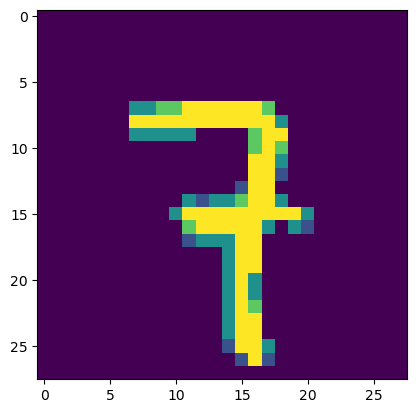

In [4]:
img = ds.train.images[104]
plt.imshow(to_plottable(img, ds.image_shape))

In [5]:
def get_patch_ixs(shape, kernel):
    ksz, kst = kernel
    return np.array([
            [
                [i, j, i+ksz, j+ksz]
                for j in range(0, shape[-1] - ksz + 1, kst)
            ]
            for i in range(0, shape[-2] - ksz + 1, kst)
        ], 
        dtype=int
    )

kernel_configs = dict(mnist=(14, 7), cifar=(16, 8)) 
ksz, kst = kernel_configs[ds.name]
print(ksz, kst)
patch_ixs = get_patch_ixs(ds.image_shape, (ksz, kst))
patch_ixs

14 7


array([[[ 0,  0, 14, 14],
        [ 0,  7, 14, 21],
        [ 0, 14, 14, 28]],

       [[ 7,  0, 21, 14],
        [ 7,  7, 21, 21],
        [ 7, 14, 21, 28]],

       [[14,  0, 28, 14],
        [14,  7, 28, 21],
        [14, 14, 28, 28]]])

In [6]:
def get_patches(img, patch_ixs, orig_shape):
    img = to_unified(img, orig_shape)
    patches = [
        img[..., up_i:bot_i, up_j:bot_j].ravel()
        for row in patch_ixs
        for up_i, up_j, bot_i, bot_j in row
    ]
    patches = np.stack(patches)
    return patches

def plot_patches(patches, orig_shape):
    n_rows = n_cols = int(np.sqrt(patches.shape[0]))
    fig, axes = plt.subplots(n_rows, n_cols)
    for row in range(n_rows):
        for col in range(n_cols):
            ax = axes[row, col]
            patch = patches[row*n_cols + col]
            ax.imshow(to_plottable(patch, orig_shape))

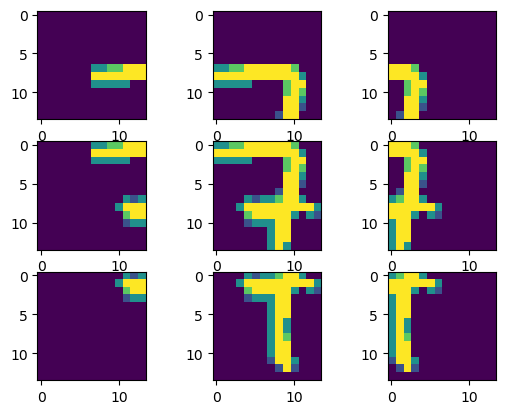

In [7]:
patches = get_patches(img, patch_ixs, ds.image_shape)
plot_patches(patches, ds.image_shape)

## Classifier

In [8]:
# from hima.experiments.temporal_pooling.stp.mlp_torch import MlpClassifier

# classifier = MlpClassifier(
#     classification=True, 
#     layers=[ds.sds.size, 64, ds.n_classes],
#     learning_rate=0.02,
#     seed=seed
# )

In [9]:
def split_to_batches(order, batch_size):
    n_samples = len(order)
    return np.array_split(order, n_samples // batch_size)
def to_patched_ds(ds, patch_ixs, orig_shape):
    return np.stack([
        get_patches(img, patch_ixs, orig_shape)
        for img in ds
    ])

patched_ds = to_patched_ds(ds.train.images[:100], patch_ixs, ds.image_shape)
patched_ds.shape

(100, 9, 196)

In [8]:
class ProcessingType(Enum):
    CONCAT = 1
    LSTM = auto()
    SUM_ATTENTION = auto()
    SE = auto()

class Classifier(nn.Module):
    layer_dims: list[int]

    _lr_epoch_step: int
    _lr_epoch_steps: int

    def __init__(
            self,
            orig_shape: tuple(int, int),
            kernel: tuple(int, int),
            layers: list[int],
            learning_rate: float,
            batch_size: int = 64,
            seed: int = None,
            processing_type: ProcessingType = ProcessingType.CONCAT,
            se_config: dict = None, se_pooling: int = 1
    ):
        super().__init__()
        self.rng = np.random.default_rng(seed)
        self.lr = learning_rate

        self.type = 'CE classifier'
        self.loss_func = nn.CrossEntropyLoss()
        self.orig_shape = orig_shape
        n_channels = self.orig_shape[0]

        ksz, kst = kernel
        self.kernel_config = kernel
        self.patch_ixs = get_patch_ixs(orig_shape, kernel)
        n_patches = np.prod(self.patch_ixs.shape[:2])
        print(f'Patches: {n_patches} x {ksz*ksz} [{ksz} x {ksz}]')
        
        self.processing_type = processing_type
        if processing_type == ProcessingType.CONCAT:
            self.kernel = nn.Linear(n_channels*ksz*ksz, layers[0], dtype=float)
        elif processing_type == ProcessingType.LSTM:
            self.kernel = nn.LSTM(n_channels*ksz*ksz, layers[0], batch_first=True)
            n_patches = 1
        elif processing_type == ProcessingType.SUM_ATTENTION:
            self.kernel = nn.Linear(n_channels*ksz*ksz, layers[0], dtype=float)
            self.attention = torch.ones((1, n_patches, 1), requires_grad=True, dtype=float)

            with torch.no_grad():
                self.attention /= torch.sum(self.attention)
            n_patches = 1
        elif processing_type == ProcessingType.SE:
            feedforward_sds = Sds(size=n_channels*ksz*ksz, sparsity=1.0)
            output_sds = Sds(size=layers[0], active_size=se_config.pop('output_sds'))
            self.kernel = SpatialEncoderLayer(
                feedforward_sds=feedforward_sds, output_sds=output_sds, **se_config
            )
            self.se_pooling = se_pooling
            assert n_patches % se_pooling == 0
            n_patches //= se_pooling
            self.se_learn = True
        else:
            raise ValueError(f'Processing type {processing_type} is not supported!')

        if processing_type != ProcessingType.SE:
            print(self.kernel)
            nn_layers = [nn.SiLU()]
        else:
            nn_layers = []

        nn_layers.append(
            nn.Linear(n_patches * layers[0], layers[1], dtype=float)
        )
        for i in range(1, len(layers) - 1):
            nn_layers.append(nn.SiLU())
            nn_layers.append(nn.Linear(layers[i], layers[i + 1], dtype=float))

        self.mlp = nn.Sequential(*nn_layers)
        print(self.mlp)

        self.optim = optim.Adam(
            self.parameters(),
            lr=self.lr, weight_decay=1e-6
        )

        self.batch_size = batch_size
        self._loss = 0.
        self._last_loss = 0.
        self._batch_cnt = 0

        self._min_lr = self.lr / 20.0
        self._lr_epoch = lambda lr: int(7.0 / lr)
        self._lr_scaler = lambda _: 0.8
        self.lr_scheduler = optim.lr_scheduler.MultiplicativeLR(
            self.optim, lr_lambda=self._lr_scaler,
        )
        self._lr_epoch_step = 0
        self._lr_epoch_steps = self._lr_epoch(self.lr)

    def set_se_learn(self, learn):
        self.se_learn = learn

    def forward(self, x):
        return self._predict(x)

    def _predict(self, patches):
        pr_type = self.processing_type
        if pr_type != ProcessingType.SE:
            patches = torch.from_numpy(patches)

        if pr_type == ProcessingType.CONCAT:
            zs = self.kernel(patches).flatten(start_dim=1)
        elif pr_type == ProcessingType.LSTM:
            _, (zs, _) = self.kernel(patches)
            zs = zs.squeeze()
        elif pr_type == ProcessingType.SUM_ATTENTION:
            zs = self.kernel(patches)
            zs = torch.sum(zs * self.attention, dim=1)
            zs = zs.squeeze()
        elif pr_type == ProcessingType.SE:
            bsz, _, ff_size = patches.shape
            patches = patches.reshape(-1, ff_size)
            sdr = np.arange(ff_size)
            batch = SdrArray(
                sparse=[RateSdr(sdr, p) for p in patches],
                dense=patches,
            )
            zs = self.kernel.compute_batch(batch, learn=torch.is_grad_enabled() and self.se_learn)
            zs = zs.get_batch_dense(np.arange(len(zs)))
            if self.se_pooling > 1:
                zs = zs.reshape(bsz, -1, self.se_pooling, zs.shape[-1])
                zs = zs.mean(2)
            
            zs = zs.reshape(bsz,  -1)
            zs = torch.from_numpy(zs)
        return self.mlp(zs)

    def predict(self, img):
        with torch.no_grad():
            return self._predict(img).numpy()

    def learn(self, img, targets):
        n_samples = len(targets)

        y_pred = self._predict(img)
        targets = torch.from_numpy(targets)
        loss = self.loss_func(y_pred, targets)

        self._batch_cnt += n_samples
        self._loss += loss
        if self._batch_cnt >= self.batch_size:
            self._loss /= round(self._batch_cnt / n_samples)
            self._last_loss += 0.05 * (self._loss.item() - self._last_loss)
            self._loss.backward()
            self.optim.step()
            self.optim.zero_grad()
            
            self._batch_cnt = 0
            self._loss = 0.
            if self.processing_type == ProcessingType.SUM_ATTENTION:
                with torch.no_grad():
                    self.attention /= torch.abs(self.attention).sum()

            self._lr_epoch_step += 1
            if self.lr > self._min_lr and self._lr_epoch_step >= self._lr_epoch_steps:
                self.lr *= self._lr_scaler(True)
                self._lr_epoch_step = 0
                self._lr_epoch_steps = self._lr_epoch(self.lr)
                # print(f'New LR: {self.lr:.5f} for {self._lr_epoch_steps} steps')
                self.lr_scheduler.step()

    @property
    def input_size(self):
        return self.layer_dims[0]

    @property
    def output_size(self):
        return self.layer_dims[-1]

classifier = Classifier(
    orig_shape=ds.image_shape,
    kernel=kernel_configs[ds.name],
    # kernel=(28, 28),
    layers=[64, ds.n_classes],
    learning_rate=0.05,
    batch_size=64,
    seed=seed,
)
classifier.predict(
    to_patched_ds(
        ds.train.images[:3], 
        get_patch_ixs(ds.image_shape, classifier.kernel_config),
        ds.image_shape
    )
).shape

Patches: 9 x 196 [14 x 14]
Linear(in_features=196, out_features=64, bias=True)
Sequential(
  (0): SiLU()
  (1): Linear(in_features=576, out_features=10, bias=True)
)


(3, 10)

In [9]:
from tqdm.notebook import trange, tqdm

def run_test(classifier, ds, n_epochs, n_se_epochs=None, show_progress=False):
    classifier = torch.compile(classifier)
    patch_ixs = get_patch_ixs(ds.image_shape, classifier.kernel_config)
    patched_train = to_patched_ds(ds.train.images, patch_ixs, ds.image_shape)
    patched_test = to_patched_ds(ds.test.images, patch_ixs, ds.image_shape)
    
    for epoch in range(n_epochs):
        train_order = rng.permutation(len(ds.train))
        batched_ixs = split_to_batches(train_order, classifier.batch_size)

        if n_se_epochs is not None and epoch == n_se_epochs:
            classifier.set_se_learn(False)

        if show_progress:
            batched_ixs = tqdm(batched_ixs)
        for ixs in batched_ixs:
            img = patched_train[ixs]
            target = ds.train.targets[ixs]
            
            classifier.learn(img, target)
    
        n_test_samples = len(ds.test)
        batched_ixs = split_to_batches(np.arange(n_test_samples), classifier.batch_size)    
        y_pred = np.sum([
            np.count_nonzero(
                ds.test.targets[ixs] == np.argmax(classifier.predict(patched_test[ixs]), axis=-1)
            )
            for ixs in batched_ixs
        ])
        y_pred /= n_test_samples
        print(f'{epoch+1}: {100.0*y_pred:.2f} \t | {classifier._last_loss:.5f}')

rng = np.random.default_rng(seed)

classifier = Classifier(
    orig_shape=ds.image_shape,
    # kernel=kernel_configs[ds.name],
    kernel=(28, 28),
    layers=[32, ds.n_classes],
    learning_rate=0.01,
    batch_size=64,
    seed=seed,
    processing_type=ProcessingType.SUM_ATTENTION,
)
run_test(classifier, ds, 3)

Patches: 1 x 784 [28 x 28]
Linear(in_features=784, out_features=32, bias=True)
Sequential(
  (0): SiLU()
  (1): Linear(in_features=32, out_features=10, bias=True)
)
1: 95.39 	 | 0.14161
2: 96.28 	 | 0.12881
3: 96.35 	 | 0.12789


In [106]:
%%time

seed = 8041990
ds = Dataset(seed, 'mnist', lp_norm=0)

mnist LOADED images: (70000, 784) (1, 28, 28) | targets: (70000,)
CPU times: user 337 ms, sys: 210 ms, total: 546 ms
Wall time: 580 ms


In [110]:
%%time
rng = np.random.default_rng(seed)
classifier = Classifier(
    orig_shape=ds.image_shape,
    # kernel=kernel_configs[ds.name],
    kernel=(14, 7),
    layers=[32, ds.n_classes],
    learning_rate=0.01,
    batch_size=64,
    seed=seed,
    processing_type=ProcessingType.CONCAT,
)
run_test(classifier, ds, 10, show_progress=True)

Patches: 9 x 196 [14 x 14]
Linear(in_features=196, out_features=32, bias=True)
Sequential(
  (0): SiLU()
  (1): Linear(in_features=288, out_features=10, bias=True)
)


  0%|          | 0/937 [00:00<?, ?it/s]

1: 97.34 	 | 0.08357


  0%|          | 0/937 [00:00<?, ?it/s]

2: 97.37 	 | 0.08236


  0%|          | 0/937 [00:00<?, ?it/s]

3: 97.53 	 | 0.08140


  0%|          | 0/937 [00:00<?, ?it/s]

4: 98.18 	 | 0.05773


  0%|          | 0/937 [00:00<?, ?it/s]

5: 97.81 	 | 0.03586


  0%|          | 0/937 [00:00<?, ?it/s]

6: 98.21 	 | 0.04247


  0%|          | 0/937 [00:00<?, ?it/s]

7: 98.04 	 | 0.02676


  0%|          | 0/937 [00:00<?, ?it/s]

8: 98.39 	 | 0.01865


  0%|          | 0/937 [00:00<?, ?it/s]

9: 98.15 	 | 0.01679


  0%|          | 0/937 [00:00<?, ?it/s]

10: 98.18 	 | 0.00721
CPU times: user 16.7 s, sys: 539 ms, total: 17.3 s
Wall time: 17.3 s


### MNIST

In [3]:
%%time

seed = 8041990
ds = MnistDataset(seed, 'mnist', lp_norm=2)

mnist LOADED images: (70000, 28, 28) | targets: (70000,)
CPU times: user 752 ms, sys: 398 ms, total: 1.15 s
Wall time: 1.4 s


In [90]:
%%time
rng = np.random.default_rng(seed)
classifier = Classifier(
    orig_shape=ds.image_shape,
    # kernel=kernel_configs[ds.name],
    kernel=(28, 28),
    layers=[32, ds.n_classes],
    learning_rate=0.01,
    batch_size=64,
    seed=seed
)
run_test(classifier, ds, 20)

Linear(in_features=784, out_features=32, bias=True)
Sequential(
  (0): SiLU()
  (1): Linear(in_features=32, out_features=10, bias=True)
)
1: 94.67 	 | 0.17859
2: 95.73 	 | 0.14084
3: 96.84 	 | 0.13083
4: 96.81 	 | 0.10641
5: 97.08 	 | 0.09443
6: 97.16 	 | 0.08630
7: 97.18 	 | 0.07376
8: 97.29 	 | 0.06984
9: 97.35 	 | 0.05787
10: 97.45 	 | 0.05032
11: 97.33 	 | 0.05583
12: 97.48 	 | 0.05565
13: 97.40 	 | 0.05124
14: 97.57 	 | 0.04863
15: 97.51 	 | 0.04743
16: 97.67 	 | 0.03453
17: 97.65 	 | 0.04402
18: 97.55 	 | 0.03641
19: 97.67 	 | 0.03444
20: 97.57 	 | 0.03345
CPU times: user 16.7 s, sys: 1.88 s, total: 18.5 s
Wall time: 18.6 s


In [91]:
%%time
rng = np.random.default_rng(seed)
classifier = Classifier(
    orig_shape=ds.image_shape,
    kernel=kernel_configs[ds.name],
    # kernel=(28, 28),
    layers=[32, ds.n_classes],
    learning_rate=0.01,
    batch_size=64,
    seed=seed
)
run_test(classifier, ds, 20)

Linear(in_features=196, out_features=32, bias=True)
Sequential(
  (0): SiLU()
  (1): Linear(in_features=288, out_features=10, bias=True)
)
1: 96.71 	 | 0.11719
2: 97.42 	 | 0.08951
3: 97.88 	 | 0.07760
4: 98.03 	 | 0.07384
5: 98.07 	 | 0.04869
6: 98.31 	 | 0.05267
7: 98.43 	 | 0.04294
8: 98.48 	 | 0.03886
9: 98.32 	 | 0.03069
10: 98.48 	 | 0.02591
11: 98.46 	 | 0.03200
12: 98.33 	 | 0.02615
13: 98.35 	 | 0.02997
14: 98.40 	 | 0.02424
15: 98.43 	 | 0.02862
16: 98.46 	 | 0.01534
17: 98.50 	 | 0.01916
18: 98.44 	 | 0.02478
19: 98.50 	 | 0.01341
20: 98.48 	 | 0.01904
CPU times: user 30.4 s, sys: 3.63 s, total: 34.1 s
Wall time: 34.7 s


### CIFAR-10

In [212]:
%%time

seed = 8041990
ds = MnistDataset(seed, 'cifar', lp_norm=2)

cifar LOADED images: (60000, 32, 32) | targets: (60000,)
CPU times: user 472 ms, sys: 403 ms, total: 874 ms
Wall time: 876 ms


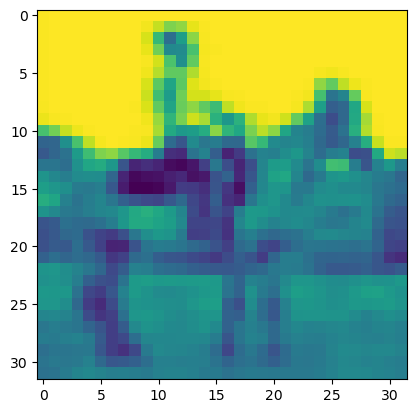

In [213]:
img = ds.train.images[22]
if ds.grayscale:
    plt.imshow(img)
else:
    plt.imshow(img.transpose(1, 2, 0))

In [214]:
ksz, kst = kernel_configs[ds.name]
print(ksz, kst)
patch_ixs = get_patch_ixs(ds.image_shape, (ksz, kst))
patch_ixs

16 8


array([[[ 0,  0, 16, 16],
        [ 0,  8, 16, 24],
        [ 0, 16, 16, 32]],

       [[ 8,  0, 24, 16],
        [ 8,  8, 24, 24],
        [ 8, 16, 24, 32]],

       [[16,  0, 32, 16],
        [16,  8, 32, 24],
        [16, 16, 32, 32]]])

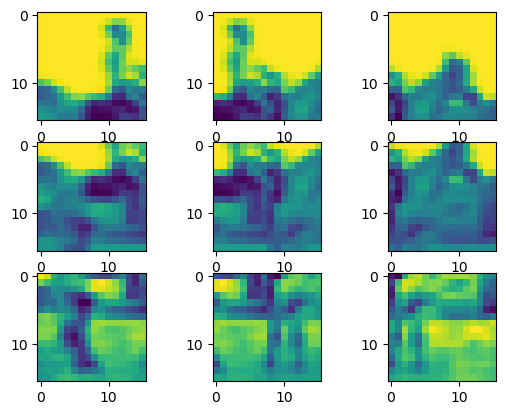

In [215]:
patches, fl_patches = get_patches(img, patch_ixs)
plot_patches(patches)

In [101]:
%%time
rng = np.random.default_rng(seed)
classifier = Classifier(
    orig_shape=ds.image_shape,
    # kernel=kernel_configs[ds.name],
    kernel=(32, 32),
    layers=[128, ds.n_classes],
    learning_rate=0.01,
    batch_size=64,
    seed=seed
)
run_test(classifier, ds, 20)

Linear(in_features=1024, out_features=128, bias=True)
Sequential(
  (0): SiLU()
  (1): Linear(in_features=128, out_features=10, bias=True)
)
1: 29.83 	 | 1.96162
2: 33.09 	 | 1.90579
3: 33.57 	 | 1.86518
4: 34.04 	 | 1.83283
5: 35.62 	 | 1.72803
6: 37.45 	 | 1.71023
7: 38.26 	 | 1.71483
8: 38.73 	 | 1.66854
9: 39.34 	 | 1.68157
10: 39.02 	 | 1.62361
11: 39.34 	 | 1.62930
12: 39.72 	 | 1.59226
13: 39.73 	 | 1.59938
14: 40.03 	 | 1.56043
15: 40.54 	 | 1.59727
16: 40.87 	 | 1.62420
17: 40.17 	 | 1.56985
18: 40.46 	 | 1.56882
19: 39.68 	 | 1.57905
20: 39.95 	 | 1.56152
CPU times: user 41 s, sys: 8.88 s, total: 49.9 s
Wall time: 50.5 s


In [103]:
%%time
rng = np.random.default_rng(seed)
classifier = Classifier(
    orig_shape=ds.image_shape,
    kernel=(16, 8),
    layers=[64, ds.n_classes],
    learning_rate=0.01,
    batch_size=64,
    seed=seed
)
run_test(classifier, ds, 40)

Linear(in_features=256, out_features=64, bias=True)
Sequential(
  (0): SiLU()
  (1): Linear(in_features=576, out_features=10, bias=True)
)
1: 28.29 	 | 1.99190
2: 34.19 	 | 1.92562
3: 34.96 	 | 1.88697
4: 35.94 	 | 1.86942
5: 36.52 	 | 1.77242
6: 37.52 	 | 1.75917
7: 37.78 	 | 1.77982
8: 38.68 	 | 1.74631
9: 38.52 	 | 1.74509
10: 38.59 	 | 1.70606
11: 38.72 	 | 1.69520
12: 39.48 	 | 1.65488
13: 39.86 	 | 1.66872
14: 39.65 	 | 1.63398
15: 39.82 	 | 1.67084
16: 40.28 	 | 1.68203
17: 39.82 	 | 1.64384
18: 40.39 	 | 1.64245
19: 40.33 	 | 1.64292
20: 39.50 	 | 1.64077
21: 40.87 	 | 1.61255
22: 41.07 	 | 1.64416
23: 39.98 	 | 1.62973
24: 41.13 	 | 1.60206
25: 41.28 	 | 1.59990
26: 41.30 	 | 1.61779
27: 41.17 	 | 1.61112
28: 40.85 	 | 1.56366
29: 41.35 	 | 1.61531
30: 41.13 	 | 1.57559
31: 41.65 	 | 1.58449
32: 41.23 	 | 1.59613
33: 41.58 	 | 1.52270
34: 41.80 	 | 1.55402
35: 41.77 	 | 1.60170
36: 41.90 	 | 1.60299
37: 42.27 	 | 1.56994
38: 41.80 	 | 1.52817
39: 41.55 	 | 1.56024
40: 41.81 	 

In [112]:
%%time
rng = np.random.default_rng(seed)
classifier = Classifier(
    orig_shape=ds.image_shape,
    kernel=(8, 4),
    layers=[32, ds.n_classes],
    learning_rate=0.006,
    batch_size=64,
    seed=seed
)
run_test(classifier, ds, 30)

Linear(in_features=64, out_features=32, bias=True)
Sequential(
  (0): SiLU()
  (1): Linear(in_features=1568, out_features=10, bias=True)
)
1: 27.85 	 | 2.02738
2: 28.74 	 | 2.02219
3: 29.43 	 | 2.00198
4: 31.37 	 | 1.98242
5: 33.37 	 | 1.85778
6: 33.98 	 | 1.84903
7: 35.07 	 | 1.86160
8: 35.23 	 | 1.84377
9: 36.19 	 | 1.81950
10: 35.89 	 | 1.77996
11: 35.89 	 | 1.76402
12: 37.54 	 | 1.74005
13: 37.36 	 | 1.74500
14: 37.17 	 | 1.71290
15: 37.56 	 | 1.75254
16: 38.37 	 | 1.75871
17: 38.16 	 | 1.71895
18: 38.27 	 | 1.71943
19: 38.49 	 | 1.71888
20: 37.52 	 | 1.70937
21: 39.08 	 | 1.69244
22: 38.72 	 | 1.70704
23: 38.25 	 | 1.69822
24: 39.03 	 | 1.68647
25: 38.78 	 | 1.68164
26: 39.09 	 | 1.68982
27: 38.84 	 | 1.70352
28: 38.79 	 | 1.65547
29: 39.15 	 | 1.70779
30: 39.01 	 | 1.67105
CPU times: user 1min 39s, sys: 13 s, total: 1min 52s
Wall time: 1min 53s


In [113]:
%%time
rng = np.random.default_rng(seed)
classifier = Classifier(
    orig_shape=ds.image_shape,
    kernel=(8, 4),
    layers=[32, ds.n_classes],
    learning_rate=0.002,
    batch_size=64,
    seed=seed
)
run_test(classifier, ds, 30)

Linear(in_features=64, out_features=32, bias=True)
Sequential(
  (0): SiLU()
  (1): Linear(in_features=1568, out_features=10, bias=True)
)
1: 29.13 	 | 2.02636
2: 29.35 	 | 2.02700
3: 29.34 	 | 2.01626
4: 30.00 	 | 2.03914
5: 30.55 	 | 1.95718
6: 30.39 	 | 1.95035
7: 32.62 	 | 1.93778
8: 34.57 	 | 1.88450
9: 35.09 	 | 1.87172
10: 35.77 	 | 1.82823
11: 35.69 	 | 1.79828
12: 36.67 	 | 1.76728
13: 37.11 	 | 1.78524
14: 36.36 	 | 1.74782
15: 37.68 	 | 1.78417
16: 37.95 	 | 1.78888
17: 38.51 	 | 1.75421
18: 38.31 	 | 1.74107
19: 39.08 	 | 1.73996
20: 37.17 	 | 1.72904
21: 39.35 	 | 1.70953
22: 39.02 	 | 1.71940
23: 38.86 	 | 1.72155
24: 39.62 	 | 1.69904
25: 39.51 	 | 1.69736
26: 40.03 	 | 1.71672
27: 39.68 	 | 1.70598
28: 40.01 	 | 1.66926
29: 40.18 	 | 1.71474
30: 39.76 	 | 1.68062
CPU times: user 1min 33s, sys: 14.2 s, total: 1min 47s
Wall time: 1min 49s


In [118]:
%%time
rng = np.random.default_rng(seed)
classifier = Classifier(
    orig_shape=ds.image_shape,
    kernel=(8, 4),
    layers=[32, 32, ds.n_classes],
    learning_rate=0.002,
    batch_size=64,
    seed=seed
)
run_test(classifier, ds, 30)

Linear(in_features=64, out_features=32, bias=True)
Sequential(
  (0): SiLU()
  (1): Linear(in_features=1568, out_features=32, bias=True)
  (2): SiLU()
  (3): Linear(in_features=32, out_features=10, bias=True)
)
1: 33.17 	 | 1.86447
2: 34.94 	 | 1.83774
3: 36.66 	 | 1.80187
4: 37.59 	 | 1.78789
5: 38.30 	 | 1.70065
6: 37.85 	 | 1.69696
7: 38.46 	 | 1.72849
8: 39.32 	 | 1.67852
9: 39.38 	 | 1.68683
10: 39.33 	 | 1.63752
11: 39.86 	 | 1.65034
12: 40.32 	 | 1.61647
13: 39.95 	 | 1.63009
14: 40.11 	 | 1.59205
15: 40.15 	 | 1.62525
16: 40.17 	 | 1.65979
17: 41.02 	 | 1.60529
18: 40.46 	 | 1.57833
19: 40.85 	 | 1.60612
20: 39.49 	 | 1.61565
21: 40.90 	 | 1.57200
22: 41.37 	 | 1.59422
23: 41.16 	 | 1.57186
24: 40.75 	 | 1.52532
25: 41.52 	 | 1.56981
26: 41.92 	 | 1.55964
27: 41.66 	 | 1.55747
28: 41.47 	 | 1.52757
29: 42.02 	 | 1.55018
30: 42.02 	 | 1.51252
CPU times: user 1min 47s, sys: 21.6 s, total: 2min 8s
Wall time: 2min 8s


In [119]:
%%time
rng = np.random.default_rng(seed)
classifier = Classifier(
    orig_shape=ds.image_shape,
    kernel=(16, 8),
    layers=[64, 64, ds.n_classes],
    learning_rate=0.002,
    batch_size=64,
    seed=seed
)
run_test(classifier, ds, 30)

Linear(in_features=256, out_features=64, bias=True)
Sequential(
  (0): SiLU()
  (1): Linear(in_features=576, out_features=64, bias=True)
  (2): SiLU()
  (3): Linear(in_features=64, out_features=10, bias=True)
)
1: 32.39 	 | 1.90967
2: 34.96 	 | 1.85541
3: 35.73 	 | 1.80602
4: 37.53 	 | 1.75773
5: 39.36 	 | 1.66183
6: 39.68 	 | 1.65545
7: 40.72 	 | 1.66890
8: 40.70 	 | 1.62756
9: 41.45 	 | 1.64121
10: 41.74 	 | 1.57957
11: 41.62 	 | 1.59376
12: 41.78 	 | 1.55133
13: 42.45 	 | 1.54475
14: 42.15 	 | 1.53049
15: 41.65 	 | 1.56548
16: 42.71 	 | 1.58981
17: 42.43 	 | 1.53592
18: 42.49 	 | 1.50122
19: 42.81 	 | 1.54154
20: 41.59 	 | 1.51975
21: 42.30 	 | 1.51382
22: 43.03 	 | 1.49127
23: 42.43 	 | 1.50587
24: 42.50 	 | 1.46697
25: 42.65 	 | 1.47452
26: 43.13 	 | 1.48267
27: 42.87 	 | 1.48015
28: 43.38 	 | 1.43806
29: 43.14 	 | 1.46653
30: 43.37 	 | 1.42362
CPU times: user 1min 28s, sys: 10.3 s, total: 1min 38s
Wall time: 1min 38s


### With -mean

In [216]:
%%time

seed = 8041990
ds = MnistDataset(seed, 'cifar', lp_norm=0)

cifar LOADED images: (60000, 32, 32) | targets: (60000,)
CPU times: user 367 ms, sys: 170 ms, total: 537 ms
Wall time: 536 ms


In [219]:
%%time
rng = np.random.default_rng(seed)
classifier = Classifier(
    orig_shape=ds.image_shape,
    # kernel=kernel_configs[ds.name],
    kernel=(32, 32),
    layers=[128, ds.n_classes],
    learning_rate=0.003,
    batch_size=64,
    seed=seed
)
run_test(classifier, ds, 20)

Linear(in_features=1024, out_features=128, bias=True)
Sequential(
  (0): SiLU()
  (1): Linear(in_features=128, out_features=10, bias=True)
)
1: 37.46 	 | 1.72865
2: 41.21 	 | 1.68192
3: 41.73 	 | 1.63326
4: 42.96 	 | 1.56771
5: 43.35 	 | 1.43472
6: 43.80 	 | 1.42692
7: 43.80 	 | 1.39577
8: 43.87 	 | 1.32775
9: 43.64 	 | 1.32756
10: 44.87 	 | 1.27608
11: 44.79 	 | 1.29934
12: 44.69 	 | 1.19143
13: 44.93 	 | 1.13975
14: 44.70 	 | 1.13987
15: 44.59 	 | 1.17531
16: 43.62 	 | 1.18591
17: 43.87 	 | 1.12794
18: 43.91 	 | 1.08113
19: 44.00 	 | 1.05872
20: 43.85 	 | 1.04135
CPU times: user 41.2 s, sys: 8.17 s, total: 49.4 s
Wall time: 49.8 s


In [221]:
%%time
rng = np.random.default_rng(seed)
classifier = Classifier(
    orig_shape=ds.image_shape,
    kernel=(8, 4),
    layers=[32, 32, ds.n_classes],
    learning_rate=0.001,
    batch_size=64,
    seed=seed
)
run_test(classifier, ds, 30)

Linear(in_features=64, out_features=32, bias=True)
Sequential(
  (0): SiLU()
  (1): Linear(in_features=1568, out_features=32, bias=True)
  (2): SiLU()
  (3): Linear(in_features=32, out_features=10, bias=True)
)
1: 39.19 	 | 1.68161
2: 43.13 	 | 1.62504
3: 44.89 	 | 1.55736
4: 46.52 	 | 1.50993
5: 47.84 	 | 1.36980
6: 48.60 	 | 1.33500
7: 48.96 	 | 1.33062
8: 49.66 	 | 1.27830
9: 50.30 	 | 1.24001
10: 50.70 	 | 1.20800
11: 51.01 	 | 1.21080
12: 51.77 	 | 1.12733
13: 51.84 	 | 1.10982
14: 52.45 	 | 1.10583
15: 52.18 	 | 1.11478
16: 51.78 	 | 1.14698
17: 51.41 	 | 1.07826
18: 52.19 	 | 1.03479
19: 52.21 	 | 1.03546
20: 52.02 	 | 1.00360
21: 52.36 	 | 1.00303
22: 52.57 	 | 0.98277
23: 52.15 	 | 0.96536
24: 52.11 	 | 0.93419
25: 52.17 	 | 0.93680
26: 52.36 	 | 0.94462
27: 52.38 	 | 0.91977
28: 52.50 	 | 0.88579
29: 51.79 	 | 0.91718
30: 52.14 	 | 0.91639
CPU times: user 1min 56s, sys: 13.8 s, total: 2min 10s
Wall time: 2min 11s


In [220]:
%%time
rng = np.random.default_rng(seed)
classifier = Classifier(
    orig_shape=ds.image_shape,
    kernel=(16, 8),
    layers=[64, 64, ds.n_classes],
    learning_rate=0.001,
    batch_size=64,
    seed=seed
)
run_test(classifier, ds, 30)

Linear(in_features=256, out_features=64, bias=True)
Sequential(
  (0): SiLU()
  (1): Linear(in_features=576, out_features=64, bias=True)
  (2): SiLU()
  (3): Linear(in_features=64, out_features=10, bias=True)
)
1: 39.62 	 | 1.65312
2: 43.99 	 | 1.59029
3: 45.99 	 | 1.51659
4: 47.54 	 | 1.45569
5: 48.62 	 | 1.31790
6: 48.85 	 | 1.29973
7: 49.47 	 | 1.27014
8: 49.78 	 | 1.22616
9: 49.95 	 | 1.20936
10: 50.24 	 | 1.14195
11: 50.34 	 | 1.15713
12: 50.42 	 | 1.07411
13: 50.70 	 | 1.05815
14: 50.08 	 | 1.02793
15: 50.29 	 | 1.03577
16: 50.06 	 | 1.05952
17: 49.64 	 | 1.00355
18: 50.09 	 | 0.97216
19: 50.44 	 | 0.96014
20: 49.53 	 | 0.92770
21: 50.08 	 | 0.93190
22: 50.28 	 | 0.89021
23: 49.62 	 | 0.87590
24: 49.77 	 | 0.86733
25: 49.51 	 | 0.84812
26: 49.81 	 | 0.87804
27: 49.62 	 | 0.82323
28: 49.49 	 | 0.81956
29: 49.23 	 | 0.81002
30: 49.38 	 | 0.77944
CPU times: user 1min 28s, sys: 4.59 s, total: 1min 33s
Wall time: 1min 33s


### CIFAR-10 RGB

In [112]:
%%time

seed = 8041990
ds = Dataset(seed, 'cifar', grayscale=False, lp_norm=2)

cifar LOADED images: (60000, 3072) (3, 32, 32) | targets: (60000,)
CPU times: user 1.33 s, sys: 1.85 s, total: 3.19 s
Wall time: 3.95 s


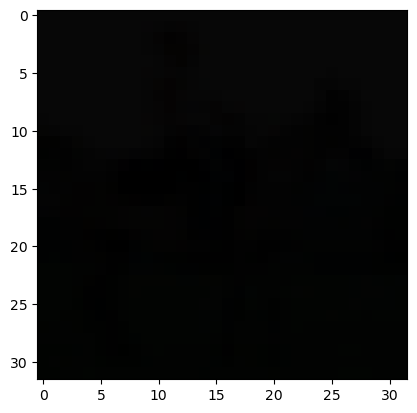

In [113]:
img = ds.train.images[22]
plt.imshow(to_plottable(img, ds.image_shape))

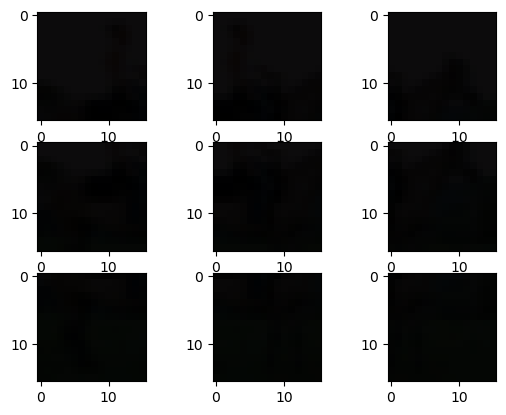

In [227]:
patches, fl_patches = get_patches(img, patch_ixs)
plot_patches(patches)

In [115]:
%%time
rng = np.random.default_rng(seed)
classifier = Classifier(
    orig_shape=ds.image_shape,
    kernel=ds.image_shape[1:],
    layers=[128, ds.n_classes],
    learning_rate=0.006,
    batch_size=64,
    seed=seed
)
run_test(classifier, ds, 30)

Patches: 1 x 1024 [32 x 32]
Linear(in_features=3072, out_features=128, bias=True)
Sequential(
  (0): SiLU()
  (1): Linear(in_features=128, out_features=10, bias=True)
)
1: 37.58 	 | 1.75531
2: 41.99 	 | 1.63403
3: 43.84 	 | 1.59262
4: 43.30 	 | 1.55317
5: 45.19 	 | 1.45080
6: 46.50 	 | 1.43220
7: 47.58 	 | 1.44660
8: 47.44 	 | 1.39090
9: 48.80 	 | 1.36847
10: 49.47 	 | 1.33867
11: 49.88 	 | 1.32058
12: 50.13 	 | 1.29177
13: 50.27 	 | 1.24498
14: 50.73 	 | 1.25223
15: 51.04 	 | 1.24512
16: 50.93 	 | 1.27982
17: 50.48 	 | 1.22677
18: 50.67 	 | 1.22547
19: 51.35 	 | 1.21666
20: 50.73 	 | 1.22066
21: 50.41 	 | 1.19728
22: 51.27 	 | 1.19250
23: 50.58 	 | 1.17771
24: 51.71 	 | 1.15251
25: 52.02 	 | 1.15959
26: 52.13 	 | 1.16732
27: 51.58 	 | 1.19493
28: 51.84 	 | 1.12049
29: 51.82 	 | 1.15834
30: 51.38 	 | 1.09950
CPU times: user 2min 34s, sys: 3.05 s, total: 2min 37s
Wall time: 2min 39s


In [116]:
%%time
rng = np.random.default_rng(seed)
classifier = Classifier(
    orig_shape=ds.image_shape,
    kernel=(16, 8),
    layers=[64, ds.n_classes],
    learning_rate=0.006,
    batch_size=64,
    seed=seed
)
run_test(classifier, ds, 30)

Patches: 9 x 256 [16 x 16]
Linear(in_features=768, out_features=64, bias=True)
Sequential(
  (0): SiLU()
  (1): Linear(in_features=576, out_features=10, bias=True)
)
1: 39.62 	 | 1.73885
2: 43.36 	 | 1.62126
3: 45.49 	 | 1.60383
4: 45.74 	 | 1.56216
5: 46.52 	 | 1.47084
6: 48.44 	 | 1.45693
7: 48.43 	 | 1.47581
8: 49.51 	 | 1.44877
9: 49.49 	 | 1.43415
10: 49.56 	 | 1.40042
11: 49.04 	 | 1.36810
12: 49.86 	 | 1.32736
13: 50.16 	 | 1.30621
14: 50.73 	 | 1.33151
15: 50.54 	 | 1.31422
16: 50.69 	 | 1.35370
17: 51.18 	 | 1.29613
18: 51.06 	 | 1.29291
19: 50.70 	 | 1.30496
20: 50.83 	 | 1.32101
21: 51.57 	 | 1.29312
22: 51.72 	 | 1.29146
23: 51.84 	 | 1.25289
24: 51.75 	 | 1.25627
25: 51.67 	 | 1.26336
26: 51.93 	 | 1.26288
27: 51.88 	 | 1.26431
28: 51.37 	 | 1.20439
29: 51.93 	 | 1.24709
30: 51.88 	 | 1.22384
CPU times: user 2min 31s, sys: 20.3 s, total: 2min 51s
Wall time: 2min 53s


In [239]:
%%time
rng = np.random.default_rng(seed)
classifier = Classifier(
    orig_shape=ds.image_shape,
    kernel=(8, 4),
    layers=[32, ds.n_classes],
    learning_rate=0.006,
    batch_size=64,
    seed=seed
)
run_test(classifier, ds, 30)

Linear(in_features=192, out_features=32, bias=True)
Sequential(
  (0): SiLU()
  (1): Linear(in_features=1568, out_features=10, bias=True)
)
1: 35.73 	 | 1.87498
2: 39.42 	 | 1.77355
3: 37.16 	 | 1.79194
4: 41.44 	 | 1.71675
5: 41.75 	 | 1.59145
6: 44.52 	 | 1.55680
7: 44.20 	 | 1.59695
8: 46.71 	 | 1.56781
9: 46.21 	 | 1.55454
10: 46.64 	 | 1.51770
11: 46.25 	 | 1.50019
12: 46.12 	 | 1.46029
13: 47.24 	 | 1.41454
14: 46.97 	 | 1.43161
15: 47.52 	 | 1.45175
16: 47.74 	 | 1.46606
17: 47.56 	 | 1.39803
18: 48.00 	 | 1.41732
19: 48.00 	 | 1.38784
20: 47.31 	 | 1.43038
21: 47.75 	 | 1.40487
22: 48.67 	 | 1.38642
23: 48.12 	 | 1.38272
24: 48.60 	 | 1.36640
25: 48.83 	 | 1.37577
26: 48.83 	 | 1.37608
27: 48.87 	 | 1.39918
28: 48.65 	 | 1.33803
29: 49.10 	 | 1.37880
30: 49.38 	 | 1.36044
CPU times: user 2min 38s, sys: 34.8 s, total: 3min 13s
Wall time: 3min 16s


In [240]:
%%time
rng = np.random.default_rng(seed)
classifier = Classifier(
    orig_shape=ds.image_shape,
    kernel=(8, 4),
    layers=[32, 32, ds.n_classes],
    learning_rate=0.006,
    batch_size=64,
    seed=seed
)
run_test(classifier, ds, 30)

Linear(in_features=192, out_features=32, bias=True)
Sequential(
  (0): SiLU()
  (1): Linear(in_features=1568, out_features=32, bias=True)
  (2): SiLU()
  (3): Linear(in_features=32, out_features=10, bias=True)
)
1: 37.64 	 | 1.70655
2: 43.58 	 | 1.64613
3: 45.09 	 | 1.55981
4: 45.38 	 | 1.53613
5: 46.83 	 | 1.43321
6: 47.30 	 | 1.42808
7: 46.85 	 | 1.47157
8: 47.83 	 | 1.41773
9: 48.30 	 | 1.38500
10: 48.16 	 | 1.36231
11: 48.54 	 | 1.33962
12: 48.68 	 | 1.29081
13: 49.23 	 | 1.23327
14: 49.52 	 | 1.25567
15: 48.96 	 | 1.25663
16: 49.64 	 | 1.32486
17: 49.52 	 | 1.23338
18: 49.76 	 | 1.19774
19: 49.67 	 | 1.21965
20: 49.48 	 | 1.23594
21: 49.87 	 | 1.22490
22: 49.79 	 | 1.18395
23: 49.90 	 | 1.20814
24: 50.39 	 | 1.16301
25: 50.34 	 | 1.18365
26: 50.38 	 | 1.16353
27: 49.64 	 | 1.14641
28: 49.05 	 | 1.12183
29: 49.97 	 | 1.13710
30: 50.36 	 | 1.13069
CPU times: user 2min 57s, sys: 39.5 s, total: 3min 36s
Wall time: 3min 38s


In [241]:
%%time
rng = np.random.default_rng(seed)
classifier = Classifier(
    orig_shape=ds.image_shape,
    kernel=(16, 8),
    layers=[64, 64, ds.n_classes],
    learning_rate=0.006,
    batch_size=64,
    seed=seed
)
run_test(classifier, ds, 30)

Linear(in_features=768, out_features=64, bias=True)
Sequential(
  (0): SiLU()
  (1): Linear(in_features=576, out_features=64, bias=True)
  (2): SiLU()
  (3): Linear(in_features=64, out_features=10, bias=True)
)
1: 37.90 	 | 1.69403
2: 44.17 	 | 1.60363
3: 45.91 	 | 1.53697
4: 48.16 	 | 1.45653
5: 48.41 	 | 1.37064
6: 49.32 	 | 1.29569
7: 49.90 	 | 1.37957
8: 49.50 	 | 1.29374
9: 51.30 	 | 1.21903
10: 50.64 	 | 1.20069
11: 51.42 	 | 1.18264
12: 51.11 	 | 1.13529
13: 50.78 	 | 1.07307
14: 51.32 	 | 1.07602
15: 51.03 	 | 1.06940
16: 51.79 	 | 1.09953
17: 51.65 	 | 1.06491
18: 50.64 	 | 1.04543
19: 51.67 	 | 0.99514
20: 51.51 	 | 1.03380
21: 51.66 	 | 1.00508
22: 51.75 	 | 0.97170
23: 51.22 	 | 0.96291
24: 52.06 	 | 0.93374
25: 51.80 	 | 0.95528
26: 52.10 	 | 0.92475
27: 52.25 	 | 0.92106
28: 50.95 	 | 0.91510
29: 52.04 	 | 0.90211
30: 51.59 	 | 0.89034
CPU times: user 2min 47s, sys: 20.6 s, total: 3min 7s
Wall time: 3min 8s


### With RGB -mean

In [118]:
%%time

seed = 8041990
ds = Dataset(seed, 'cifar', grayscale=False, lp_norm=0)

cifar LOADED images: (60000, 3072) (3, 32, 32) | targets: (60000,)
CPU times: user 1.16 s, sys: 806 ms, total: 1.96 s
Wall time: 2.27 s


In [122]:
%%time
rng = np.random.default_rng(seed)
classifier = Classifier(
    orig_shape=ds.image_shape,
    kernel=ds.image_shape[1:],
    layers=[128, ds.n_classes],
    learning_rate=0.0006,
    batch_size=64,
    seed=seed
)
run_test(classifier, ds, 20)

Patches: 1 x 1024 [32 x 32]
Linear(in_features=3072, out_features=128, bias=True)
Sequential(
  (0): SiLU()
  (1): Linear(in_features=128, out_features=10, bias=True)
)
1: 46.02 	 | 1.53055
2: 49.39 	 | 1.43456
3: 50.48 	 | 1.37494
4: 51.14 	 | 1.31993
5: 51.99 	 | 1.20641
6: 52.49 	 | 1.18212
7: 52.50 	 | 1.19721
8: 52.59 	 | 1.13105
9: 52.21 	 | 1.09896
10: 52.80 	 | 1.06691
11: 52.67 	 | 1.04148
12: 53.46 	 | 0.96516
13: 53.24 	 | 0.94344
14: 53.46 	 | 0.94149
15: 53.51 	 | 0.88829
16: 53.01 	 | 0.92815
17: 53.43 	 | 0.87656
18: 52.97 	 | 0.82914
19: 53.14 	 | 0.83671
20: 52.77 	 | 0.80079
CPU times: user 1min 45s, sys: 12.9 s, total: 1min 58s
Wall time: 1min 59s


In [125]:
%%time
rng = np.random.default_rng(seed)
classifier = Classifier(
    orig_shape=ds.image_shape,
    kernel=(8, 4),
    layers=[32, 32, ds.n_classes],
    learning_rate=0.0004,
    batch_size=64,
    seed=seed
)
run_test(classifier, ds, 20)

Patches: 49 x 64 [8 x 8]
Linear(in_features=192, out_features=32, bias=True)
Sequential(
  (0): SiLU()
  (1): Linear(in_features=1568, out_features=32, bias=True)
  (2): SiLU()
  (3): Linear(in_features=32, out_features=10, bias=True)
)
1: 46.24 	 | 1.52172
2: 50.31 	 | 1.40691
3: 52.28 	 | 1.35063
4: 52.81 	 | 1.33944
5: 54.73 	 | 1.21235
6: 55.29 	 | 1.19668
7: 55.17 	 | 1.22291
8: 56.51 	 | 1.15541
9: 56.17 	 | 1.14671
10: 57.15 	 | 1.10962
11: 56.78 	 | 1.08547
12: 57.68 	 | 1.01991
13: 57.85 	 | 1.00504
14: 58.46 	 | 0.99221
15: 58.30 	 | 0.97761
16: 59.10 	 | 1.00501
17: 58.79 	 | 0.96576
18: 58.99 	 | 0.92842
19: 59.16 	 | 0.90757
20: 58.76 	 | 0.91388
CPU times: user 2min 1s, sys: 20.5 s, total: 2min 21s
Wall time: 2min 23s


In [119]:
%%time
rng = np.random.default_rng(seed)
classifier = Classifier(
    orig_shape=ds.image_shape,
    kernel=(7, 3),
    layers=[32, 32, ds.n_classes],
    learning_rate=0.001,
    batch_size=64,
    seed=seed
)
run_test(classifier, ds, 20)

Linear(in_features=147, out_features=32, bias=True)
Sequential(
  (0): SiLU()
  (1): Linear(in_features=2592, out_features=32, bias=True)
  (2): SiLU()
  (3): Linear(in_features=32, out_features=10, bias=True)
)
1: 49.57 	 | 1.38920
2: 52.28 	 | 1.30447
3: 54.17 	 | 1.27579
4: 55.16 	 | 1.21409
5: 56.38 	 | 1.09257
6: 57.41 	 | 1.08319
7: 57.48 	 | 1.07188
8: 58.34 	 | 0.98559
9: 58.91 	 | 0.96297
10: 59.04 	 | 0.91511
11: 59.08 	 | 0.90019
12: 59.56 	 | 0.82528
13: 59.24 	 | 0.80663
14: 58.88 	 | 0.80664
15: 59.12 	 | 0.74874
16: 58.89 	 | 0.77718
17: 58.86 	 | 0.71096
18: 59.15 	 | 0.67853
19: 59.15 	 | 0.65688
20: 58.89 	 | 0.62689
CPU times: user 2min 51s, sys: 33.5 s, total: 3min 25s
Wall time: 3min 29s


### + LSTM

### + LSTM w/ -mean

In [32]:
%%time

seed = 8041990
ds = MnistDataset(seed, 'cifar', lp_norm=0)

cifar LOADED images: (60000, 32, 32) | targets: (60000,)
CPU times: user 372 ms, sys: 245 ms, total: 618 ms
Wall time: 626 ms


In [33]:
%%time
rng = np.random.default_rng(seed)
classifier = Classifier(
    orig_shape=ds.image_shape,
    kernel=ds.image_shape,
    layers=[128, ds.n_classes],
    learning_rate=0.003,
    batch_size=64,
    seed=seed,
    use_lstm=True
)
run_test(classifier, ds, 20)

LSTM(1024, 128, batch_first=True)
Sequential(
  (0): SiLU()
  (1): Linear(in_features=128, out_features=10, bias=True)
)
1: 37.57 	 | 1.72856
2: 39.60 	 | 1.67631
3: 40.74 	 | 1.60721
4: 41.67 	 | 1.54296
5: 42.17 	 | 1.38830
6: 42.26 	 | 1.38164
7: 42.54 	 | 1.32697
8: 42.69 	 | 1.23723
9: 42.72 	 | 1.21687
10: 42.89 	 | 1.14092
11: 42.32 	 | 1.13718
12: 42.57 	 | 1.01215
13: 42.15 	 | 1.01641
14: 42.07 	 | 0.92094
15: 42.26 	 | 0.92705
16: 42.11 	 | 0.93525
17: 41.45 	 | 0.86582
18: 41.10 	 | 0.80432
19: 41.16 	 | 0.78105
20: 41.06 	 | 0.76320
CPU times: user 2min 45s, sys: 23.6 s, total: 3min 9s
Wall time: 3min 13s


In [34]:
%%time
rng = np.random.default_rng(seed)
classifier = Classifier(
    orig_shape=ds.image_shape,
    kernel=(8, 4),
    layers=[32, ds.n_classes],
    learning_rate=0.001,
    batch_size=64,
    seed=seed,
    use_lstm=True
)
run_test(classifier, ds, 30)

LSTM(64, 32, batch_first=True)
Sequential(
  (0): SiLU()
  (1): Linear(in_features=32, out_features=10, bias=True)
)
1: 26.06 	 | 1.99046
2: 31.08 	 | 1.85660
3: 33.57 	 | 1.83908
4: 35.21 	 | 1.77254
5: 36.65 	 | 1.68453
6: 37.27 	 | 1.65334
7: 38.29 	 | 1.65073
8: 40.22 	 | 1.64328
9: 41.02 	 | 1.61848
10: 41.85 	 | 1.57734
11: 42.07 	 | 1.57992
12: 42.85 	 | 1.51891
13: 42.90 	 | 1.53220
14: 44.09 	 | 1.50281
15: 44.42 	 | 1.50362
16: 44.83 	 | 1.52727
17: 45.37 	 | 1.49048
18: 45.03 	 | 1.48629
19: 45.78 	 | 1.47957
20: 45.96 	 | 1.43767
21: 46.35 	 | 1.44944
22: 46.83 	 | 1.42543
23: 46.29 	 | 1.42194
24: 47.57 	 | 1.39508
25: 47.21 	 | 1.39302
26: 47.63 	 | 1.40125
27: 48.01 	 | 1.41061
28: 47.95 	 | 1.38826
29: 47.61 	 | 1.40191
30: 48.13 	 | 1.39059
CPU times: user 7min 24s, sys: 29.4 s, total: 7min 53s
Wall time: 7min 55s


In [36]:
%%time
rng = np.random.default_rng(seed)
classifier = Classifier(
    orig_shape=ds.image_shape,
    kernel=(8, 4),
    layers=[128, ds.n_classes],
    learning_rate=0.002,
    batch_size=64,
    seed=seed,
    use_lstm=True
)
run_test(classifier, ds, 30)

LSTM(64, 128, batch_first=True)
Sequential(
  (0): SiLU()
  (1): Linear(in_features=128, out_features=10, bias=True)
)
1: 29.72 	 | 1.84011
2: 38.28 	 | 1.71067
3: 42.06 	 | 1.63470
4: 45.21 	 | 1.52252
5: 48.19 	 | 1.38283
6: 48.76 	 | 1.34746
7: 50.36 	 | 1.30870
8: 51.11 	 | 1.27329
9: 52.48 	 | 1.23725
10: 52.01 	 | 1.17632
11: 52.88 	 | 1.11305
12: 52.82 	 | 1.03897
13: 53.23 	 | 0.99445
14: 52.62 	 | 0.94504


KeyboardInterrupt: 

### LSTM RGB -mean

In [38]:
%%time

seed = 8041990
ds = MnistDataset(seed, 'cifar', grayscale=False, lp_norm=0)

cifar LOADED images: (60000, 3, 32, 32) | targets: (60000,)
CPU times: user 1.17 s, sys: 1.29 s, total: 2.46 s
Wall time: 3.43 s


In [39]:
%%time
rng = np.random.default_rng(seed)
classifier = Classifier(
    orig_shape=ds.image_shape,
    kernel=(8, 4),
    layers=[64, 32, ds.n_classes],
    learning_rate=0.002,
    batch_size=64,
    seed=seed,
    use_lstm=True
)
run_test(classifier, ds, 18)

LSTM(192, 64, batch_first=True)
Sequential(
  (0): SiLU()
  (1): Linear(in_features=64, out_features=32, bias=True)
  (2): SiLU()
  (3): Linear(in_features=32, out_features=10, bias=True)
)
1: 36.46 	 | 1.66190
2: 42.01 	 | 1.56419
3: 46.71 	 | 1.46878
4: 48.92 	 | 1.37886
5: 50.73 	 | 1.28152
6: 51.64 	 | 1.24993
7: 52.42 	 | 1.24425
8: 53.68 	 | 1.19266
9: 55.13 	 | 1.15834
10: 55.28 	 | 1.12064
11: 55.75 	 | 1.09652
12: 56.03 	 | 1.04752
13: 56.09 	 | 1.02092
14: 56.20 	 | 1.02918
15: 57.19 	 | 0.99493
16: 57.60 	 | 0.99612
17: 56.93 	 | 0.96346
18: 57.32 	 | 0.92474
CPU times: user 13min 44s, sys: 59.3 s, total: 14min 43s
Wall time: 14min 47s


In [51]:
%%time
rng = np.random.default_rng(seed)
classifier = Classifier(
    orig_shape=ds.image_shape,
    kernel=(13, 7),
    layers=[128, 32, ds.n_classes],
    learning_rate=0.002,
    batch_size=64,
    seed=seed,
    use_lstm=True
)
run_test(classifier, ds, 18)

LSTM(507, 128, batch_first=True)
Sequential(
  (0): SiLU()
  (1): Linear(in_features=128, out_features=32, bias=True)
  (2): SiLU()
  (3): Linear(in_features=32, out_features=10, bias=True)
)
1: 43.14 	 | 1.51738
2: 48.87 	 | 1.38958
3: 50.45 	 | 1.31898
4: 51.46 	 | 1.22136
5: 52.54 	 | 1.08267
6: 52.63 	 | 1.02682
7: 52.43 	 | 0.96537
8: 52.16 	 | 0.91760
9: 53.05 	 | 0.81937
10: 51.64 	 | 0.77548


KeyboardInterrupt: 

### + Linear Attention

aggregate processed patches (=hiddens) with the mean of hiddens over learnable attention distribution

In [138]:
%%time

seed = 8041990
ds = Dataset(seed, 'cifar', grayscale=False, lp_norm=0)

cifar LOADED images: (60000, 3, 32, 32) | targets: (60000,)
CPU times: user 1.22 s, sys: 981 ms, total: 2.21 s
Wall time: 2.74 s


In [99]:
%%time
rng = np.random.default_rng(seed)
classifier = Classifier(
    orig_shape=ds.image_shape,
    kernel=(8, 4),
    layers=[128, 32, ds.n_classes],
    learning_rate=0.001,
    batch_size=64,
    seed=seed,
    processing_type=ProcessingType.SUM_ATTENTION
)
run_test(classifier, ds, 30)

Linear(in_features=192, out_features=128, bias=True)
Sequential(
  (0): SiLU()
  (1): Linear(in_features=128, out_features=32, bias=True)
  (2): SiLU()
  (3): Linear(in_features=32, out_features=10, bias=True)
)
1: 28.24 	 | 1.92284
2: 28.90 	 | 1.87819
3: 30.59 	 | 1.84738
4: 31.11 	 | 1.83540
5: 32.47 	 | 1.78999
6: 33.92 	 | 1.81075
7: 34.51 	 | 1.79060
8: 35.27 	 | 1.76062
9: 36.09 	 | 1.71764
10: 37.01 	 | 1.73664
11: 36.99 	 | 1.70692
12: 37.17 	 | 1.68289
13: 38.19 	 | 1.70216
14: 38.31 	 | 1.66227
15: 38.72 	 | 1.66498
16: 38.13 	 | 1.66787
17: 39.18 	 | 1.65099
18: 39.53 	 | 1.65165
19: 39.08 	 | 1.63944
20: 39.01 	 | 1.64463
21: 39.92 	 | 1.63227
22: 40.12 	 | 1.60259
23: 39.98 	 | 1.59663
24: 40.35 	 | 1.61897
25: 40.67 	 | 1.59221
26: 40.07 	 | 1.60654
27: 40.50 	 | 1.62750
28: 40.68 	 | 1.58354
29: 40.89 	 | 1.59081
30: 40.67 	 | 1.62874
CPU times: user 5min 51s, sys: 1min 12s, total: 7min 3s
Wall time: 7min 8s


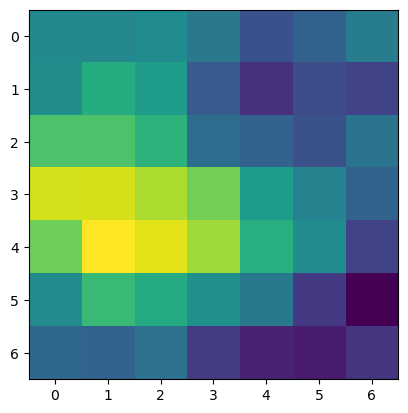

In [116]:
with torch.no_grad():
    plt.imshow((classifier.attention * classifier.attention.nelement()).squeeze().numpy().reshape(7, 7))

### Analyse classifier kernel

In [126]:
kernel = classifier.kernel.weight.detach().numpy()
kernel.shape

(32, 192)

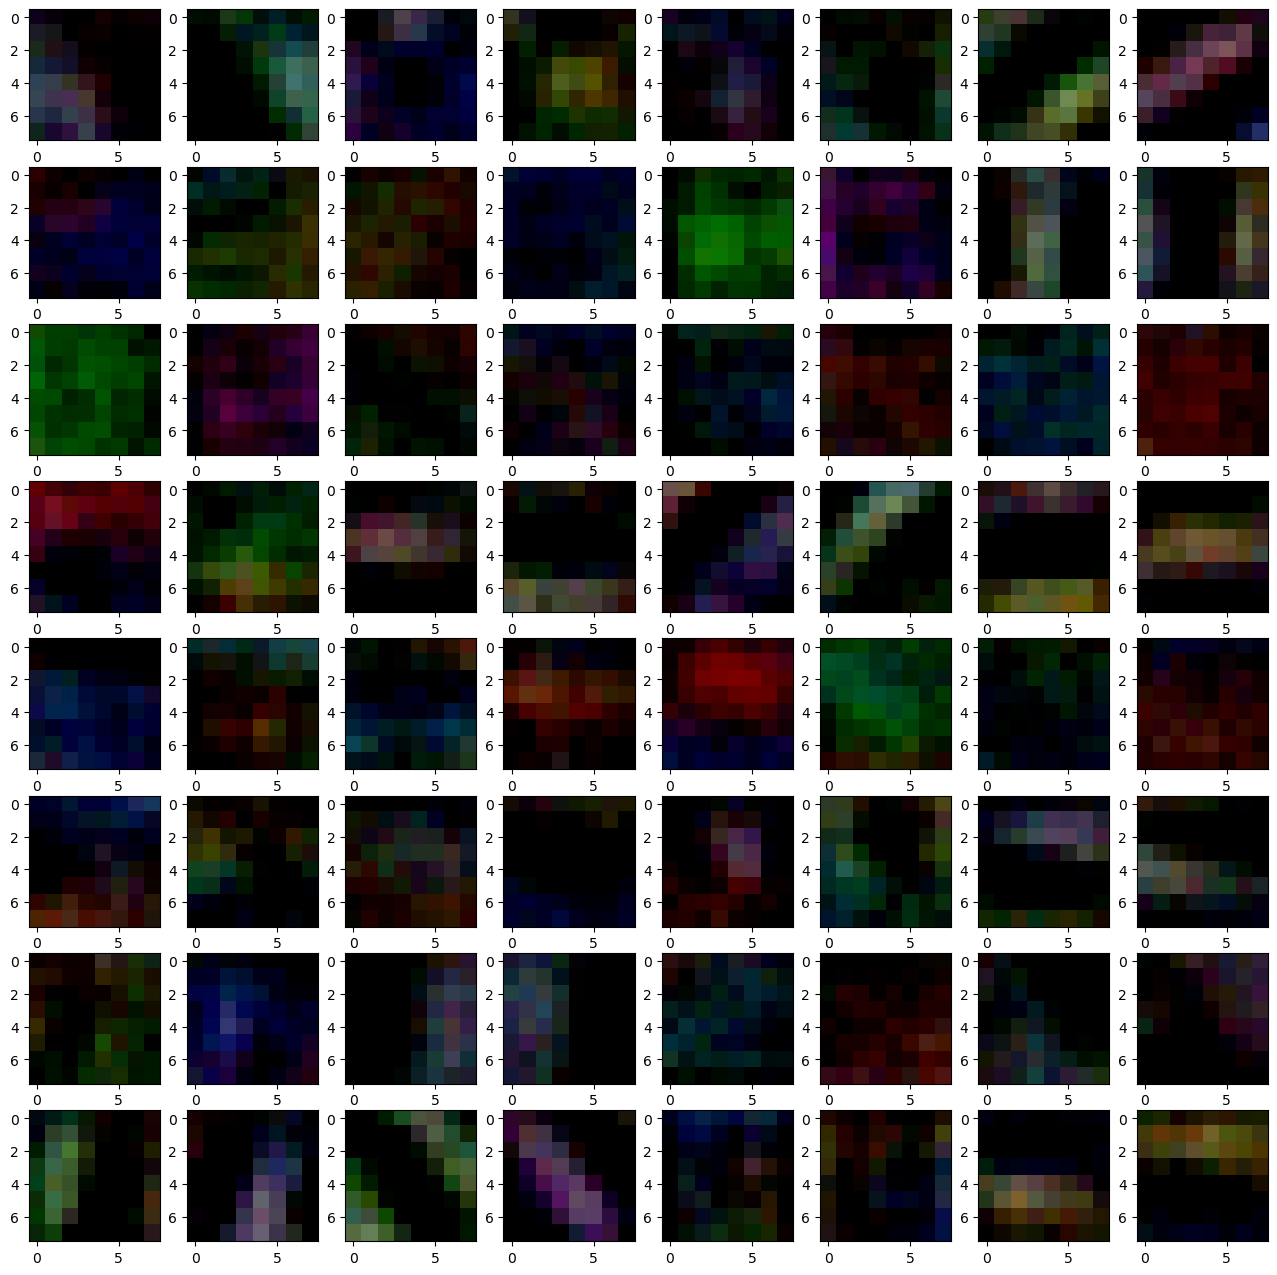

In [127]:
r, c = 8, 4
fig, axes = plt.subplots(r, c*2, figsize=(16, 16))
for i in range(r):
    for j in range(c):
        t = i * c + j
        neuron = to_plottable(kernel[t], ds.image_shape)
        ax = axes[i, 2*j]
        ax.imshow(np.clip(neuron, 0., 1.0))
        ax = axes[i, 2*j+1]
        ax.imshow(np.clip(-neuron, 0., 1.0))

## Classifier with SE encoder

In [10]:
se_config = dict(
    seed=seed,
    adapt_to_ff_sparsity=True,
    lebesgue_p=1.0,
    init_radius=20.0,
    weights_distribution='normal',
    initial_rf_to_input_ratio=100.0,
    initial_max_rf_sparsity=1.0,
    
    pruning={
        'n_stages': 0,
        'cycle': 200.0,
        'mode': 'powerlaw',
        'target_max_rf_sparsity': 0.5,
        'target_rf_to_input_ratio': 0.75,
    },
    synaptogenesis=None,
    
    match_p=None,
    match_op='mul',
    boosting_policy='multiplicative',
    min_boosting_k=0.05,
    activation_policy='powerlaw',
    beta=1.0,
    beta_lr=0.0,
    soft_extra=1.0,
    beta_active_mass=(0.72, 0.82),
    
    normalize_output=False,
    output_extra=10.0,
    
    learning_policy='linear',
    learning_rate= 0.01,
    adaptive_lr=True,
    lr_range=(0.002, 0.1),
    learning_set=(0.75, 0.75),
    anti_hebb_scale=0.8,
    persistent_signs=False,
    normalize_dw=False,
    print_stats_schedule=50_000,
)

In [129]:
%%time

seed = 8041990
ds = Dataset(seed, 'mnist', grayscale=True, lp_norm=1)

mnist LOADED images: (70000, 784) (1, 28, 28) | targets: (70000,)
CPU times: user 361 ms, sys: 311 ms, total: 672 ms
Wall time: 749 ms


In [131]:
%%time
rng = np.random.default_rng(seed)
classifier = Classifier(
    orig_shape=ds.image_shape,
    kernel=ds.image_shape[1:],
    layers=[600, ds.n_classes],
    learning_rate=0.06,
    batch_size=64,
    seed=seed,
    processing_type=ProcessingType.SE,
    se_config=se_config | dict(output_sds=4),
)
run_test(classifier, ds, 8)

Patches: 1 x 784 [28 x 28]
kwargs: {}
K: 4
Init SE dense backend: 1.0-norm | 25.071 | LearningPolicy.LINEAR | match W^1.0 op: mul | Init RF: 1.00 (784)
Soft top K: 44
Hard top K: 44
Learning set: (3, 3)
Output extra: 40
Sequential(
  (0): Linear(in_features=600, out_features=10, bias=True)
)
R=17.843 H=0.993 B=1.00 Sz=41.3 SfS=43.9| ROR[0.08; 0.58]| U[75.4%  0.1281]| W 0.023 [0.000; 0.135] NZP[0; 3; 97]| Y 26 42
1: 91.56 	 | 0.31489
R=13.242 H=0.992 B=1.00 Sz=41.3 SfS=44.0| ROR[0.08; 0.63]| U[56.8%  0.1025]| W 0.017 [0.000; 0.102] NZP[0; 3; 97]| Y 27 42
2: 93.47 	 | 0.26045
R=10.214 H=0.991 B=1.00 Sz=41.3 SfS=44.0| ROR[0.08; 0.62]| U[57.0%  0.0726]| W 0.013 [0.000; 0.078] NZP[0; 3; 97]| Y 26 43
3: 93.95 	 | 0.23834
R=8.156 H=0.991 B=1.00 Sz=41.3 SfS=44.0| ROR[0.08; 0.63]| U[63.2%  0.0563]| W 0.010 [0.000; 0.063] NZP[0; 3; 97]| Y 24 43
4: 94.48 	 | 0.20945
R=6.704 H=0.991 B=1.00 Sz=41.3 SfS=44.0| ROR[0.08; 0.60]| U[58.1%  0.0498]| W 0.009 [0.000; 0.051] NZP[0; 3; 97]| Y 24 39
R=5.653 H=

In [178]:
%%time
rng = np.random.default_rng(seed)
classifier = Classifier(
    orig_shape=ds.image_shape,
    kernel=ds.image_shape,
    layers=[2000, ds.n_classes],
    learning_rate=0.06,
    batch_size=64,
    seed=seed,
    processing_type=ProcessingType.SE,
    se_config=se_config | dict(output_sds=12),
)
run_test(classifier, ds, 6)

kwargs: {}
K: 12
Init SE dense backend: 1.0-norm | 25.089 | LearningPolicy.LINEAR | match W^1.0 op: mul | Init RF: 1.00 (784)
Soft top K: (44, 1936, 41)
Hard top K: 132
Learning set: (9, 9)
Output extra: 120
Sequential(
  (0): Linear(in_features=2000, out_features=10, bias=True)
)
R=21.927 H=0.993 B=1.00 Sz=104.6 SfS=110.8| ROR[0.00; 0.21]| U[76.2%  0.1691]| W 0.028 [0.000; 0.187] NZP[0; 3; 97]| Y 22 132
1: 93.65 	 | 0.31771
R=19.284 H=0.994 B=1.00 Sz=104.4 SfS=110.7| ROR[0.02; 0.20]| U[56.0%  0.1659]| W 0.025 [0.000; 0.167] NZP[0; 3; 97]| Y 36 83
2: 94.38 	 | 0.27804
R=17.058 H=0.994 B=1.00 Sz=104.3 SfS=110.6| ROR[0.02; 0.21]| U[66.8%  0.1312]| W 0.022 [0.000; 0.148] NZP[0; 3; 97]| Y 28 104
3: 94.76 	 | 0.25678
R=15.190 H=0.994 B=1.00 Sz=104.2 SfS=110.6| ROR[0.02; 0.21]| U[68.1%  0.1166]| W 0.019 [0.000; 0.132] NZP[0; 3; 97]| Y 29 107
4: 95.05 	 | 0.22805
R=13.608 H=0.994 B=1.00 Sz=104.1 SfS=110.5| ROR[0.02; 0.22]| U[64.2%  0.1054]| W 0.017 [0.000; 0.120] NZP[0; 3; 97]| Y 32 94
R=12.2

In [166]:
%%time
rng = np.random.default_rng(seed)
classifier = Classifier(
    orig_shape=ds.image_shape,
    kernel=(14, 7),
    layers=[600, ds.n_classes],
    learning_rate=0.06,
    batch_size=64,
    seed=seed,
    processing_type=ProcessingType.SE,
    se_config=se_config | dict(output_sds=4, print_stats_schedule=200_000),
)
run_test(classifier, ds, 10)

kwargs: {}
K: 4
Init SE dense backend: 1.0-norm | 25.041 | LearningPolicy.LINEAR | match W^1.0 op: mul | Init RF: 1.00 (196)
Soft top K: 44
Hard top K: 44
Learning set: (3, 3)
Output extra: 40
Sequential(
  (0): Linear(in_features=5400, out_features=10, bias=True)
)
R=17.779 H=0.993 B=1.00 Sz=41.3 SfS=43.9| ROR[0.07; 0.52]| U[36.3%  0.2065]| W 0.091 [0.000; 0.502] NZP[0; 3; 97]| Y 25 43
R=13.181 H=0.992 B=1.00 Sz=41.3 SfS=44.0| ROR[0.06; 0.54]| U[31.0%  0.1039]| W 0.067 [0.000; 0.372] NZP[0; 3; 97]| Y 24 41
R=10.131 H=0.991 B=1.00 Sz=41.3 SfS=44.0| ROR[0.05; 0.58]| U[41.0%  0.0843]| W 0.052 [0.000; 0.286] NZP[0; 3; 97]| Y 27 40
R=7.989 H=0.991 B=1.00 Sz=41.3 SfS=44.0| ROR[0.05; 0.61]| U[48.4%  0.0795]| W 0.041 [0.000; 0.230] NZP[0; 2; 98]| Y 28 41
R=6.466 H=0.991 B=1.00 Sz=41.3 SfS=44.0| ROR[0.05; 0.64]| U[37.1%  0.0511]| W 0.033 [0.000; 0.184] NZP[0; 2; 98]| Y 22 43
R=5.361 H=0.991 B=1.00 Sz=41.3 SfS=44.0| ROR[0.05; 0.66]| U[33.5%  0.0311]| W 0.027 [0.000; 0.153] NZP[0; 2; 98]| Y 23 4

KeyboardInterrupt: 

In [167]:
%%time
rng = np.random.default_rng(seed)
classifier = Classifier(
    orig_shape=ds.image_shape,
    kernel=(14, 7),
    layers=[300, ds.n_classes],
    learning_rate=0.06,
    batch_size=64,
    seed=seed,
    processing_type=ProcessingType.SE,
    se_config=se_config | dict(output_sds=3, print_stats_schedule=250_000),
)
run_test(classifier, ds, 5)

kwargs: {}
K: 3
Init SE dense backend: 1.0-norm | 25.063 | LearningPolicy.LINEAR | match W^1.0 op: mul | Init RF: 1.00 (196)
Soft top K: 33
Hard top K: 33
Learning set: (2, 2)
Output extra: 30
Sequential(
  (0): Linear(in_features=2700, out_features=10, bias=True)
)
R=3.447 H=0.989 B=1.00 Sz=30.8 SfS=33.0| ROR[0.06; 0.77]| U[35.7%  0.0220]| W 0.018 [0.000; 0.095] NZP[0; 2; 98]| Y 21 32
R=1.689 H=0.990 B=1.00 Sz=30.7 SfS=33.0| ROR[0.06; 0.78]| U[16.6%  0.0070]| W 0.009 [0.000; 0.050] NZP[0; 3; 97]| Y 24 32
1: 97.03 	 | 0.10386
R=1.276 H=0.990 B=1.00 Sz=30.7 SfS=33.0| ROR[0.06; 0.81]| U[12.7%  0.0076]| W 0.007 [0.000; 0.039] NZP[0; 3; 97]| Y 26 30
R=1.121 H=0.991 B=1.00 Sz=30.7 SfS=33.0| ROR[0.06; 0.79]| U[11.8%  0.0028]| W 0.006 [0.000; 0.035] NZP[0; 4; 96]| Y 22 31
R=1.019 H=0.991 B=1.00 Sz=30.7 SfS=33.0| ROR[0.08; 0.77]| U[7.1%  0.0031]| W 0.005 [0.000; 0.034] NZP[0; 4; 96]| Y 27 29
2: 97.53 	 | 0.08832
R=0.934 H=0.992 B=1.00 Sz=30.7 SfS=33.0| ROR[0.11; 0.76]| U[12.3%  0.0024]| W 0.00

In [170]:
%%time
rng = np.random.default_rng(seed)
classifier = Classifier(
    orig_shape=ds.image_shape,
    kernel=(9, 5),
    layers=[100, ds.n_classes],
    learning_rate=0.06,
    batch_size=64,
    seed=seed,
    processing_type=ProcessingType.SE,
    se_config=se_config | dict(output_sds=3, output_extra=6.0, print_stats_schedule=500_000),
)
run_test(classifier, ds, 3)

kwargs: {}
K: 3
Init SE dense backend: 1.0-norm | 24.973 | LearningPolicy.LINEAR | match W^1.0 op: mul | Init RF: 1.00 (81)
Soft top K: 21
Hard top K: 21
Learning set: (2, 2)
Output extra: 18
Sequential(
  (0): Linear(in_features=1600, out_features=10, bias=True)
)
R=0.697 H=0.989 B=1.00 Sz=17.1 SfS=21.0| ROR[0.08; 0.63]| U[32.8%  0.0032]| W 0.009 [0.000; 0.044] NZP[0; 3; 97]| Y 40 20
R=0.353 H=0.987 B=1.00 Sz=17.1 SfS=21.0| ROR[0.07; 0.73]| U[4.8%  0.0024]| W 0.004 [0.000; 0.027] NZP[0; 7; 93]| Y 42 20
1: 97.28 	 | 0.09522
R=0.242 H=0.982 B=1.00 Sz=17.1 SfS=21.0| ROR[0.06; 0.81]| U[4.6%  0.0015]| W 0.003 [0.000; 0.019] NZP[0; 17; 83]| Y 39 18
R=0.199 H=0.977 B=1.00 Sz=17.1 SfS=21.0| ROR[0.05; 0.74]| U[0.2%  0.0012]| W 0.002 [0.000; 0.018] NZP[0; 28; 72]| Y 35 20
2: 96.89 	 | 0.11385
R=0.171 H=0.971 B=1.00 Sz=17.1 SfS=21.0| ROR[0.04; 0.77]| U[0.0%  0.0017]| W 0.002 [0.000; 0.016] NZP[0; 34; 66]| Y 42 20
R=0.150 H=0.965 B=1.00 Sz=17.1 SfS=21.0| ROR[0.04; 0.85]| U[0.0%  0.0015]| W 0.002 

In [181]:
%%time

seed = 8041990
ds = MnistDataset(seed, 'cifar', grayscale=True, lp_norm=1)

cifar LOADED images: (60000, 32, 32) | targets: (60000,)
CPU times: user 464 ms, sys: 544 ms, total: 1.01 s
Wall time: 1.23 s


In [172]:
%%time
rng = np.random.default_rng(seed)
classifier = Classifier(
    orig_shape=ds.image_shape,
    kernel=ds.image_shape,
    layers=[600, ds.n_classes],
    learning_rate=0.06,
    batch_size=64,
    seed=seed,
    processing_type=ProcessingType.SE,
    se_config=se_config | dict(output_sds=4, print_stats_schedule=100_000),
)
run_test(classifier, ds, 10)

kwargs: {}
K: 4
Init SE dense backend: 1.0-norm | 25.062 | LearningPolicy.LINEAR | match W^1.0 op: mul | Init RF: 1.00 (1024)
Soft top K: 44
Hard top K: 44
Learning set: (3, 3)
Output extra: 40
Sequential(
  (0): Linear(in_features=600, out_features=10, bias=True)
)
1: 29.71 	 | 1.96458
R=12.789 H=0.998 B=1.00 Sz=41.3 SfS=44.0| ROR[0.13; 0.34]| U[90.4%  0.0587]| W 0.012 [0.000; 0.069] NZP[0; 1; 99]| Y 23 41
2: 31.02 	 | 1.93404
3: 31.22 	 | 1.91168
R=7.742 H=0.997 B=1.00 Sz=41.3 SfS=44.0| ROR[0.12; 0.34]| U[93.4%  0.0298]| W 0.008 [0.000; 0.040] NZP[0; 0; 100]| Y 26 40
4: 32.08 	 | 1.90045
R=5.321 H=0.997 B=1.00 Sz=41.3 SfS=44.0| ROR[0.11; 0.35]| U[86.3%  0.0187]| W 0.005 [0.000; 0.026] NZP[0; 0; 100]| Y 25 42
5: 32.88 	 | 1.82872
6: 32.95 	 | 1.81795
R=4.010 H=0.996 B=1.00 Sz=41.3 SfS=44.0| ROR[0.11; 0.37]| U[87.1%  0.0120]| W 0.004 [0.000; 0.019] NZP[0; 0; 100]| Y 26 41
7: 33.69 	 | 1.84540
8: 34.32 	 | 1.80962
R=3.233 H=0.996 B=1.00 Sz=41.3 SfS=44.0| ROR[0.10; 0.37]| U[91.4%  0.0086

In [182]:
%%time
rng = np.random.default_rng(seed)
classifier = Classifier(
    orig_shape=ds.image_shape,
    kernel=ds.image_shape,
    layers=[600, ds.n_classes],
    learning_rate=0.06,
    batch_size=64,
    seed=seed,
    processing_type=ProcessingType.SE,
    se_config=se_config | dict(output_sds=5, output_extra=8.0, print_stats_schedule=100_000),
)
run_test(classifier, ds, 15)

kwargs: {}
K: 5
Init SE dense backend: 1.0-norm | 25.062 | LearningPolicy.LINEAR | match W^1.0 op: mul | Init RF: 1.00 (1024)
Soft top K: 45
Hard top K: 45
Learning set: (3, 3)
Output extra: 40
Sequential(
  (0): Linear(in_features=600, out_features=10, bias=True)
)
1: 29.68 	 | 1.95682
R=12.489 H=0.998 B=1.00 Sz=42.3 SfS=45.0| ROR[0.10; 0.29]| U[93.0%  0.0563]| W 0.012 [0.000; 0.068] NZP[0; 1; 99]| Y 37 42
2: 31.01 	 | 1.92166
3: 31.48 	 | 1.89775
R=7.462 H=0.997 B=1.00 Sz=42.3 SfS=45.0| ROR[0.09; 0.28]| U[88.4%  0.0290]| W 0.007 [0.000; 0.038] NZP[0; 0; 100]| Y 29 43
4: 32.90 	 | 1.90544
5: 32.63 	 | 1.82259
R=5.098 H=0.996 B=1.00 Sz=42.3 SfS=45.0| ROR[0.09; 0.29]| U[89.5%  0.0169]| W 0.005 [0.000; 0.025] NZP[0; 0; 100]| Y 33 42
6: 33.27 	 | 1.81706
7: 33.73 	 | 1.84016
R=3.839 H=0.996 B=1.00 Sz=42.3 SfS=45.0| ROR[0.08; 0.29]| U[87.7%  0.0112]| W 0.004 [0.000; 0.018] NZP[0; 0; 100]| Y 29 43
8: 34.23 	 | 1.81470
9: 34.00 	 | 1.82592
R=3.098 H=0.995 B=1.00 Sz=42.3 SfS=45.0| ROR[0.08; 0

In [184]:
%%time
rng = np.random.default_rng(seed)
classifier = Classifier(
    orig_shape=ds.image_shape,
    kernel=(16, 8),
    layers=[250, ds.n_classes],
    learning_rate=0.06,
    batch_size=64,
    seed=seed,
    processing_type=ProcessingType.SE,
    se_config=se_config | dict(output_sds=4, output_extra=8.0, print_stats_schedule=250_000),
)
run_test(classifier, ds, 6)

kwargs: {}
K: 4
Init SE dense backend: 1.0-norm | 25.060 | LearningPolicy.LINEAR | match W^1.0 op: mul | Init RF: 1.00 (256)
Soft top K: 36
Hard top K: 36
Learning set: (3, 3)
Output extra: 32
Sequential(
  (0): Linear(in_features=2250, out_features=10, bias=True)
)
R=1.104 H=0.995 B=1.00 Sz=32.7 SfS=36.0| ROR[0.09; 0.40]| U[65.1%  0.0014]| W 0.004 [0.001; 0.021] NZP[0; 0; 100]| Y 31 34
1: 37.72 	 | 1.74484
R=0.932 H=0.996 B=1.00 Sz=33.2 SfS=36.0| ROR[0.07; 0.37]| U[77.5%  0.0009]| W 0.004 [0.001; 0.017] NZP[0; 0; 100]| Y 32 34
R=0.796 H=0.995 B=1.00 Sz=33.4 SfS=36.0| ROR[0.10; 0.39]| U[92.0%  0.0009]| W 0.003 [0.001; 0.014] NZP[0; 0; 100]| Y 33 34
2: 41.42 	 | 1.64514
R=0.688 H=0.995 B=1.00 Sz=33.5 SfS=36.0| ROR[0.09; 0.41]| U[90.3%  0.0006]| W 0.003 [0.001; 0.011] NZP[0; 0; 100]| Y 25 32
R=0.602 H=0.994 B=1.00 Sz=33.5 SfS=36.0| ROR[0.09; 0.42]| U[88.7%  0.0006]| W 0.002 [0.000; 0.009] NZP[0; 0; 100]| Y 32 31
3: 42.61 	 | 1.59182
R=0.533 H=0.993 B=1.00 Sz=33.6 SfS=36.0| ROR[0.08; 0.42

In [185]:
%%time
rng = np.random.default_rng(seed)
classifier = Classifier(
    orig_shape=ds.image_shape,
    kernel=(9, 5),
    layers=[120, ds.n_classes],
    learning_rate=0.06,
    batch_size=64,
    seed=seed,
    processing_type=ProcessingType.SE,
    se_config=se_config | dict(output_sds=3, output_extra=5.0, print_stats_schedule=500_000),
)
run_test(classifier, ds, 3)

kwargs: {}
K: 3
Init SE dense backend: 1.0-norm | 25.038 | LearningPolicy.LINEAR | match W^1.0 op: mul | Init RF: 1.00 (81)
Soft top K: 18
Hard top K: 18
Learning set: (2, 2)
Output extra: 15
Sequential(
  (0): Linear(in_features=3000, out_features=10, bias=True)
)
R=0.217 H=0.985 B=1.00 Sz=15.1 SfS=18.0| ROR[0.11; 0.59]| U[69.4%  0.0003]| W 0.003 [0.001; 0.011] NZP[0; 0; 100]| Y 50 17
R=0.117 H=0.993 B=1.00 Sz=15.8 SfS=18.0| ROR[0.17; 0.54]| U[72.4%  0.0001]| W 0.001 [0.000; 0.005] NZP[0; 0; 100]| Y 36 17
1: 41.12 	 | 1.63114
R=0.090 H=0.988 B=1.00 Sz=16.0 SfS=18.0| ROR[0.14; 0.62]| U[78.2%  0.0001]| W 0.001 [0.000; 0.003] NZP[0; 0; 100]| Y 52 16
R=0.080 H=0.975 B=1.00 Sz=16.1 SfS=18.0| ROR[0.11; 1.09]| U[69.3%  0.0001]| W 0.001 [0.000; 0.003] NZP[0; 0; 100]| Y 50 16
R=0.075 H=0.956 B=1.00 Sz=16.1 SfS=18.0| ROR[0.09; 2.31]| U[75.8%  0.0001]| W 0.001 [0.000; 0.003] NZP[0; 1; 99]| Y 77 15
2: 44.60 	 | 1.58259
R=0.069 H=0.933 B=1.00 Sz=16.1 SfS=18.0| ROR[0.08; 3.35]| U[64.5%  0.0001]| W 

In [187]:
%%time
rng = np.random.default_rng(seed)
classifier = Classifier(
    orig_shape=ds.image_shape,
    kernel=ds.image_shape,
    layers=[600, 32, ds.n_classes],
    learning_rate=0.06,
    batch_size=64,
    seed=seed,
    processing_type=ProcessingType.SE,
    se_config=se_config | dict(output_sds=5, output_extra=8.0, print_stats_schedule=100_000),
)
run_test(classifier, ds, 15)

kwargs: {}
K: 5
Init SE dense backend: 1.0-norm | 25.062 | LearningPolicy.LINEAR | match W^1.0 op: mul | Init RF: 1.00 (1024)
Soft top K: 45
Hard top K: 45
Learning set: (3, 3)
Output extra: 40
Sequential(
  (0): Linear(in_features=600, out_features=32, bias=True)
  (1): SiLU()
  (2): Linear(in_features=32, out_features=10, bias=True)
)
1: 29.00 	 | 1.94919
R=12.489 H=0.998 B=1.00 Sz=42.3 SfS=45.0| ROR[0.10; 0.29]| U[93.0%  0.0563]| W 0.012 [0.000; 0.068] NZP[0; 1; 99]| Y 37 42
2: 31.22 	 | 1.91666
3: 31.92 	 | 1.88177
R=7.462 H=0.997 B=1.00 Sz=42.3 SfS=45.0| ROR[0.09; 0.28]| U[88.4%  0.0290]| W 0.007 [0.000; 0.038] NZP[0; 0; 100]| Y 29 43
4: 32.89 	 | 1.87887
5: 32.99 	 | 1.79196
R=5.098 H=0.996 B=1.00 Sz=42.3 SfS=45.0| ROR[0.09; 0.29]| U[89.5%  0.0169]| W 0.005 [0.000; 0.025] NZP[0; 0; 100]| Y 33 42
6: 33.96 	 | 1.76906
7: 34.50 	 | 1.78822
R=3.839 H=0.996 B=1.00 Sz=42.3 SfS=45.0| ROR[0.08; 0.29]| U[87.7%  0.0112]| W 0.004 [0.000; 0.018] NZP[0; 0; 100]| Y 29 43
8: 34.66 	 | 1.76412
9

In [188]:
%%time
rng = np.random.default_rng(seed)
classifier = Classifier(
    orig_shape=ds.image_shape,
    kernel=(16, 8),
    layers=[200, 32, ds.n_classes],
    learning_rate=0.06,
    batch_size=64,
    seed=seed,
    processing_type=ProcessingType.SE,
    se_config=se_config | dict(output_sds=4, output_extra=8.0, print_stats_schedule=500_000),
)
run_test(classifier, ds, 6)

kwargs: {}
K: 4
Init SE dense backend: 1.0-norm | 25.069 | LearningPolicy.LINEAR | match W^1.0 op: mul | Init RF: 1.00 (256)
Soft top K: 36
Hard top K: 36
Learning set: (3, 3)
Output extra: 32
Sequential(
  (0): Linear(in_features=1800, out_features=32, bias=True)
  (1): SiLU()
  (2): Linear(in_features=32, out_features=10, bias=True)
)
1: 39.03 	 | 1.68030
R=0.867 H=0.994 B=1.00 Sz=33.4 SfS=36.0| ROR[0.06; 0.37]| U[75.6%  0.0008]| W 0.003 [0.001; 0.015] NZP[0; 0; 100]| Y 35 33
2: 42.02 	 | 1.61257
R=0.610 H=0.993 B=1.00 Sz=33.6 SfS=36.0| ROR[0.10; 0.41]| U[87.8%  0.0005]| W 0.002 [0.001; 0.009] NZP[0; 0; 100]| Y 27 32
3: 42.57 	 | 1.54572
R=0.463 H=0.991 B=1.00 Sz=33.7 SfS=36.0| ROR[0.08; 0.44]| U[87.9%  0.0004]| W 0.002 [0.000; 0.006] NZP[0; 0; 100]| Y 32 34
4: 43.15 	 | 1.50811
R=0.378 H=0.988 B=1.00 Sz=33.7 SfS=36.0| ROR[0.08; 0.48]| U[80.7%  0.0005]| W 0.001 [0.000; 0.005] NZP[0; 0; 100]| Y 29 32
5: 43.90 	 | 1.42955
R=0.327 H=0.986 B=1.00 Sz=33.7 SfS=36.0| ROR[0.07; 0.52]| U[74.8

In [191]:
%%time

seed = 8041990
ds = MnistDataset(seed, 'cifar', grayscale=False, lp_norm=1)

cifar LOADED images: (60000, 3, 32, 32) | targets: (60000,)
CPU times: user 1.44 s, sys: 2.31 s, total: 3.75 s
Wall time: 4.89 s


In [194]:
%%time
rng = np.random.default_rng(seed)
classifier = Classifier(
    orig_shape=ds.image_shape,
    kernel=ds.image_shape[1:],
    layers=[1000, ds.n_classes],
    learning_rate=0.06,
    batch_size=64,
    seed=seed,
    processing_type=ProcessingType.SE,
    se_config=se_config | dict(output_sds=7, output_extra=8.0, print_stats_schedule=100_000),
)
run_test(classifier, ds, 10)

kwargs: {}
K: 7
Init SE dense backend: 1.0-norm | 25.081 | LearningPolicy.LINEAR | match W^1.0 op: mul | Init RF: 1.00 (3072)
Soft top K: (31, 961, 24)
Hard top K: 63
Learning set: (5, 5)
Output extra: 56
Sequential(
  (0): Linear(in_features=1000, out_features=10, bias=True)
)
1: 31.50 	 | 1.92023
R=13.293 H=0.999 B=1.00 Sz=41.8 SfS=44.5| ROR[0.07; 0.20]| U[92.1%  0.0612]| W 0.004 [0.000; 0.026] NZP[0; 0; 100]| Y 41 41
2: 33.30 	 | 1.87707
3: 34.50 	 | 1.83132
R=8.604 H=0.998 B=1.00 Sz=41.8 SfS=44.5| ROR[0.06; 0.20]| U[79.1%  0.0359]| W 0.003 [0.000; 0.015] NZP[0; 0; 100]| Y 39 44
4: 35.95 	 | 1.81825
5: 35.96 	 | 1.75219
R=6.382 H=0.997 B=1.00 Sz=41.8 SfS=44.5| ROR[0.06; 0.22]| U[82.0%  0.0236]| W 0.002 [0.000; 0.009] NZP[0; 0; 100]| Y 39 45
6: 36.25 	 | 1.73842
7: 37.02 	 | 1.76119
R=5.184 H=0.996 B=1.00 Sz=41.8 SfS=44.5| ROR[0.06; 0.24]| U[78.7%  0.0176]| W 0.002 [0.000; 0.007] NZP[0; 0; 100]| Y 39 39
8: 36.81 	 | 1.72562
9: 37.64 	 | 1.72680
R=4.476 H=0.995 B=1.00 Sz=41.8 SfS=44.5

In [195]:
%%time
rng = np.random.default_rng(seed)
classifier = Classifier(
    orig_shape=ds.image_shape,
    kernel=(16, 8),
    layers=[250, ds.n_classes],
    learning_rate=0.06,
    batch_size=64,
    seed=seed,
    processing_type=ProcessingType.SE,
    se_config=se_config | dict(output_sds=5, output_extra=8.0, print_stats_schedule=500_000),
)
run_test(classifier, ds, 6)

kwargs: {}
K: 5
Init SE dense backend: 1.0-norm | 25.076 | LearningPolicy.LINEAR | match W^1.0 op: mul | Init RF: 1.00 (768)
Soft top K: 45
Hard top K: 45
Learning set: (3, 3)
Output extra: 40
Sequential(
  (0): Linear(in_features=2250, out_features=10, bias=True)
)
1: 35.93 	 | 1.84155
R=1.148 H=0.997 B=1.00 Sz=41.9 SfS=45.0| ROR[0.05; 0.28]| U[75.2%  0.0012]| W 0.001 [0.001; 0.004] NZP[0; 0; 100]| Y 33 43
2: 44.15 	 | 1.63447
R=1.028 H=0.992 B=1.00 Sz=42.2 SfS=45.0| ROR[0.10; 0.38]| U[85.4%  0.0008]| W 0.001 [0.000; 0.004] NZP[0; 0; 100]| Y 27 42
3: 44.90 	 | 1.57106
R=0.946 H=0.989 B=1.00 Sz=42.3 SfS=45.0| ROR[0.09; 0.41]| U[84.4%  0.0009]| W 0.001 [0.000; 0.003] NZP[0; 0; 100]| Y 35 42
4: 46.10 	 | 1.54360
R=0.888 H=0.985 B=1.00 Sz=42.4 SfS=45.0| ROR[0.08; 0.45]| U[75.9%  0.0011]| W 0.001 [0.000; 0.003] NZP[0; 0; 100]| Y 25 43
5: 46.20 	 | 1.47588
R=0.847 H=0.983 B=1.00 Sz=42.4 SfS=45.0| ROR[0.07; 0.49]| U[70.3%  0.0010]| W 0.001 [0.000; 0.003] NZP[0; 0; 100]| Y 32 42
6: 46.51 	 | 

In [197]:
%%time

seed = 8041990
ds = MnistDataset(seed, 'cifar', grayscale=False, lp_norm=-1)

cifar LOADED images: (60000, 3, 32, 32) | targets: (60000,)
CPU times: user 1.35 s, sys: 1.78 s, total: 3.13 s
Wall time: 3.93 s


In [199]:
%%time
rng = np.random.default_rng(seed)
classifier = Classifier(
    orig_shape=ds.image_shape,
    kernel=ds.image_shape[-2:],
    layers=[2000, ds.n_classes],
    learning_rate=0.06,
    batch_size=64,
    seed=seed,
    processing_type=ProcessingType.SE,
    se_config=se_config | dict(output_sds=12, output_extra=8.0, print_stats_schedule=100_000),
)
run_test(classifier, ds, 10)

kwargs: {}
K: 12
Init SE dense backend: 1.0-norm | 25.069 | LearningPolicy.LINEAR | match W^1.0 op: mul | Init RF: 1.00 (3072)
Soft top K: (44, 1936, 36)
Hard top K: 108
Learning set: (9, 9)
Output extra: 96
Sequential(
  (0): Linear(in_features=2000, out_features=10, bias=True)
)
1: 40.11 	 | 1.73581
R=16.616 H=0.998 B=1.00 Sz=68.9 SfS=72.7| ROR[0.04; 0.13]| U[96.2%  0.0253]| W 0.005 [0.000; 0.035] NZP[0; 2; 98]| Y 51 51
2: 41.19 	 | 1.67795
3: 41.39 	 | 1.65468
R=11.731 H=0.998 B=1.00 Sz=68.9 SfS=72.8| ROR[0.04; 0.13]| U[91.2%  0.0161]| W 0.004 [0.000; 0.024] NZP[0; 1; 99]| Y 41 75
4: 42.19 	 | 1.63620
5: 41.25 	 | 1.58581
R=8.731 H=0.998 B=1.00 Sz=68.9 SfS=72.8| ROR[0.04; 0.13]| U[93.5%  0.0080]| W 0.003 [0.000; 0.018] NZP[0; 0; 100]| Y 41 67
6: 42.14 	 | 1.58721
7: 42.57 	 | 1.59776
R=6.803 H=0.998 B=1.00 Sz=69.0 SfS=72.9| ROR[0.04; 0.13]| U[93.9%  0.0113]| W 0.002 [0.000; 0.013] NZP[0; 0; 100]| Y 35 83
8: 42.59 	 | 1.56471
9: 42.60 	 | 1.56167
R=5.508 H=0.998 B=1.00 Sz=69.0 SfS=72

In [200]:
%%time
rng = np.random.default_rng(seed)
classifier = Classifier(
    orig_shape=ds.image_shape,
    kernel=(16, 8),
    layers=[250, ds.n_classes],
    learning_rate=0.06,
    batch_size=64,
    seed=seed,
    processing_type=ProcessingType.SE,
    se_config=se_config | dict(output_sds=5, output_extra=8.0, print_stats_schedule=500_000),
)
run_test(classifier, ds, 6)

kwargs: {}
K: 5
Init SE dense backend: 1.0-norm | 25.076 | LearningPolicy.LINEAR | match W^1.0 op: mul | Init RF: 1.00 (768)
Soft top K: 45
Hard top K: 45
Learning set: (3, 3)
Output extra: 40
Sequential(
  (0): Linear(in_features=2250, out_features=10, bias=True)
)
1: 42.43 	 | 1.63384
R=0.987 H=0.995 B=1.00 Sz=41.8 SfS=45.0| ROR[0.05; 0.32]| U[86.9%  0.0001]| W 0.001 [0.000; 0.006] NZP[0; 0; 100]| Y 27 43
2: 47.41 	 | 1.48704
R=0.759 H=0.994 B=1.00 Sz=42.2 SfS=45.0| ROR[0.09; 0.34]| U[90.7%  0.0002]| W 0.001 [0.000; 0.004] NZP[0; 0; 100]| Y 29 44
3: 48.76 	 | 1.41708
R=0.605 H=0.992 B=1.00 Sz=42.3 SfS=45.0| ROR[0.08; 0.38]| U[92.0%  0.0002]| W 0.001 [0.000; 0.003] NZP[0; 0; 100]| Y 35 42
4: 49.74 	 | 1.41626
R=0.500 H=0.990 B=1.00 Sz=42.3 SfS=45.0| ROR[0.08; 0.41]| U[88.8%  0.0002]| W 0.001 [0.000; 0.003] NZP[0; 0; 100]| Y 29 41
5: 50.34 	 | 1.33609
R=0.427 H=0.989 B=1.00 Sz=42.4 SfS=45.0| ROR[0.07; 0.44]| U[85.5%  0.0001]| W 0.001 [0.000; 0.002] NZP[0; 0; 100]| Y 30 41
6: 50.04 	 | 

In [201]:
%%time
rng = np.random.default_rng(seed)
classifier = Classifier(
    orig_shape=ds.image_shape,
    kernel=(9, 5),
    layers=[196, ds.n_classes],
    learning_rate=0.04,
    batch_size=64,
    seed=seed,
    processing_type=ProcessingType.SE,
    se_config=se_config | dict(output_sds=4, output_extra=8.0, print_stats_schedule=500_000),
)
run_test(classifier, ds, 8)

kwargs: {}
K: 4
Init SE dense backend: 1.0-norm | 25.045 | LearningPolicy.LINEAR | match W^1.0 op: mul | Init RF: 1.00 (243)
Soft top K: 36
Hard top K: 36
Learning set: (3, 3)
Output extra: 32
Sequential(
  (0): Linear(in_features=4900, out_features=10, bias=True)
)
R=0.499 H=0.986 B=1.00 Sz=30.6 SfS=36.0| ROR[0.07; 0.45]| U[28.7%  0.0003]| W 0.002 [0.000; 0.012] NZP[0; 0; 100]| Y 24 33
R=0.316 H=0.982 B=1.00 Sz=32.2 SfS=36.0| ROR[0.05; 0.48]| U[43.8%  0.0000]| W 0.001 [0.000; 0.006] NZP[0; 0; 100]| Y 29 34
1: 49.19 	 | 1.42618
R=0.216 H=0.984 B=1.00 Sz=32.7 SfS=36.0| ROR[0.05; 0.52]| U[69.4%  0.0001]| W 0.001 [0.000; 0.004] NZP[0; 0; 100]| Y 31 34
R=0.160 H=0.985 B=1.00 Sz=33.0 SfS=36.0| ROR[0.04; 0.54]| U[87.1%  0.0001]| W 0.001 [0.000; 0.003] NZP[0; 0; 100]| Y 28 35
R=0.128 H=0.985 B=1.00 Sz=33.2 SfS=36.0| ROR[0.09; 0.61]| U[87.6%  0.0000]| W 0.001 [0.000; 0.002] NZP[0; 0; 100]| Y 28 34
2: 51.62 	 | 1.34269
R=0.108 H=0.983 B=1.00 Sz=33.3 SfS=36.0| ROR[0.08; 0.73]| U[83.9%  0.0000]| 

In [224]:
%%time
rng = np.random.default_rng(seed)
classifier = Classifier(
    orig_shape=ds.image_shape,
    kernel=(9, 4),
    layers=[256, 32, ds.n_classes],
    learning_rate=0.06,
    batch_size=64,
    seed=seed,
    processing_type=ProcessingType.SE,
    se_config=se_config | dict(output_sds=4, output_extra=8.0, print_stats_schedule=2000_000),
    se_pooling=2
)
run_test(classifier, ds, 10, 1, show_progress=True)

Patches: 36 x 81 [9 x 9]
kwargs: {}
K: 4
Init SE dense backend: 1.0-norm | 25.070 | LearningPolicy.LINEAR | match W^1.0 op: mul | Init RF: 1.00 (243)
Soft top K: 36
Hard top K: 36
Learning set: (3, 3)
Output extra: 32
Sequential(
  (0): Linear(in_features=4608, out_features=32, bias=True)
  (1): SiLU()
  (2): Linear(in_features=32, out_features=10, bias=True)
)


  0%|          | 0/781 [00:00<?, ?it/s]

1: 41.72 	 | 1.65795


  0%|          | 0/781 [00:00<?, ?it/s]

2: 52.90 	 | 1.30117


  0%|          | 0/781 [00:00<?, ?it/s]

3: 55.41 	 | 1.19261


  0%|          | 0/781 [00:00<?, ?it/s]

4: 56.06 	 | 1.09834


  0%|          | 0/781 [00:00<?, ?it/s]

5: 56.97 	 | 0.99867


  0%|          | 0/781 [00:00<?, ?it/s]

6: 56.76 	 | 0.91444


  0%|          | 0/781 [00:00<?, ?it/s]

7: 56.67 	 | 0.91922


  0%|          | 0/781 [00:00<?, ?it/s]

8: 57.16 	 | 0.85725


  0%|          | 0/781 [00:00<?, ?it/s]

9: 57.26 	 | 0.80400


  0%|          | 0/781 [00:00<?, ?it/s]

10: 56.52 	 | 0.81765
CPU times: user 13min 28s, sys: 45.8 s, total: 14min 13s
Wall time: 14min 20s


## RL Env

In [8]:
%%time

seed = 8041990
ds = Dataset(seed, 'cifar', grayscale=False, lp_norm=None)

cifar LOADED images: (60000, 3072) (3, 32, 32) | targets: (60000,)
CPU times: user 995 ms, sys: 588 ms, total: 1.58 s
Wall time: 1.65 s


### Image rescaling

In [10]:
def _ensure_2d(shape):
    return (shape, shape) if isinstance(shape, int) else shape

def _support_flatten(func):
    def wrapper(image, shape, *args, **kwargs):
        image = image.reshape(*image.shape[:-1], *shape)
        result = func(image, *args, **kwargs)
        return result.reshape(*result.shape[:-3], -1)
    return wrapper

@_support_flatten
def resize_image_nn(image, new_shape):
    C, H, W = image.shape[-3:]
    new_H, new_W = _ensure_2d(new_shape)
    
    # Compute scale factors
    row_idx = (np.arange(new_H) * (H / new_H)).astype(np.int32)
    col_idx = (np.arange(new_W) * (W / new_W)).astype(np.int32)
    
    # Perform nearest-neighbor sampling
    resized_image = image[..., row_idx[:, None], col_idx]
    return resized_image


@_support_flatten
def resize_image_bilinear(image, new_shape):
    C, H, W = image.shape[-3:]
    new_H, new_W = _ensure_2d(new_shape)
    
    # Compute scale factors
    row_idx = np.linspace(0, H - 1, new_H)
    col_idx = np.linspace(0, W - 1, new_W)
    
    row_floor = np.floor(row_idx).astype(int)
    col_floor = np.floor(col_idx).astype(int)
    row_ceil = np.clip(row_floor + 1, 0, H - 1)
    col_ceil = np.clip(col_floor + 1, 0, W - 1)
    
    row_alpha = row_idx - row_floor
    col_alpha = col_idx - col_floor
    
    row_alpha = np.expand_dims(row_alpha, 1)
    col_alpha = np.expand_dims(col_alpha, 0)
    row_floor = np.expand_dims(row_floor, 1)
    row_ceil = np.expand_dims(row_ceil, 1)
    
    top_left = image[..., row_floor, col_floor]
    top_right = image[..., row_floor, col_ceil]
    bottom_left = image[..., row_ceil, col_floor]
    bottom_right = image[..., row_ceil, col_ceil]
    
    resized_image = (
        (1 - row_alpha) * (1 - col_alpha) * top_left +
        (1 - row_alpha) * col_alpha * top_right +
        row_alpha * (1 - col_alpha) * bottom_left +
        row_alpha * col_alpha * bottom_right
    )
    return resized_image

In [11]:
from numpy.lib.stride_tricks import sliding_window_view

@_support_flatten
def resize_image_gaussian(imgs, new_shape, sigma_scale: float = 0.5):
    """
    Downscale a CHW NumPy array to (C, new_h, new_w) by:
      1) applying a separable Gaussian blur (sigma ∝ scale)
      2) sampling (nearest) at evenly spaced locations in H and W
    
    sigma_scale: scalar factor for Gaussian sigma relative to scale; 
            typical default = 0.5 (you can increase for heavier blur)
    """
    # 1) unpack shapes & sanity check
    C, H, W = imgs.shape[-3:]
    new_h, new_w = _ensure_2d(new_shape)

    assert new_h <= H and new_w <= W, "Only downsampling (new_h <= H, new_w <= W) is supported."

    # 2) compute scale factors and corresponding sigmas
    scale_h = H / new_h
    scale_w = W / new_w
    sigma_h = sigma_scale * scale_h
    sigma_w = sigma_scale * scale_w

    # 3) determine 1D Gaussian kernel sizes (odd, cover ~±3σ)
    kh = int(2 * np.ceil(3 * sigma_h) + 1)
    kw = int(2 * np.ceil(3 * sigma_w) + 1)

    def gaussian_kernel1d(kernel_size: int, sigma: float) -> np.ndarray:
        ax = np.arange(kernel_size) - (kernel_size - 1) / 2.0
        kernel = np.exp(-0.5 * (ax / sigma) ** 2)
        return kernel / kernel.sum()

    kernel_h = gaussian_kernel1d(kh, sigma_h)  # shape (kh,)
    kernel_w = gaussian_kernel1d(kw, sigma_w)  # shape (kw,)

    pad_h = kh // 2
    pad_w = kw // 2

    # 4) --- VERTICAL BLUR (vectorized over N and C) ---
    # Pad along H axis (axis=2) with 'reflect'; resulting shape = (N, C, H + 2*pad_h, W)
    imgs_padded_v = np.pad(
        imgs,
        ((0, 0), (0, 0), (pad_h, pad_h), (0, 0)),
        mode='reflect'
    )

    # sliding_window_v: shape (N, C, H, W, kh)
    sliding_window_v = sliding_window_view(
        imgs_padded_v, window_shape=kh, axis=2
    )

    # Convolve each length‐kh window with kernel_h via tensordot:
    #   tmp_v has shape (N, C, H, W)
    tmp_v = np.tensordot(sliding_window_v, kernel_h, axes=([4], [0]))

    # 5) --- HORIZONTAL BLUR (vectorized over N and C) ---
    # Pad tmp_v along W axis (axis=3) with 'reflect'; shape = (N, C, H, W + 2*pad_w)
    tmp_padded_h = np.pad(
        tmp_v,
        ((0, 0), (0, 0), (0, 0), (pad_w, pad_w)),
        mode='reflect'
    )

    # sliding_window_h: shape (N, C, H, W, kw)
    sliding_window_h = sliding_window_view(
        tmp_padded_h, window_shape=kw, axis=3
    )

    # Convolve each length‐kw window with kernel_w via tensordot:
    #   imgs_blur has shape (N, C, H, W)
    imgs_blur = np.tensordot(sliding_window_h, kernel_w, axes=([4], [0]))

    # 6) --- VECTORIZED SAMPLING AT NEW GRID (nearest neighbor) ---
    ys = np.linspace(0, H - 1, new_h)                  # shape (new_h,)
    xs = np.linspace(0, W - 1, new_w)                  # shape (new_w,)
    ys_idx = np.round(ys).astype(int).clip(0, H - 1)   # shape (new_h,)
    xs_idx = np.round(xs).astype(int).clip(0, W - 1)   # shape (new_w,)

    # First pick required rows: partial has shape (N, C, new_h, W)
    partial = imgs_blur[:, :, ys_idx, :]

    # Then pick required columns: out has shape (N, C, new_h, new_w)
    out = partial[:, :, :, xs_idx]

    return out.astype(np.float32)

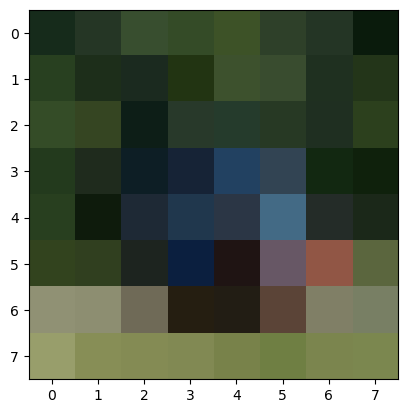

In [13]:
sz = 8
img_range = (1, 10)
rng = np.random.default_rng()
img_range = rng.integers(0, 10_000)
img_range = img_range, img_range + 9
plt.imshow(to_plottable(
    resize_image_nn(ds.train.images[img_range[0]:img_range[1]], ds.image_shape, sz)[5],
    # resize_image_bilinear(ds.train.images[1:10], ds.image_shape, 32)[5],
    ds.image_shape
))

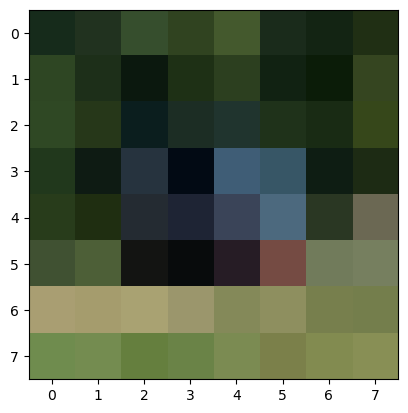

In [14]:
plt.imshow(to_plottable(
    resize_image_bilinear(ds.train.images[img_range[0]:img_range[1]], ds.image_shape, sz)[5],
    ds.image_shape
))

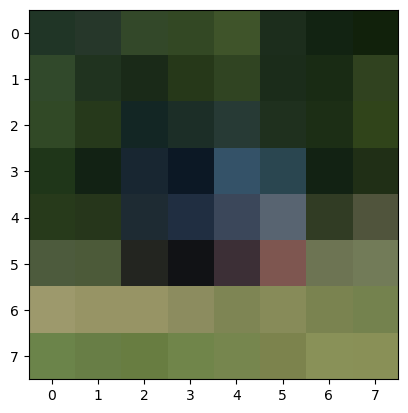

In [15]:
plt.imshow(to_plottable(
    resize_image_gaussian(ds.train.images[img_range[0]:img_range[1]], ds.image_shape, sz, sigma_scale=0.3)[5],
    ds.image_shape
))

In [16]:
%timeit resize_image_nn(ds.train.images, ds.image_shape, sz)

80.1 ms ± 1.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
%timeit resize_image_bilinear(ds.train.images, ds.image_shape, sz)

331 ms ± 7.59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Environment

In [22]:
%%time

seed = 8041990
ds = Dataset(seed, 'cifar', grayscale=False, lp_norm=None)

cifar LOADED images: (60000, 3072) (3, 32, 32) | targets: (60000,)
CPU times: user 1.05 s, sys: 1.16 s, total: 2.22 s
Wall time: 2.74 s


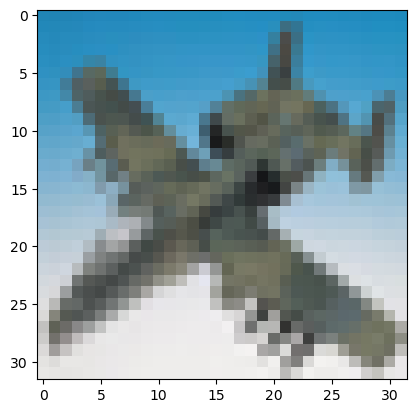

In [18]:
img = ds.train.images[14]
# plt.imshow(img.transpose(1, 2, 0))
plt.imshow(to_plottable(img, ds.image_shape))

In [484]:
def _get_pos_range(orig_chw_shape, obs_hw_shape):
    """Get an allowed range of the top left corner positions."""
    c, h, w = orig_chw_shape
    oh, ow = obs_hw_shape
    return np.array([
        [0, 0],
        [max(0, h - oh + 1), max(0, w - ow + 1)]
    ])

def _get_obs_shape(orig_chw_shape, obs_hw_shape):
    c, h, w = orig_chw_shape
    oh, ow = obs_hw_shape
    return c, oh, ow

@jit
def _get_obs(images, img_chw_shape, obs_chw_shape, poses):
    """Fill flatten obs with img patch (of size obs_window) from img at pos."""
    assert images.shape[0] == poses.shape[0]
    bsz = images.shape[0]
    _, h, w = img_chw_shape
    c, oh, ow = obs_chw_shape
    hw = h * w
    out_obs = np.empty((bsz, c * oh * ow), float)
    for img, pos, obs in zip(images, poses, out_obs):
        j = 0
        st = pos[0] * w + pos[1]
        for _ in range(c):
            t = st
            for _ in range(oh):
                obs[j:j+ow] = img[t:t+ow]
                j += ow
                t += w
            st += hw
    return out_obs

@jit
def _to_one_hot_pos(poses, pos_range, is_hidden):
    # NB: concatenated 2 one-hots = two-hot | one-hot if hidden
    max_h, max_w = pos_range[1]
    bsz = poses.shape[0]
    # first bit is for "position is hidden" (if thumbnail is returned)
    res = np.zeros((bsz, 1 + max_h + max_w), float)
    for r, (h, w), hid in zip(res, poses, is_hidden):
        if hid:
            r[0] = 1.0
            continue
        r[1 + h] = 1.0
        r[1 + max_h + w] = 1.0
    return res

@jit
def _from_one_hot_pos(poses, pos_range):
    max_h, max_w = pos_range[1]
    res = np.empty((poses.shape[0], 2), np.int32)
    for r, pos in zip(res, poses):
        if pos[0] > 0:
            # (-1, -1) denotes "hidden" position, i.e. showing thumbnail
            r[:] = -1
            continue
        _from_one_hot_pos_single_exact(pos[1:], max_h, r)
    return res



@jit
def _from_one_hot_pos_single_exact(pos, max_h, res):    
    i, t = 0, 0
    while t < 2:
        if pos[i] > 0:
            res[t] = i - t * (max_h)
            t += 1
            # it's correct for t = 0 -> 1, but for 1 -> 2 it is not used, so OK
            i = max_h - 1
        i += 1


print(ds.image_shape)
print(_get_pos_range((3, 10, 7), (10, 6)))

poses = np.array([[0, 0], [2, 1]], dtype=int)
pos_range = np.array([[0, 0], [3, 4]], dtype=int)
pos_visible = np.array([0, 0])
pos_hidden = ~pos_visible

print(_to_one_hot_pos(poses, pos_range, pos_visible))
print(_to_one_hot_pos(poses, pos_range, pos_hidden))

print(_from_one_hot_pos(_to_one_hot_pos(poses, pos_range, pos_visible).copy().astype(int), pos_range))
assert np.array_equal(
    _from_one_hot_pos(_to_one_hot_pos(poses, pos_range, pos_visible).copy().astype(int), pos_range),
    poses
)
assert np.all(_from_one_hot_pos(_to_one_hot_pos(poses, pos_range, pos_hidden).copy().astype(int), pos_range) == -1)

(3, 32, 32)
[[0 0]
 [1 2]]
[[0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0.]]
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]
[[0 0]
 [2 1]]


In [399]:
class ImageBuffer:
    def __init__(self, images, targets, *, img_chw_shape, obs_chw_shape, seed=None):
        self.rng = np.random.default_rng(seed)
        self.img_chw_shape = img_chw_shape
        self.obs_chw_shape = obs_chw_shape
        self.obs_hw_shape = obs_chw_shape[1:]
        self.images, self.targets = images, targets
        self.thumbnails = resize_image_nn(self.images, self.img_chw_shape, self.obs_hw_shape)
        self._size = len(self.targets)

    def _sample_ixs(self, n):
        return self.rng.integers(0, self._size, n)

    def sample(self, n):
        ixs = self._sample_ixs(n)
        return ixs, self.images[ixs], self.thumbnails[ixs], self.targets[ixs]

class PrefetchedImageBuffer(ImageBuffer):
    def __init__(
            self, images, targets, *, img_chw_shape, obs_chw_shape, prefetch_size, seed=None,
    ):
        super().__init__(
            images, targets, img_chw_shape=img_chw_shape, obs_chw_shape=obs_chw_shape, seed=seed
        )
        self._prefetch_size = prefetch_size
        self._i = prefetch_size
        self._ixs = np.empty(prefetch_size, dtype=int)
        self._img = np.empty((prefetch_size, *self.images.shape[1:]), dtype=self.images.dtype)
        self._th = np.empty((prefetch_size, *self.thumbnails.shape[1:]), dtype=self.images.dtype)
        self._tar = np.empty(prefetch_size, dtype=self.images.dtype)

    def sample(self, n):
        self._prefetch(n)
        i = self._i
        ixs = self._ixs[i:i+n]
        img = self._img[i:i+n]
        th = self._th[i:i+n]
        tar = self._tar[i:i+n]
        self._i += n
        return ixs, img, th, tar

    def _prefetch(self, n):
        if self._i + n <= self._prefetch_size:
            return

        # move left to the beginning
        i, left = self._i, self._prefetch_size - self._i
        
        self._ixs[:left] = self._ixs[i:]
        self._img[:left] = self._img[i:]
        self._th[:left] = self._th[i:]
        self._tar[:left] = self._tar[i:]
        
        self._ixs[left:] = self._sample_ixs(self._prefetch_size - left)
        ixs = self._ixs[left:]
        self._img[left:] = self.images[ixs]
        self._th[left:] = self.thumbnails[ixs]
        self._tar[left:] = self.targets[ixs]
        self._i = 0

img_buffer = ImageBuffer(ds.train.images, ds.train.targets, img_chw_shape=ds.image_shape, obs_chw_shape=_get_obs_shape(ds.image_shape, _ensure_2d(12)))
_ = img_buffer.sample(1)
pref_img_buffer = PrefetchedImageBuffer(
    ds.train.images, ds.train.targets, img_chw_shape=ds.image_shape, obs_chw_shape=_get_obs_shape(ds.image_shape, _ensure_2d(12)), prefetch_size=32
)
_ = pref_img_buffer.sample(1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


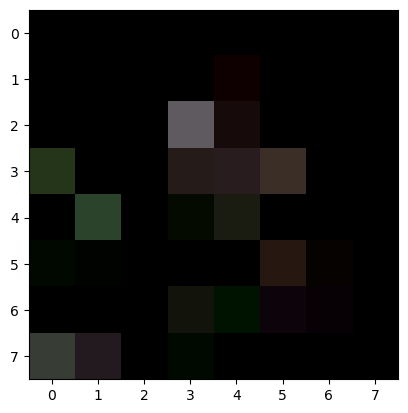

In [499]:
from gymnasium.vector.vector_env import VectorEnv

class ImageEnvironment(VectorEnv):
    def __init__(
            self, ds: Dataset, *, num_envs, obs_hw_shape=1, max_time_steps=3, seed=None,
            step_reward=0., answer_reward=(1.0, -1.0), 
            is_eval=False, img_buffer_fn=ImageBuffer
    ):
        super().__init__()
        self.n_classes = ds.n_classes
        self.max_time_steps = max_time_steps
        self.num_envs = self.bsz = num_envs
        # neg: penalty
        self.step_reward = step_reward
        # tuple (correct, incorrect)
        self.answer_reward = answer_reward
        
        self.img_chw_shape = ds.image_shape
        self.obs_hw_shape = _ensure_2d(obs_hw_shape)
        self.obs_chw_shape = _get_obs_shape(self.img_chw_shape, self.obs_hw_shape)
        self.pos_range = _get_pos_range(self.img_chw_shape, self.obs_hw_shape)

        # total obs vector: <is zoomed out + flatten position 2-hot> + <flatten obs image chw>
        self.obs_size = np.prod(self.obs_chw_shape)
        self.total_obs_size = 1 + self.pos_range[1].sum() + self.obs_size

        self.is_eval = is_eval
        data = ds.test if is_eval else ds.train
        # create buffers
        self.data = img_buffer_fn(
            data.images, data.targets, 
            img_chw_shape=self.img_chw_shape, obs_chw_shape=self.obs_chw_shape,
            seed=seed
        )

        self._step = None
        self._pos = None
        self._ixs = np.empty(self.bsz, dtype=int)
        self._img = np.empty((self.bsz, *self.data.images.shape[1:]), dtype=float)
        self._th = np.empty((self.bsz, *self.data.thumbnails.shape[1:]), dtype=float)
        self._tar = np.empty(self.bsz, dtype=int)
        self._done_mask = None
    
    def _sample_pos(self, n):
        return self.rng.integers(*self.pos_range, (n, 2))
    def _get_obs(self, img, pos):
        return _get_obs(img, self.img_chw_shape, self.obs_chw_shape, pos)

    def reset(self):
        self._step = np.zeros(self.bsz, dtype=int)
        self._ixs[:], self._img[:], self._th[:], self._tar[:] = self.data.sample(self.bsz)

        # since on the episode reset an initial obs is thumbnail and position
        # is not exposed (zero-empty two-hot pos), initial values could be any
        self._pos = np.zeros((self.bsz, 2), dtype=int)
        self._done_mask = np.zeros(self.bsz, dtype=bool)
        
        oh_pos = _to_one_hot_pos(self._pos, self.pos_range, is_hidden=self._done_mask)
        obs = self._th.copy()
        
        return (oh_pos, obs), {}

    @staticmethod
    def _split_what_action(action, reset_mask):
        a = action.copy()
        a[reset_mask] = -1
        # zoom_mask, move_mask, guess_mask
        return a == 0, a == 1, a == 2

    def step(self, action):
        # action: (BSZ, 4): what(zoom out|move|answer), n_classes, n_H_pos, n_W_pos
        assert action.shape == (self.bsz, 4)
        zma = action[..., 0]
        move_action = 

        # for resetting items last selected action is ignored (since it's done from the terminal/truncated state)
        reset_mask = self._done_mask
        n_reset = np.count_nonzero(reset_mask)

        self._step += 1
        if n_reset > 0:
            self._step[reset_mask] = 0
            self._ixs[reset_mask], self._img[reset_mask], self._th[reset_mask], self._tar[reset_mask] = self.data.sample(n_reset)

        # all three mask have resetting items excluded
        zoom_mask, move_mask, answer_mask = self._split_what_action(zma, reset_mask)

        # resetting do not interfere with both flags
        truncated = self._step >= self.max_time_steps
        terminated = answer_mask
        done_mask = np.logical_or(terminated, truncated)
        self._done_mask = done_mask
        n_done = np.count_nonzero(done_mask)
        ep_len_sum = 0 if n_done == 0 else self._step[done_mask].sum()

        # 1. Handle guessing
        #   fill with default step penalty
        reward = np.full(self.bsz, self.step_reward)
        #   fill asnwered with default incorrect ans reward
        reward[answer_mask] = self.answer_reward[1]
        #   fill correct answers
        correct_mask = np.logical_and(answer_mask, action[..., 1] == self._tar)
        reward[correct_mask] = self.answer_reward[0]
        n_correct = 0 if n_done == 0 else np.count_nonzero(correct_mask)
        #   fill resetting items if needed
        if n_reset > 0:
            reward[reset_mask] = 0.0

        # 2. Handle moving. NB: resetting items inherit old pos from prev episode,
        #    but it's ok since new pos should be chosen before being exposed to agent
        self._pos[move_mask] = action[..., 2:][move_mask]
        
        thumbnail_mask = np.logical_or(zoom_mask, reset_mask)
        obs_mask = np.logical_not(thumbnail_mask)
        
        oh_pos = _to_one_hot_pos(self._pos, self.pos_range, thumbnail_mask)
        obs = np.empty((self.bsz, self.obs_size), float)
        obs[thumbnail_mask] = self._th[thumbnail_mask]
        obs[obs_mask] = self._get_obs(self._img[obs_mask], self._pos[obs_mask])
        
        # careful: return only copied data
        return (
            (oh_pos, obs), 
            reward, terminated, truncated,
            dict(
                reset_mask = reset_mask,
                n_reset = n_reset,
                n_done = n_done,
                ep_len_sum = ep_len_sum,
                n_correct = n_correct,
            )
        )

env = ImageEnvironment(ds, num_envs=2, obs_hw_shape=8, seed=None)
o, info = env.reset()

plt.imshow(to_plottable(o[1][0], ds.image_shape))
o, r, terminated, truncated, info = env.step(np.array([
    [1, 0, 5, 10],
    [0, 10, 4, 6],
]))

In [298]:
o, r, terminated, truncated, info = env.step(np.array([
    [1, 0, 5, 10],
    [0, 10, 4, 6],
]))
info

{'n_reset': 0, 'n_done': 0, 'ep_len_sum': 0, 'n_correct': 0}

In [329]:
%%time
from hima.common.timer import timer

env = ImageEnvironment(
    ds, num_envs=64, obs_hw_shape=7, max_time_steps=20, seed=42,
    answer_reward=(1.0, -0.3), step_reward=-0.01,
    img_buffer_fn=partial(PrefetchedImageBuffer, prefetch_size=256),
)

state = None
o, info = env.reset()
n_steps, print_schedule = 30000, 5000
ret, ep_len_sum, n_eps, v_loss, pi_loss, acc = 0., 0., 0., 0., 0., 0.
rng = np.random.default_rng()

a = np.vstack([
    rng.integers(3, size=env.bsz),
    rng.integers(env.n_classes, size=env.bsz),
    rng.integers(env.pos_range[1][0], size=env.bsz),
    rng.integers(env.pos_range[1][1], size=env.bsz),
]).T
print(a.shape)

st = timer()
for i in range(1, n_steps+1):
    a = np.vstack([
        rng.integers(3, size=env.bsz),
        rng.integers(env.n_classes, size=env.bsz),
        rng.integers(env.pos_range[1][0], size=env.bsz),
        rng.integers(env.pos_range[1][1], size=env.bsz),
    ]).T
    o_next, r, terminated, truncated, info = env.step(a)
    
    ret += r.mean()
    ep_len_sum += info['ep_len_sum']
    acc += info['n_correct']
    n_eps += info['n_done']

    o = o_next
    
    if i % print_schedule == 0:
        ret /= print_schedule
        ep_len_sum /= n_eps
        acc /= n_eps / 100.0
        print(f'{i}: {acc:.2f} {ret:.3f}  |  {ep_len_sum:.1f}')
        ret, ep_len_sum, n_eps, v_loss, pi_loss, acc = 0., 0., 0., 0., 0., 0.

end = timer()
print(f'{n_steps * env.bsz / (end - st) / 1e+3:.2f} kfps')

(64, 4)
5000: 9.94 -0.048  |  3.0
10000: 10.08 -0.047  |  3.0
15000: 10.08 -0.047  |  3.0
20000: 10.21 -0.047  |  3.0
25000: 10.07 -0.047  |  3.0
30000: 10.09 -0.047  |  3.0
545.90 kfps
CPU times: user 3.28 s, sys: 367 ms, total: 3.64 s
Wall time: 3.85 s


In [312]:
%timeit env.reset()

61.2 µs ± 1.27 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [153]:
%timeit env._get_obs(env._img, env._pos)

8.41 µs ± 98.4 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


## RL Agent

In [410]:
%%time

seed = 8041990
ds = Dataset(seed, 'mnist', grayscale=True, lp_norm=0)

mnist LOADED images: (70000, 784) (1, 28, 28) | targets: (70000,)
CPU times: user 366 ms, sys: 250 ms, total: 616 ms
Wall time: 778 ms


In [424]:
from enum import Enum, auto

def _get_seq_layer(prev_layer, layers, out_logits=False):
    if len(layers) == 0:
        return prev_layer, None
    encoder = []
    for layer in layers:
        encoder.extend((
            nn.Linear(prev_layer, layer, dtype=float),
            nn.SiLU()
        ))
        prev_layer = layer
    if out_logits:
        encoder.pop()
    encoder = nn.Sequential(*encoder)
    print(encoder)
    return prev_layer, encoder

def _concat_obs_parts(obs_parts):
    obs = [o.reshape(o.shape[0], -1) for o in obs_parts]
    obs = np.hstack(obs, dtype=float)
    return obs

def _get_numpy_action(res):
    # return np.vstack([
    #     res['a_zma'].numpy(),
    #     res['a_class'].numpy(),
    #     res['a_row'].numpy(), res['a_col'].numpy()
    # ]).T
    return np.vstack([
        res['a_zma'].numpy(),
        res['a_class'].numpy(),
        res['a_row'].numpy(), res['a_col'].numpy()
    ]).T

def _reset_state(state, reset_mask):
    # TODO: use torch.where + init_state fixed random vector
    not_done = np.logical_not(reset_mask)
    h, c = state
    not_done = torch.from_numpy(not_done).reshape(1, -1, 1)
    h = h * not_done
    c = c * not_done
    return h, c

def _normalize_entropy(h, size):
    return h / torch.log(h.new([size]))
    
def _get_entropy(p, dim=-1, keepdim=False, normalize=False):
    single_val = p.shape[dim] == 1
    if normalize and not single_val:
        p = p / (p.sum(-1, keepdim=True) + 1e-6)

    def _entr(p):
        return -torch.where(p > 0, p * p.log(), p.new([0.0])).sum(dim=dim, keepdim=keepdim)

    H = _entr(p) if not single_val else _entr(p) + _entr(1.0 - p)
    n = max(2, p.shape[dim])
    return H / torch.log(H.new([n]))


class RlProcessingType(Enum):
    LSTM = 1
    SUM_ATTENTION = auto()
    SE = auto()


class RlClassifier(nn.Module):
    layer_dims: list[int]

    _lr_epoch_step: int
    _lr_epoch_steps: int

    def __init__(
            self,
            obs_size: int,
            encoder: list[int],
            hid_size: int,
            skip_connection: bool,
            body: list[int],
            pi_heads: tuple[int],
            learning_rate: float,
            gamma: float,
            batch_size: int = 64,
            val_loss_scale: float = 0.25,
            ent_scales: tuple[float] = (1.0, 1.0, 1.0, 1.0),
            ent_loss_scale: float = 0.001,
            seed: int = None,
            min_lr_scale: float = 20.0,
            processing_type: ProcessingType = RlProcessingType.LSTM,
            se_config: dict = None, se_pooling: int = 1
    ):
        super().__init__()
        self.rng = np.random.default_rng(seed)
        self.lr = learning_rate
        self.n_classes = pi_heads[1]
        self.gamma = gamma
        self.val_loss_scale = val_loss_scale
        self.ent_loss_scale = ent_loss_scale
        self.ent_scales = ent_scales
        self._pi_heads = pi_heads
        self._pi_head_shifts = np.cumsum(pi_heads)
        
        enc_size, self.encoder = _get_seq_layer(obs_size, encoder)
        
        self.rnn = nn.LSTM(enc_size, hid_size, dtype=float)
        print(self.rnn)

        self.skip_connection = None
        body_input_size = hid_size
        if skip_connection and len(encoder) > 0:
            body_input_size, self.skip_conn = _get_seq_layer(hid_size, [enc_size])
            
        pi_enc_size, self.pi_body = _get_seq_layer(body_input_size, body)
        val_enc_size, self.val_body = _get_seq_layer(body_input_size, body)
        
        _, self.pi_head = _get_seq_layer(pi_enc_size, [sum(pi_heads)], out_logits=True)
        _, self.val_head = _get_seq_layer(val_enc_size, [1], out_logits=True)

        self.body_skip = pi_enc_size == val_enc_size == body_input_size and len(body) > 0
        
        self.optim = optim.AdamW(self.parameters(), lr=self.lr)
        self.mse = nn.MSELoss()

        self.batch_size = batch_size
        self._loss = 0.
        self._last_loss = 0.
        self._batch_cnt = 0

        self._min_lr = self.lr / min_lr_scale
        self._lr_epoch = lambda lr: int(7.0 / lr)
        self._lr_scaler = lambda _: 0.8
        self.lr_scheduler = optim.lr_scheduler.MultiplicativeLR(
            self.optim, lr_lambda=self._lr_scaler,
        )
        self._lr_epoch_step = 0
        self._lr_epoch_steps = self._lr_epoch(self.lr)

    def set_se_learn(self, learn):
        self.se_learn = learn

    def _encode(self, x, state):
        x = _concat_obs_parts(x)
        x = torch.from_numpy(x)
        
        z = self.encoder(x) if self.encoder is not None else x

        # LSTM require additional [seq len] first dim
        h = torch.unsqueeze(z, 0)
        _, state = self.rnn(h, state)
        # eliminate [seq len] dim
        h = torch.squeeze(state[0])

        u = z + self.skip_conn(h) if self.skip_conn is not None else h
        return u, state

    def _split_pi(self, pi):
        mv, cl, r, c = self._pi_head_shifts
        return (
            pi[..., :mv], pi[..., mv:cl],
            pi[..., cl:r], pi[..., r:c],
        )

    def _predict(self, x, state, greedy=False):
        z, state = self._encode(x, state)

        u = self.pi_body(z) if self.pi_body is not None else z
        if self.body_skip:
            u = u + z
        pi = self.pi_head(u)

        v = self.val_body(z) if self.val_body is not None else z
        if self.body_skip:
            v = v + z
        val = self.val_head(v).squeeze()

        # zma == zoom out|move|answer
        zma, cl, row, col = self._split_pi(pi)
        zma_distr = Categorical(logits=zma)
        class_distr = Categorical(logits=cl)
        row_distr = Categorical(logits=row)
        col_distr = Categorical(logits=col)

        a_zma = torch.argmax(zma, -1) if greedy else zma_distr.sample()
        a_cl = torch.argmax(cl, -1) if greedy else class_distr.sample()
        a_row = torch.argmax(row, -1) if greedy else row_distr.sample()
        a_col = torch.argmax(col, -1) if greedy else col_distr.sample()


        result = dict(
            state=state,
            val=val,
            a_zma=a_zma, a_class=a_cl,
            a_row=a_row, a_col=a_col,

            zma_log_prob=zma_distr.log_prob(a_zma),
            class_log_prob=class_distr.log_prob(a_cl),
            row_log_prob=row_distr.log_prob(a_row),
            col_log_prob=col_distr.log_prob(a_col),
        
            zma_entropy=zma_distr.entropy(),
            class_entropy=class_distr.entropy(),
            row_entropy=row_distr.entropy(),
            col_entropy=col_distr.entropy(),
        )
            
        return result

    def _evaluate(self, x, state):
        z, state = self._encode(x, state)
        
        u = self.val_body(z) if self.val_body is not None else z
        if self.body_skip:
            u = u + z

        val = self.val_head(u).squeeze()
        return val, state

    def forward(self, x, state=None):
        return self._predict(x, state)

    def predict(self, x, state=None, train=True, greedy=False):
        if train:
            return self._predict(x, state)
        
        with torch.no_grad():
            return self._predict(x, state, greedy=greedy)

    def learn(self, obs, r, a, obs_next, done, reset_mask):
        batch_size = len(done)
        gamma = self.gamma
        done = torch.from_numpy(done).float()
        # done -> reset transition samples are disabled
        enabled = torch.logical_not(torch.from_numpy(reset_mask))
        r = torch.from_numpy(r)
        state = a['state']
        zma = a['a_zma']
        v_s = a['val']
    
        move_mask = zma == 1
        ans_mask = zma == 2        
        log_pi = (
            a['zma_log_prob'] 
            + torch.where(move_mask, a['row_log_prob'] + a['col_log_prob'], 0.0)
            + torch.where(ans_mask, a['class_log_prob'], 0.0)
        )
        log_pi = log_pi[enabled]

        with torch.no_grad():
            v_sn, _ = self._evaluate(obs_next, state)
            td_tar = r + gamma * (1 - done) * v_sn

        td_err = td_tar - v_s
        td_err = td_err[enabled]
        
        v_loss = torch.mean(torch.pow(td_err, 2))
        pi_loss = -torch.mean(log_pi * td_err.detach())
        ent_loss = -sum(
            scale * _normalize_entropy(torch.mean(entropy[enabled]), size)
            for scale, size, entropy in zip(
                self.ent_scales, self._pi_heads, [
                    a['zma_entropy'], a['class_entropy'],
                    a['row_entropy'], a['col_entropy'],
                ]
            )
        )
        loss = pi_loss + self.val_loss_scale * v_loss + self.ent_loss_scale * ent_loss

        ret_loss = pi_loss.detach().item(), v_loss.detach().item()

        self._batch_cnt += batch_size
        self._loss += loss
        
        if self._batch_cnt >= self.batch_size:
            self._loss /= round(self._batch_cnt / batch_size)
            self._last_loss += 0.05 * (self._loss.detach().item() - self._last_loss)
            self._loss.backward()
            self.optim.step()
            self.optim.zero_grad()
            
            self._batch_cnt = 0
            self._loss = 0.
            
            h_st, c_st = state
            a['state'] = h_st.detach(), c_st.detach()

            self._lr_epoch_step += 1
            if self.lr > self._min_lr and self._lr_epoch_step >= self._lr_epoch_steps:
                self.lr *= self._lr_scaler(True)
                self._lr_epoch_step = 0
                self._lr_epoch_steps = self._lr_epoch(self.lr)
                # print(f'New LR: {self.lr:.5f} for {self._lr_epoch_steps} steps')
                self.lr_scheduler.step()
        
        return ret_loss

env = ImageEnvironment(
    ds, num_envs=2, obs_hw_shape=7, max_time_steps=20, seed=42,
    answer_reward=(1.0, -0.3), step_reward=-0.01,
    img_buffer_fn=partial(PrefetchedImageBuffer, prefetch_size=256),
)
o, info = env.reset()
o, r, terminated, truncated, info = env.step(np.array([
    [1, 0, 5, 10],
    [0, 10, 4, 6],
]))

agent = RlClassifier(
    obs_size=env.total_obs_size,
    encoder=[32], hid_size=64, skip_connection=True, body=[32],
    pi_heads=(
        3, env.n_classes, *env.pos_range[1]
    ),
    learning_rate=0.05,
    gamma=0.95,
    batch_size=64,
    seed=seed,
)
_ = agent.predict(o)

Sequential(
  (0): Linear(in_features=94, out_features=32, bias=True)
  (1): SiLU()
)
LSTM(32, 64)
Sequential(
  (0): Linear(in_features=64, out_features=32, bias=True)
  (1): SiLU()
)
Sequential(
  (0): Linear(in_features=32, out_features=32, bias=True)
  (1): SiLU()
)
Sequential(
  (0): Linear(in_features=32, out_features=32, bias=True)
  (1): SiLU()
)
Sequential(
  (0): Linear(in_features=32, out_features=57, bias=True)
)
Sequential(
  (0): Linear(in_features=32, out_features=1, bias=True)
)


In [425]:
from collections import defaultdict

def _append_results(agg_results, res):
    for k in res:
        agg_results[k].append(res[k])

def _to_readable_num(x):
    suffixes = ['', 'k', 'M', 'B']
    i = 0
    while abs(x) > 1000.0 or i >= len(suffixes):
        x = x / 1000.0
        i += 1

    return x, suffixes[i]
        

def run_epoch(env, agent, *, full_state, epoch, n_steps, total_steps, is_train=True, is_greedy=False):
    o, state = full_state
    greedy = (not is_train) and is_greedy
    ret, ep_len_sum, n_eps, v_loss, pi_loss, acc = 0., 0., 0., 0., 0., 0.
    
    for i in range(1, n_steps+1):
        a_agent = agent.predict(o, state, train=is_train, greedy=greedy)
        a_env = _get_numpy_action(a_agent)
        o_next, r, terminated, truncated, info = env.step(a_env)
        reset_mask = info['reset_mask']
        if is_train:
            loss = agent.learn(o, r, a_agent, o_next, terminated, reset_mask)
        
        ret += r.mean()
        ep_len_sum += info['ep_len_sum']
        acc += info['n_correct']
        n_eps += info['n_done']
        if is_train:
            pi_loss += loss[0]
            v_loss += loss[1]
    
        o = o_next
        state = _reset_state(a_agent['state'], reset_mask)

    if is_train:
        pi_loss /= n_steps
        v_loss /= n_steps
    
    ret /= n_steps
    ep_len_sum /= n_eps
    acc /= n_eps / 100.0
    
    if is_train:
        total_steps += n_steps

        tot, sfx = _to_readable_num(total_steps * env.num_envs)
        print(f'{epoch} [{tot:.0f}{sfx}]: {acc:.2f} {ret:.3f}  |  {ep_len_sum:.1f}  {n_eps}  |  {pi_loss:.4f}   {v_loss:.4f}')
        return (
            total_steps, (o, state),
            dict(acc=acc, ret=ret, ep_len=ep_len, pi_loss=pi_loss, v_loss=v_loss)
        )
    
    print(f'==>  {acc:.2f} {ret:.3f}  |  {ep_len_sum:.1f}  {n_eps}')
    return (o, state), dict(acc=acc, ret=ret, ep_len=ep_len)
    

def run_rl_test(env, test_env, agent, n_epochs, n_steps, eval_configs):
    train_results = defaultdict(list)
    test_results = defaultdict(list)

    total_steps = 0
    full_state = (env.reset()[0], None)
    test_full_state = (test_env.reset()[0], None)

    for epoch in range(1, n_epochs+1):
        if n_steps > 0:
            total_steps, full_state, res = run_epoch(
                env, agent, full_state=full_state, 
                epoch=epoch, n_steps=n_steps, total_steps=total_steps, 
                is_train=True, is_greedy=False,
            )
            _append_results(train_results, res)

        for eval_config in eval_configs:
            test_full_state, res = run_epoch(
                test_env, agent, full_state=test_full_state, 
                epoch=epoch, total_steps=total_steps, 
                is_train=False, **eval_config
            )
            _append_results(test_results, res)

In [426]:
%%time
# 40000: 88.47 0.313  |  2.7  |  -0.2380   0.0401

env_config = dict(
    ds=ds, num_envs=8, obs_hw_shape=5, max_time_steps=20, seed=None,
    answer_reward=(1.0, -0.5), step_reward=0.0,
    # img_buffer_fn=partial(PrefetchedImageBuffer, prefetch_size=256),
)
env = ImageEnvironment(**env_config)
test_env = ImageEnvironment(is_eval=True, **env_config)

agent = RlClassifier(
    obs_size=env.total_obs_size,
    encoder=[32], hid_size=32, skip_connection=True, body=[32],
    pi_heads=(3, env.n_classes, *env.pos_range[1]),
    learning_rate=0.004,
    gamma=0.99,
    batch_size=256,
    # batch_size=64,
    val_loss_scale=0.25, ent_loss_scale=0.1,
    ent_scales=(1.0, 0.2, 0.5, 0.5),
    seed=seed, min_lr_scale=10.0
)

run_rl_test(env, test_env, agent, n_epochs=5, n_steps=4_000,
    eval_configs=[
        dict(n_steps=1_000, is_greedy=True),
        dict(n_steps=1_000, is_greedy=False),
    ]
)

Sequential(
  (0): Linear(in_features=74, out_features=32, bias=True)
  (1): SiLU()
)
LSTM(32, 32)
Sequential(
  (0): Linear(in_features=32, out_features=32, bias=True)
  (1): SiLU()
)
Sequential(
  (0): Linear(in_features=32, out_features=32, bias=True)
  (1): SiLU()
)
Sequential(
  (0): Linear(in_features=32, out_features=32, bias=True)
  (1): SiLU()
)
Sequential(
  (0): Linear(in_features=32, out_features=61, bias=True)
)
Sequential(
  (0): Linear(in_features=32, out_features=1, bias=True)
)
1 [32k]: 14.75 -0.064  |  3.3  7432.0  |  -0.0347   0.0828
==>  17.75 -0.018  |  6.4  1076.0
==>  24.35 -0.032  |  3.1  1955.0
2 [64k]: 33.14 -0.000  |  3.4  7330.0  |  -0.0912   0.1296
==>  15.46 0.007  |  15.4  485.0
==>  37.03 0.013  |  3.8  1685.0
3 [96k]: 42.84 0.033  |  3.4  7220.0  |  -0.1039   0.1426
==>  28.08 0.011  |  9.2  780.0
==>  46.32 0.054  |  2.7  2202.0
4 [128k]: 46.37 0.048  |  3.1  7733.0  |  -0.1075   0.1566
==>  28.51 0.013  |  10.0  719.0
==>  48.99 0.065  |  2.6  2225.0


In [428]:
%%time
# 40000: 88.47 0.313  |  2.7  |  -0.2380   0.0401

env_config = dict(
    ds=ds, num_envs=64, obs_hw_shape=5, max_time_steps=20, seed=None,
    answer_reward=(1.0, -0.5), step_reward=0.0,
    img_buffer_fn=partial(PrefetchedImageBuffer, prefetch_size=256),
)
env = ImageEnvironment(**env_config)
test_env = ImageEnvironment(is_eval=True, **env_config)

agent = RlClassifier(
    obs_size=env.total_obs_size,
    encoder=[32], hid_size=32, skip_connection=True, body=[32],
    pi_heads=(3, env.n_classes, *env.pos_range[1]),
    learning_rate=0.004,
    gamma=0.99,
    batch_size=256,
    # batch_size=64,
    val_loss_scale=0.25, ent_loss_scale=0.1,
    ent_scales=(1.0, 0.2, 0.5, 0.5),
    seed=seed, min_lr_scale=10.0
)

run_rl_test(env, test_env, agent, n_epochs=10, n_steps=10_000, 
    eval_configs=[
        dict(n_steps=1_000, is_greedy=True),
        dict(n_steps=1_000, is_greedy=False),
    ]
)

Sequential(
  (0): Linear(in_features=74, out_features=32, bias=True)
  (1): SiLU()
)
LSTM(32, 32)
Sequential(
  (0): Linear(in_features=32, out_features=32, bias=True)
  (1): SiLU()
)
Sequential(
  (0): Linear(in_features=32, out_features=32, bias=True)
  (1): SiLU()
)
Sequential(
  (0): Linear(in_features=32, out_features=32, bias=True)
  (1): SiLU()
)
Sequential(
  (0): Linear(in_features=32, out_features=61, bias=True)
)
Sequential(
  (0): Linear(in_features=32, out_features=1, bias=True)
)
1 [640k]: 39.10 0.025  |  4.5  116226.0  |  -0.0689   0.1654
==>  51.95 0.075  |  3.7  13660.0
==>  53.16 0.088  |  2.6  17850.0
2 [1M]: 55.80 0.083  |  3.3  148337.0  |  -0.0794   0.1446
==>  51.42 0.059  |  5.6  9722.0
==>  57.11 0.093  |  3.1  15791.0
3 [2M]: 59.07 0.104  |  2.9  165581.0  |  -0.0703   0.1611
==>  57.03 0.087  |  4.0  12841.0
==>  60.53 0.121  |  2.4  18610.0
4 [3M]: 60.64 0.113  |  2.7  172034.0  |  -0.0705   0.1661
==>  52.84 0.062  |  5.5  9869.0
==>  61.02 0.110  |  2.9  

In [429]:
%%time
# 40000: 88.47 0.313  |  2.7  |  -0.2380   0.0401

env_config = dict(
    ds=ds, num_envs=64, obs_hw_shape=5, max_time_steps=20, seed=None,
    answer_reward=(1.0, 0.0), step_reward=0.0,
    img_buffer_fn=partial(PrefetchedImageBuffer, prefetch_size=256),
)
env = ImageEnvironment(**env_config)
test_env = ImageEnvironment(is_eval=True, **env_config)

agent = RlClassifier(
    obs_size=env.total_obs_size,
    encoder=[32], hid_size=32, skip_connection=True, body=[32],
    pi_heads=(3, env.n_classes, *env.pos_range[1]),
    learning_rate=0.004,
    gamma=0.97,
    batch_size=256,
    # batch_size=64,
    val_loss_scale=0.25, ent_loss_scale=0.1,
    ent_scales=(1.0, 0.2, 0.5, 0.5),
    seed=seed, min_lr_scale=10.0
)

run_rl_test(env, test_env, agent, n_epochs=10, n_steps=10_000, 
    eval_configs=[
        dict(n_steps=1_000, is_greedy=True),
        dict(n_steps=1_000, is_greedy=False),
    ]
)

Sequential(
  (0): Linear(in_features=74, out_features=32, bias=True)
  (1): SiLU()
)
LSTM(32, 32)
Sequential(
  (0): Linear(in_features=32, out_features=32, bias=True)
  (1): SiLU()
)
Sequential(
  (0): Linear(in_features=32, out_features=32, bias=True)
  (1): SiLU()
)
Sequential(
  (0): Linear(in_features=32, out_features=32, bias=True)
  (1): SiLU()
)
Sequential(
  (0): Linear(in_features=32, out_features=61, bias=True)
)
Sequential(
  (0): Linear(in_features=32, out_features=1, bias=True)
)
1 [640k]: 52.07 0.153  |  2.4  188272.0  |  -0.0659   0.0881
==>  56.30 0.125  |  3.5  14246.0
==>  59.44 0.180  |  2.3  19414.0
2 [1M]: 60.05 0.182  |  2.3  194039.0  |  -0.0539   0.0880
==>  56.58 0.144  |  2.9  16243.0
==>  61.39 0.184  |  2.3  19213.0
3 [2M]: 62.05 0.186  |  2.3  192302.0  |  -0.0488   0.0850
==>  62.69 0.230  |  1.7  23531.0
==>  63.05 0.198  |  2.2  20142.0
4 [3M]: 62.94 0.190  |  2.3  193626.0  |  -0.0500   0.0847
==>  61.75 0.187  |  2.3  19334.0
==>  63.13 0.192  |  2.3

In [402]:
%%time
# 40000: 88.47 0.313  |  2.7  |  -0.2380   0.0401

env_config = dict(
    ds=ds, num_envs=64, obs_hw_shape=7, max_time_steps=20, seed=None,
    answer_reward=(1.0, -0.5), step_reward=0.0,
    img_buffer_fn=partial(PrefetchedImageBuffer, prefetch_size=256),
)
env = ImageEnvironment(**env_config)
test_env = ImageEnvironment(is_eval=True, **env_config)

agent = RlClassifier(
    obs_size=env.total_obs_size,
    encoder=[64], hid_size=64, skip_connection=True, body=[64],
    pi_heads=(3, env.n_classes, *env.pos_range[1]),
    learning_rate=0.004,
    gamma=0.99,
    batch_size=256,
    # batch_size=64,
    val_loss_scale=0.25, ent_loss_scale=0.1,
    ent_scales=(1.0, 0.2, 0.5, 0.5),
    seed=seed, min_lr_scale=10.0
)

run_rl_test(env, test_env, agent, n_epochs=10, n_steps=10_000, 
    eval_configs=[
        dict(n_steps=1_000, is_greedy=True),
        dict(n_steps=1_000, is_greedy=False),
    ]
)

Sequential(
  (0): Linear(in_features=94, out_features=64, bias=True)
  (1): SiLU()
)
LSTM(64, 64)
Sequential(
  (0): Linear(in_features=64, out_features=64, bias=True)
  (1): SiLU()
)
Sequential(
  (0): Linear(in_features=64, out_features=64, bias=True)
  (1): SiLU()
)
Sequential(
  (0): Linear(in_features=64, out_features=64, bias=True)
  (1): SiLU()
)
Sequential(
  (0): Linear(in_features=64, out_features=57, bias=True)
)
Sequential(
  (0): Linear(in_features=64, out_features=1, bias=True)
)
1 [640k]: 51.23 0.056  |  4.7  113026.0  |  -0.0784   1.7090
==>  39.21 0.029  |  11.4  5113.0
==>  54.97 0.050  |  7.9  7157.0
2 [1M]: 56.64 0.055  |  7.7  73456.0  |  -0.0576   0.0355
==>  46.37 0.039  |  9.9  5874.0
==>  57.91 0.060  |  7.2  7767.0
3 [2M]: 66.24 0.098  |  4.8  111324.0  |  -0.0688   0.0633
==>  64.26 0.088  |  5.6  9696.0
==>  69.90 0.121  |  4.0  12868.0
4 [3M]: 72.45 0.148  |  3.2  152967.0  |  -0.0681   0.0909
==>  71.30 0.138  |  3.6  13873.0
==>  74.75 0.194  |  2.3  195

In [430]:
%%time
# 40000: 88.47 0.313  |  2.7  |  -0.2380   0.0401

env_config = dict(
    ds=ds, num_envs=64, obs_hw_shape=7, max_time_steps=20, seed=None,
    answer_reward=(1.0, 0.0), step_reward=0.0,
    img_buffer_fn=partial(PrefetchedImageBuffer, prefetch_size=256),
)
env = ImageEnvironment(**env_config)
test_env = ImageEnvironment(is_eval=True, **env_config)

agent = RlClassifier(
    obs_size=env.total_obs_size,
    encoder=[64], hid_size=64, skip_connection=True, body=[64],
    pi_heads=(3, env.n_classes, *env.pos_range[1]),
    learning_rate=0.004,
    gamma=0.97,
    batch_size=256,
    # batch_size=64,
    val_loss_scale=0.25, ent_loss_scale=0.1,
    ent_scales=(1.0, 0.2, 0.5, 0.5),
    seed=seed, min_lr_scale=10.0
)

run_rl_test(env, test_env, agent, n_epochs=10, n_steps=10_000, 
    eval_configs=[
        dict(n_steps=1_000, is_greedy=True),
        dict(n_steps=1_000, is_greedy=False),
    ]
)

Sequential(
  (0): Linear(in_features=94, out_features=64, bias=True)
  (1): SiLU()
)
LSTM(64, 64)
Sequential(
  (0): Linear(in_features=64, out_features=64, bias=True)
  (1): SiLU()
)
Sequential(
  (0): Linear(in_features=64, out_features=64, bias=True)
  (1): SiLU()
)
Sequential(
  (0): Linear(in_features=64, out_features=64, bias=True)
  (1): SiLU()
)
Sequential(
  (0): Linear(in_features=64, out_features=57, bias=True)
)
Sequential(
  (0): Linear(in_features=64, out_features=1, bias=True)
)
1 [640k]: 70.86 0.221  |  2.2  199778.0  |  -0.0642   0.0734
==>  66.10 0.105  |  5.3  10145.0
==>  79.16 0.248  |  2.2  20075.0
2 [1M]: 80.26 0.254  |  2.2  202652.0  |  -0.0644   0.0611
==>  79.92 0.256  |  2.1  20486.0
==>  81.48 0.264  |  2.1  20732.0
3 [2M]: 82.13 0.255  |  2.2  198737.0  |  -0.0657   0.0551
==>  80.90 0.241  |  2.3  19082.0
==>  82.62 0.249  |  2.3  19300.0
4 [3M]: 83.33 0.254  |  2.3  195284.0  |  -0.0599   0.0509
==>  78.02 0.187  |  3.2  15303.0
==>  82.76 0.241  |  2.4

## Experiments

### RL env cifar GRAYSCALE

In [431]:
%%time

seed = 8041990
ds = Dataset(seed, 'cifar', grayscale=True, lp_norm=0)

cifar LOADED images: (60000, 1024) (1, 32, 32) | targets: (60000,)
CPU times: user 400 ms, sys: 268 ms, total: 668 ms
Wall time: 797 ms


In [432]:
%%time
# 500000: 54.44 0.058  |  6.6  |  -0.1429   0.0553

env_config = dict(
    ds=ds, num_envs=64, obs_hw_shape=11, max_time_steps=20, seed=None,
    answer_reward=(1.0, 0.0), step_reward=0.0,
    img_buffer_fn=partial(PrefetchedImageBuffer, prefetch_size=256),
)
env = ImageEnvironment(**env_config)
test_env = ImageEnvironment(is_eval=True, **env_config)

agent = RlClassifier(
    obs_size=env.total_obs_size,
    encoder=[64], hid_size=128, skip_connection=True, body=[64],
    pi_heads=(3, env.n_classes, *env.pos_range[1]),
    learning_rate=0.001,
    gamma=0.97,
    batch_size=256,
    # batch_size=64,
    val_loss_scale=0.25, ent_loss_scale=0.1,
    ent_scales=(1.0, 0.2, 0.5, 0.5),
    seed=seed, min_lr_scale=10.0
)

run_rl_test(env, test_env, agent, n_epochs=25, n_steps=20_000, 
    eval_configs=[
        dict(n_steps=2_000, is_greedy=True),
        dict(n_steps=2_000, is_greedy=False),
    ]
)

Sequential(
  (0): Linear(in_features=166, out_features=64, bias=True)
  (1): SiLU()
)
LSTM(64, 128)
Sequential(
  (0): Linear(in_features=128, out_features=64, bias=True)
  (1): SiLU()
)
Sequential(
  (0): Linear(in_features=64, out_features=64, bias=True)
  (1): SiLU()
)
Sequential(
  (0): Linear(in_features=64, out_features=64, bias=True)
  (1): SiLU()
)
Sequential(
  (0): Linear(in_features=64, out_features=57, bias=True)
)
Sequential(
  (0): Linear(in_features=64, out_features=1, bias=True)
)
1 [1M]: 27.46 0.075  |  2.6  350737.0  |  -0.0392   0.0715
==>  31.41 0.112  |  1.8  45533.0
==>  31.21 0.090  |  2.5  37096.0
2 [3M]: 33.92 0.095  |  2.6  359342.0  |  -0.0341   0.0815
==>  32.99 0.095  |  2.5  37019.0
==>  33.62 0.096  |  2.5  36381.0
3 [4M]: 36.51 0.101  |  2.6  353343.0  |  -0.0301   0.0817
==>  32.88 0.065  |  4.1  25288.0
==>  35.24 0.096  |  2.7  34717.0


KeyboardInterrupt: 

### RL env cifar RGB

In [433]:
%%time

seed = 8041990
ds = Dataset(seed, 'cifar', grayscale=False, lp_norm=0)

cifar LOADED images: (60000, 3072) (3, 32, 32) | targets: (60000,)
CPU times: user 1.2 s, sys: 1.22 s, total: 2.42 s
Wall time: 3.16 s


In [434]:
%%time
# 50 [1000000]: 67.40 0.095  |  6.2  206465.0  |  -0.1691   0.0279
# ==>  40.37 0.028  |  7.0  18206.0

env_config = dict(
    ds=ds, num_envs=64, obs_hw_shape=5, max_time_steps=20, seed=None,
    answer_reward=(1.0, 0.0), step_reward=0.0,
    img_buffer_fn=partial(PrefetchedImageBuffer, prefetch_size=256),
)
env = ImageEnvironment(**env_config)
test_env = ImageEnvironment(is_eval=True, **env_config)

agent = RlClassifier(
    obs_size=env.total_obs_size,
    encoder=[32], hid_size=64, skip_connection=True, body=[32],
    pi_heads=(3, env.n_classes, *env.pos_range[1]),
    learning_rate=0.001,
    gamma=0.99,
    batch_size=256,
    val_loss_scale=0.25, ent_loss_scale=0.1,
    ent_scales=(1.0, 0.2, 0.5, 0.5),
    seed=seed, min_lr_scale=10.0
)

run_rl_test(env, test_env, agent, n_epochs=80, n_steps=25_000,
    eval_configs=[
        dict(n_steps=2_000, is_greedy=True),
        dict(n_steps=2_000, is_greedy=False),
    ]
)

Sequential(
  (0): Linear(in_features=132, out_features=32, bias=True)
  (1): SiLU()
)
LSTM(32, 64)
Sequential(
  (0): Linear(in_features=64, out_features=32, bias=True)
  (1): SiLU()
)
Sequential(
  (0): Linear(in_features=32, out_features=32, bias=True)
  (1): SiLU()
)
Sequential(
  (0): Linear(in_features=32, out_features=32, bias=True)
  (1): SiLU()
)
Sequential(
  (0): Linear(in_features=32, out_features=69, bias=True)
)
Sequential(
  (0): Linear(in_features=32, out_features=1, bias=True)
)
1 [2M]: 28.82 0.073  |  2.9  405841.0  |  -0.0421   0.0658
==>  31.93 0.055  |  4.8  22156.0
==>  33.69 0.089  |  2.8  33998.0
2 [3M]: 36.08 0.094  |  2.8  417924.0  |  -0.0375   0.0761
==>  30.62 0.043  |  6.0  18150.0
==>  36.76 0.096  |  2.9  33256.0
3 [5M]: 38.63 0.100  |  2.9  414356.0  |  -0.0289   0.0766
==>  34.57 0.057  |  5.0  21112.0
==>  38.32 0.100  |  2.8  33553.0
4 [6M]: 40.16 0.105  |  2.8  416835.0  |  -0.0272   0.0780
==>  33.03 0.044  |  6.5  16932.0
==>  39.34 0.101  |  2.9 

In [435]:
run_rl_test(env, test_env, agent, n_epochs=1, n_steps=0, 
    eval_configs=[
        dict(n_steps=5_000, is_greedy=True),
        dict(n_steps=5_000, is_greedy=False),
    ]
)

==>  38.99 0.060  |  5.5  49340.0
==>  43.88 0.111  |  2.9  81274.0


In [436]:
%%time
# 50 [1000000]: 67.40 0.095  |  6.2  206465.0  |  -0.1691   0.0279
# ==>  40.37 0.028  |  7.0  18206.0

env_config = dict(
    ds=ds, num_envs=64, obs_hw_shape=7, max_time_steps=20, seed=None,
    answer_reward=(1.0, 0.0), step_reward=0.0,
    img_buffer_fn=partial(PrefetchedImageBuffer, prefetch_size=256),
)
env = ImageEnvironment(**env_config)
test_env = ImageEnvironment(is_eval=True, **env_config)

agent = RlClassifier(
    obs_size=env.total_obs_size,
    encoder=[64], hid_size=128, skip_connection=True, body=[64],
    pi_heads=(3, env.n_classes, *env.pos_range[1]),
    learning_rate=0.001,
    gamma=0.99,
    batch_size=256,
    val_loss_scale=0.25, ent_loss_scale=0.1,
    ent_scales=(1.0, 0.2, 0.5, 0.5),
    seed=seed, min_lr_scale=10.0
)

run_rl_test(env, test_env, agent, n_epochs=80, n_steps=25_000,
    eval_configs=[
        dict(n_steps=2_000, is_greedy=True),
        dict(n_steps=2_000, is_greedy=False),
    ]
)

Sequential(
  (0): Linear(in_features=200, out_features=64, bias=True)
  (1): SiLU()
)
LSTM(64, 128)
Sequential(
  (0): Linear(in_features=128, out_features=64, bias=True)
  (1): SiLU()
)
Sequential(
  (0): Linear(in_features=64, out_features=64, bias=True)
  (1): SiLU()
)
Sequential(
  (0): Linear(in_features=64, out_features=64, bias=True)
  (1): SiLU()
)
Sequential(
  (0): Linear(in_features=64, out_features=65, bias=True)
)
Sequential(
  (0): Linear(in_features=64, out_features=1, bias=True)
)
1 [2M]: 33.63 0.088  |  2.8  418177.0  |  -0.0367   0.0730
==>  36.02 0.073  |  3.9  25916.0
==>  37.80 0.104  |  2.6  35310.0
2 [3M]: 41.77 0.109  |  2.8  417077.0  |  -0.0249   0.0774
==>  33.07 0.038  |  7.7  14734.0
==>  41.68 0.104  |  3.0  32034.0
3 [5M]: 45.32 0.118  |  2.8  416427.0  |  -0.0272   0.0776
==>  38.45 0.057  |  5.8  18874.0
==>  43.96 0.115  |  2.8  33421.0
4 [6M]: 47.56 0.125  |  2.8  418962.0  |  -0.0285   0.0782
==>  41.02 0.072  |  4.7  22433.0
==>  45.03 0.121  |  2.

In [437]:
run_rl_test(env, test_env, agent, n_epochs=1, n_steps=0, 
    eval_configs=[
        dict(n_steps=5_000, is_greedy=True),
        dict(n_steps=5_000, is_greedy=False),
    ]
)

==>  45.20 0.086  |  4.2  60947.0
==>  49.50 0.133  |  2.7  86267.0


## Experiments [old results] DO NOT RERUN!

### RL env cifar GRAYSCALE

In [666]:
%%time

seed = 8041990
ds = Dataset(seed, 'cifar', grayscale=True, lp_norm=0)

cifar LOADED images: (60000, 32, 32) | targets: (60000,)
CPU times: user 390 ms, sys: 258 ms, total: 648 ms
Wall time: 809 ms


In [674]:
%%time
# 500000: 54.44 0.058  |  6.6  |  -0.1429   0.0553

env_config = dict(
    ds=ds, bsz=64, th_sz=9, r_obs=5, max_t=20, seed=None,
    answer_reward=(1.0, -0.5), step_reward=-0.01
)
env = ImageEnvironment(**env_config)
test_env = ImageEnvironment(**env_config)

agent = RlClassifier(
    obs_size=env.obs_size,
    encoder=[64], hid_size=128, shared_body=[],
    heads=(
        [64, env.n_classes+1],
        [32, env.pos_range[1, 0]],
        [32, env.pos_range[1, 1]],
        [32, 1]
    ),
    learning_rate=0.001,
    gamma=0.97,
    batch_size=256,
    val_loss_scale=0.25, ent_loss_scale=0.1,
    seed=seed, min_lr_scale=10.0
)

run_rl_test(env, test_env, agent, n_epochs=25, n_steps=20_000, 
    eval_configs=[
        dict(n_steps=2_000, is_greedy=True),
        dict(n_steps=2_000, is_greedy=False),
    ]
)

Sequential(
  (0): Linear(in_features=204, out_features=64, bias=True)
  (1): SiLU()
)
LSTM(64, 128)
Sequential(
  (0): Linear(in_features=128, out_features=64, bias=True)
  (1): SiLU()
  (2): Linear(in_features=64, out_features=11, bias=True)
)
Sequential(
  (0): Linear(in_features=128, out_features=32, bias=True)
  (1): SiLU()
  (2): Linear(in_features=32, out_features=22, bias=True)
)
Sequential(
  (0): Linear(in_features=128, out_features=32, bias=True)
  (1): SiLU()
  (2): Linear(in_features=32, out_features=22, bias=True)
)
Sequential(
  (0): Linear(in_features=128, out_features=32, bias=True)
  (1): SiLU()
  (2): Linear(in_features=32, out_features=1, bias=True)
)
10000: 23.70 -0.109  |  1.4  |  -0.1718   0.2956
20000: 30.93 -0.026  |  1.6  |  -0.1996   0.2923
30000: 33.68 -0.002  |  1.8  |  -0.2001   0.2741
40000: 35.85 0.014  |  2.0  |  -0.2023   0.2613
50000: 37.66 0.025  |  2.2  |  -0.1972   0.2406
60000: 39.05 0.032  |  2.4  |  -0.1920   0.2255
70000: 40.76 0.039  |  2.5  |

### RL env cifar RGB

In [274]:
%%time

seed = 8041990
ds = Dataset(seed, 'cifar', grayscale=False, lp_norm=0)

cifar LOADED images: (60000, 3072) (3, 32, 32) | targets: (60000,)
CPU times: user 1.22 s, sys: 1.13 s, total: 2.35 s
Wall time: 3.51 s


In [301]:
# env_config = dict(
#     ds=ds, bsz=64, th_sz=9, r_obs=5, max_t=30, seed=None,
#     answer_reward=(1.0, -0.5), step_reward=-0.01
# )

# agent = RlClassifier(
#     obs_size=env.obs_size,
#     encoder=[64], hid_size=128, shared_body=[],
#     heads=(
#         [64, env.n_classes+1],
#         [32, env.pos_range[1, 0]],
#         [32, env.pos_range[1, 1]],
#         [32, 1]
#     ),
#     learning_rate=0.001,
#     gamma=0.95,
#     batch_size=256,
#     val_loss_scale=0.25, ent_loss_scale=0.04,
#     seed=seed, min_lr_scale=10.0
# )

In [444]:
%%time
# 50 [1000000]: 67.40 0.095  |  6.2  206465.0  |  -0.1691   0.0279
# ==>  40.37 0.028  |  7.0  18206.0

env_config = dict(
    ds=ds, bsz=64, th_sz=7, r_obs=3, max_t=20, seed=None,
    answer_reward=(1.0, 0.), step_reward=0.0
)
env = ImageEnvironment(**env_config)
test_env = ImageEnvironment(**env_config)

agent = RlClassifier(
    obs_size=env.obs_size,
    encoder=[64], hid_size=128, skip_connection=True, body=[64],
    pi_heads=(2, env.n_classes, *env.pos_range[1]),
    learning_rate=0.001,
    gamma=0.95,
    batch_size=64,
    val_loss_scale=0.25, ent_loss_scale=0.1,
    ent_scales=(1.0, 0.2, 0.5, 0.5),
    seed=seed, min_lr_scale=10.0
)

run_rl_test(env, test_env, agent, n_epochs=80, n_steps=25_000,
    eval_configs=[
        dict(n_steps=2_000, is_greedy=True),
        dict(n_steps=2_000, is_greedy=False),
    ]
)

Sequential(
  (0): Linear(in_features=346, out_features=64, bias=True)
  (1): SiLU()
)
LSTM(64, 128)
Sequential(
  (0): Linear(in_features=128, out_features=64, bias=True)
  (1): SiLU()
)
Sequential(
  (0): Linear(in_features=64, out_features=64, bias=True)
  (1): SiLU()
)
Sequential(
  (0): Linear(in_features=64, out_features=64, bias=True)
  (1): SiLU()
)
Sequential(
  (0): Linear(in_features=64, out_features=64, bias=True)
)
Sequential(
  (0): Linear(in_features=64, out_features=1, bias=True)
)
1 [25000]: 40.36 0.179  |  2.3  709517.0  |  -0.1168   0.1061
==>  36.02 0.046  |  7.8  16357.0
==>  44.09 0.188  |  2.4  54575.0
2 [50000]: 48.71 0.200  |  2.4  658050.0  |  -0.1446   0.1032
==>  38.57 0.050  |  7.7  16677.0
==>  46.92 0.191  |  2.5  51988.0
3 [75000]: 52.72 0.210  |  2.5  637555.0  |  -0.1600   0.0995
==>  38.97 0.049  |  7.9  16181.0
==>  47.73 0.182  |  2.6  48878.0
4 [100000]: 55.68 0.216  |  2.6  620681.0  |  -0.1683   0.0956
==>  40.66 0.057  |  7.1  17962.0
==>  48.66

In [445]:
run_rl_test(env, test_env, agent, n_epochs=1, n_steps=0, 
    eval_configs=[
        dict(n_steps=5_000, is_greedy=True),
        dict(n_steps=5_000, is_greedy=False),
    ]
)

==>  40.60 0.074  |  5.5  58230.0
==>  42.41 0.094  |  4.5  70554.0


## RL policy analysis

In [455]:
def plot_obs_seq(seq, orig_shape, max_col=3, img_size=(2,2)):
    n_img = len(seq)
    if n_img == 0:
        return
    n_rows = (n_img - 1) // max_col + 1
    n_cols = max_col if n_rows > 1 else n_img
    fig_size = img_size[0] * n_cols * 2, img_size[1] * n_rows

    fig, axes = plt.subplots(n_rows, n_cols * 2, figsize=fig_size, squeeze = False)
    i = 0
    for r in range(n_rows):
        for c in range(n_cols):
            if i == n_img:
                break
            img = to_plottable(seq[i], ds.image_shape)
            ax = axes[r, 2*c]
            ax.imshow(np.clip(img, 0., 1.0))
            ax = axes[r, 2*c+1]
            ax.imshow(np.clip(-img, 0., 1.0))
            i += 1
    # fig.show()

In [495]:
def run_analysis(env, agent, *, full_state, n_steps, is_greedy, is_eval_set):
    if full_state is None:
        full_state = (env.reset()[0], None)
    
    o, state = full_state
    ret, ep_len_sum, n_eps, acc = 0., 0., 0., 0.
    hist = defaultdict(list)
    
    for i in range(1, n_steps+1):
        hist['o'].append(o[1])
        hist['pos'].append(o[0])
        hist['ix'].append(env._ixs[0].copy())

        a_agent = agent.predict(o, state, train=False, greedy=is_greedy)
        a_env = _get_numpy_action(a_agent)
        o_next, r, terminated, truncated, info = env.step(a_env)
        reset_mask = info['reset_mask']
        
        ret += r.mean()
        ep_len_sum += info['ep_len_sum']
        acc += info['n_correct']
        n_eps += info['n_done']
    
        hist['a_agent'].append(a_agent)
        hist['a_env'].append(a_env)
        hist['r'].append(r)
        hist['o_next'].append(o_next)
        hist['ret'].append(ret)
        done = np.logical_or(terminated, truncated)
        hist['done'].append(done)
        hist['terminated'].append(terminated)
        hist['truncated'].append(truncated)
        hist['reset'].append(reset_mask)
        
        o = o_next
        state = _reset_state(a_agent['state'], reset_mask)
    
    ret /= n_steps
    ep_len_sum /= n_eps
    acc /= n_eps / 100.0
    
    print(f'==>  {acc:.2f} {ret:.3f}  |  {ep_len_sum:.1f}  {n_eps}')
    return hist

analysis_env_config = env_config | dict(num_envs=1, is_eval=True)
analysis_env = ImageEnvironment(**analysis_env_config)
results = run_analysis(analysis_env, agent, full_state=None, n_steps=120, is_greedy=False, is_eval_set=True)

==>  55.56 0.167  |  2.3  36.0


ix=7620
[0 0] --> move --> [ 3 16]
[ 3 16] --> ans --> 4
Class: 4  | True

ix=7620
[ 3 16] --> zoom --> TH
TH --> zoom --> TH
TH --> zoom --> TH
TH --> move --> [11 13]
[11 13] --> zoom --> TH
TH --> zoom --> TH
TH --> ans --> 8
Class: 8  | True

ix=4711
[11 13] --> move --> [18 25]
TH --> zoom --> TH
TH --> ans --> 2
Class: 2  | True

ix=9914
[11 13] --> zoom --> TH
TH --> zoom --> TH
TH --> ans --> 7
Class: 7  | True

ix=1265
[11 13] --> zoom --> TH
TH --> zoom --> TH
TH --> ans --> 8
Class: 8  | True

ix=4565
[11 13] --> ans --> 8
TH --> ans --> 0
Class: 0  | True

ix=3790
[11 13] --> ans --> 0
TH --> zoom --> TH
TH --> zoom --> TH
TH --> move --> [ 9 17]
[ 9 17] --> move --> [17 12]
[17 12] --> ans --> 4
Class: 4  | False

ix=434
[17 12] --> move --> [10 15]
TH --> move --> [ 7 10]
[ 7 10] --> zoom --> TH
TH --> ans --> 4
Class: 4  | True

ix=4772
[ 7 10] --> ans --> 4
TH --> ans --> 6
Class: 6  | False

ix=6963
[ 7 10] --> zoom --> TH
TH --> move --> [25 10]
[25 10] --> ans --> 2


/var/folders/2t/25q4pck13sxbx15kwv4mxx240000gq/T/ipykernel_90340/3377974742.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(n_rows, n_cols * 2, figsize=fig_size, squeeze = False)


ix=3679
[13 12] --> move --> [ 8 10]
TH --> ans --> 0
Class: 0  | False

ix=8774
[13 12] --> zoom --> TH
TH --> ans --> 5
Class: 5  | True

ix=3067
[13 12] --> zoom --> TH
TH --> ans --> 7
Class: 7  | False

ix=1104
[13 12] --> zoom --> TH
TH --> ans --> 9
Class: 9  | False

ix=8767
[13 12] --> move --> [14 14]
TH --> ans --> 7
Class: 7  | True

ix=2820
[13 12] --> zoom --> TH
TH --> ans --> 0
Class: 0  | True

ix=496
[13 12] --> move --> [14  4]
TH --> ans --> 1
Class: 1  | False

ix=888
[13 12] --> zoom --> TH
TH --> move --> [24 18]
[24 18] --> zoom --> TH
TH --> zoom --> TH
TH --> ans --> 8
Class: 8  | True



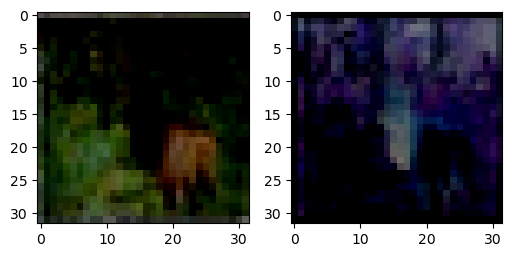

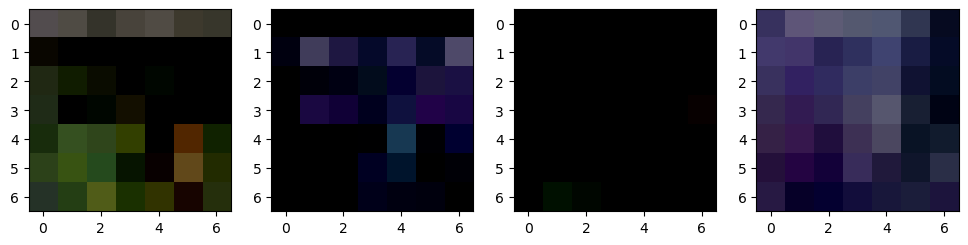

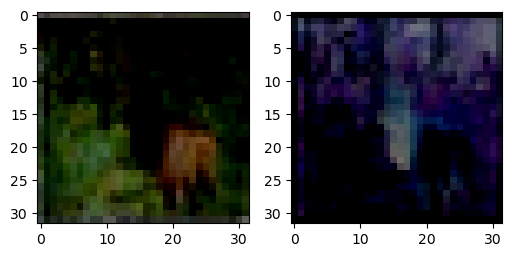

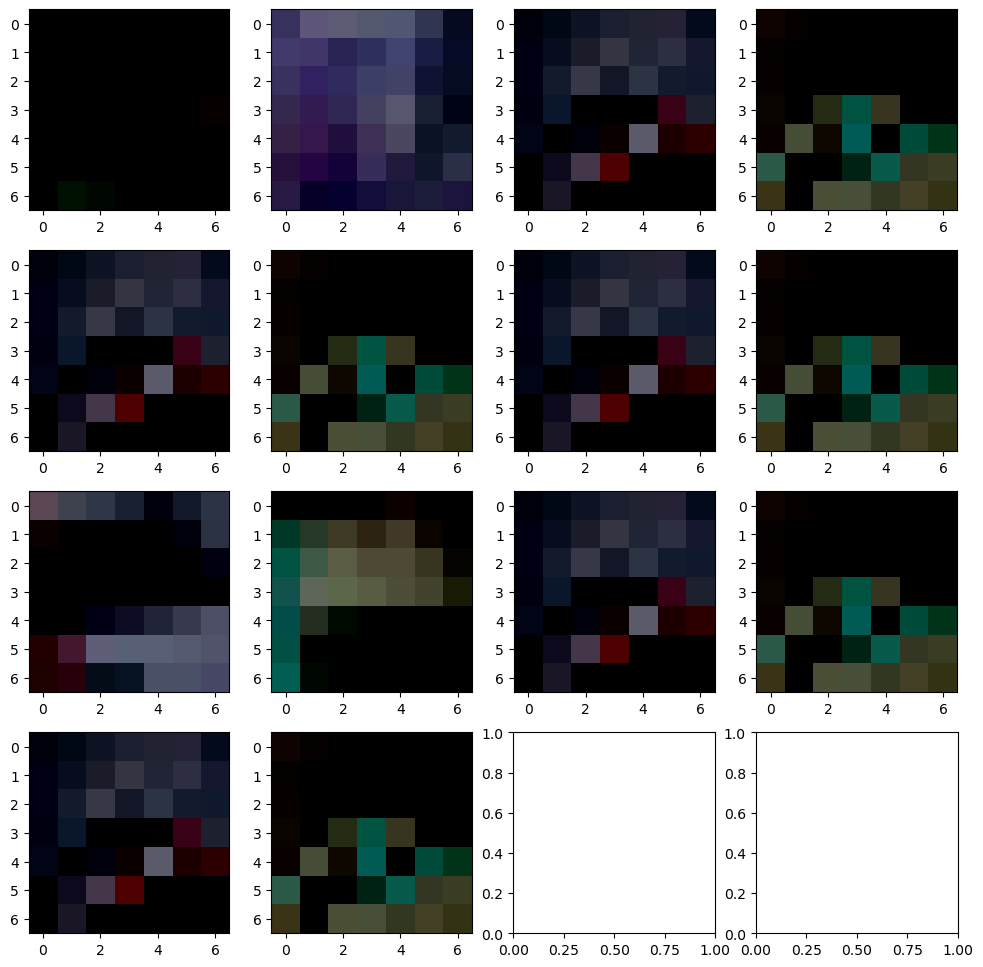

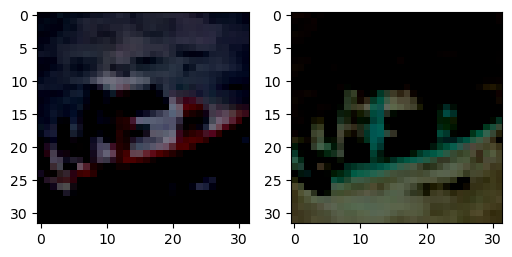

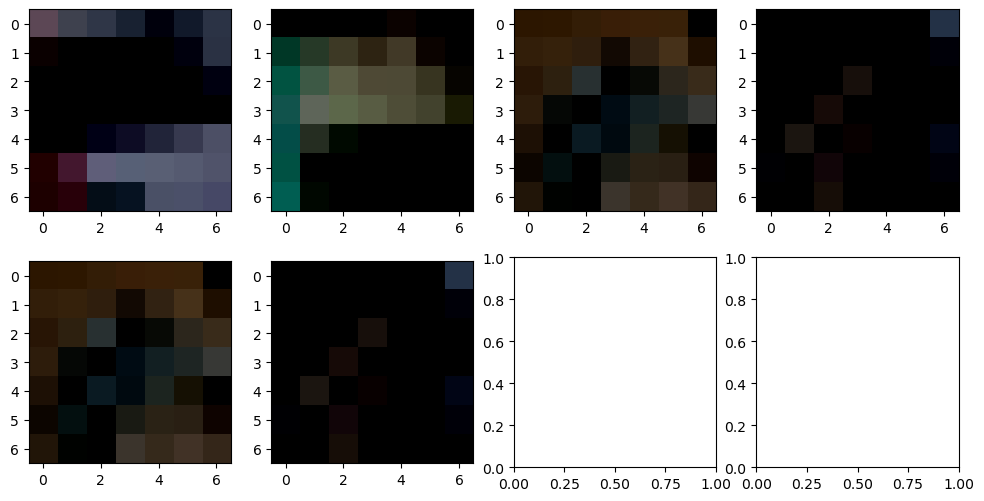

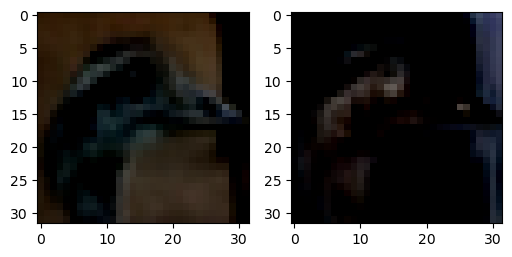

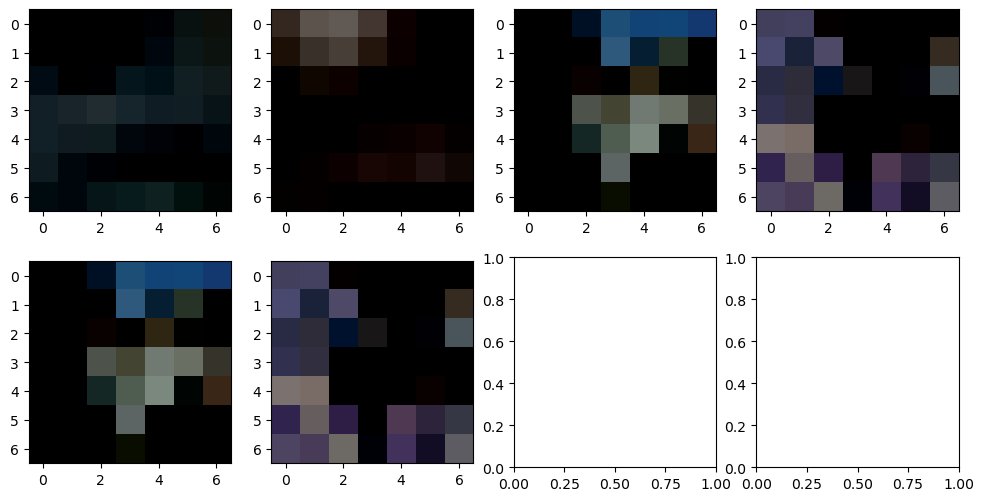

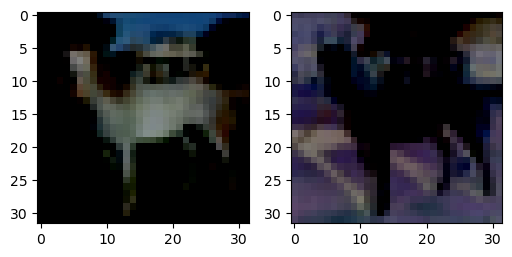

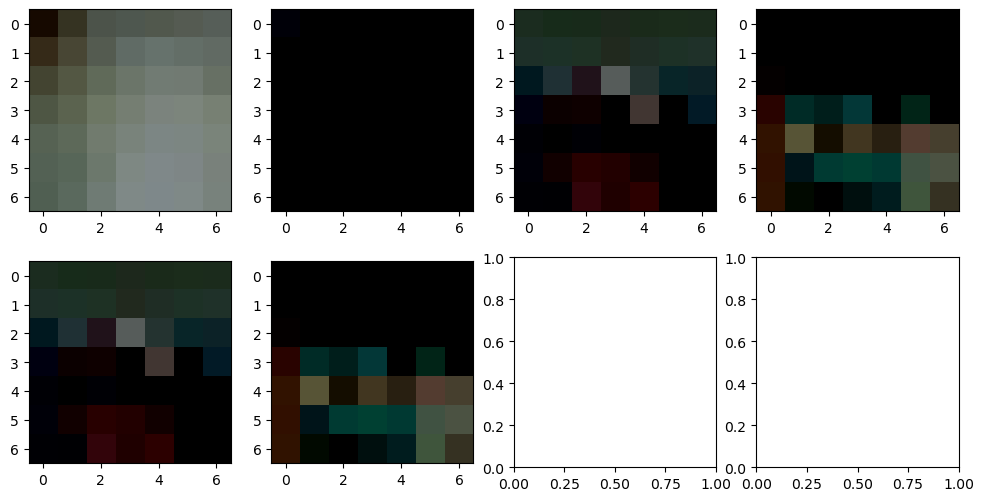

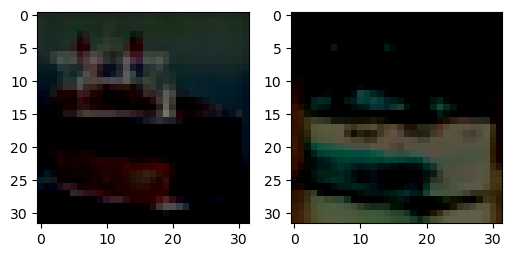

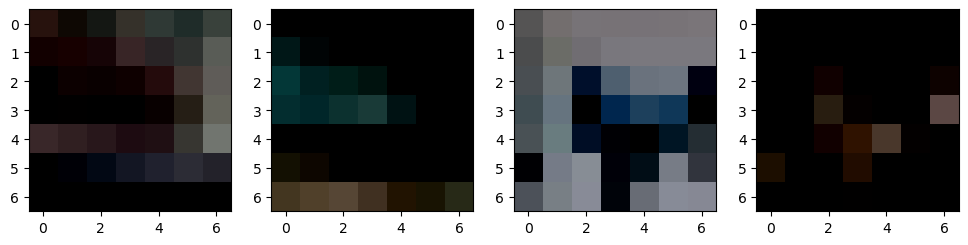

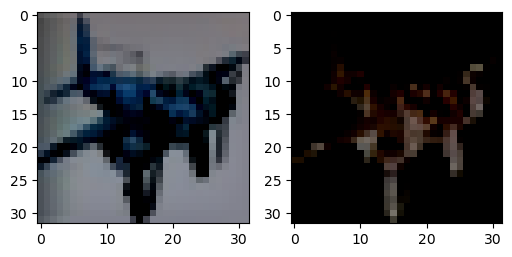

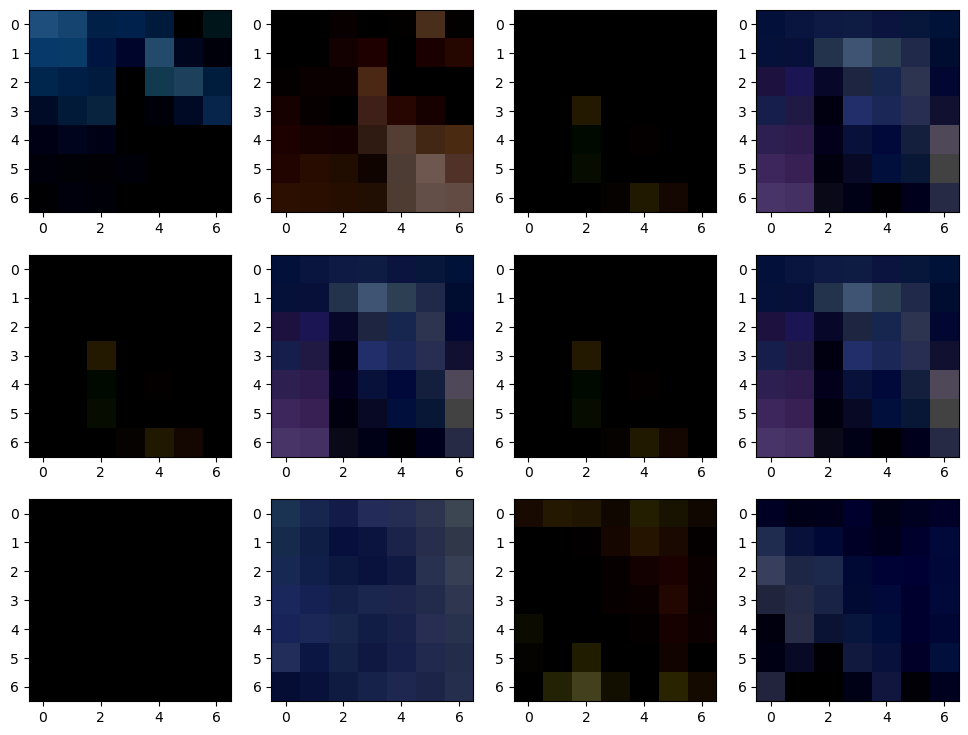

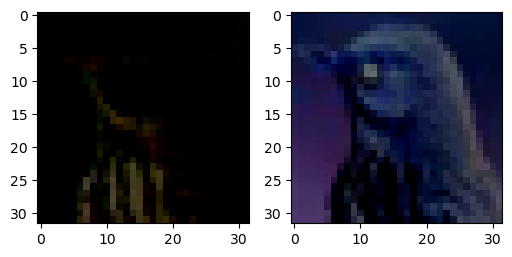

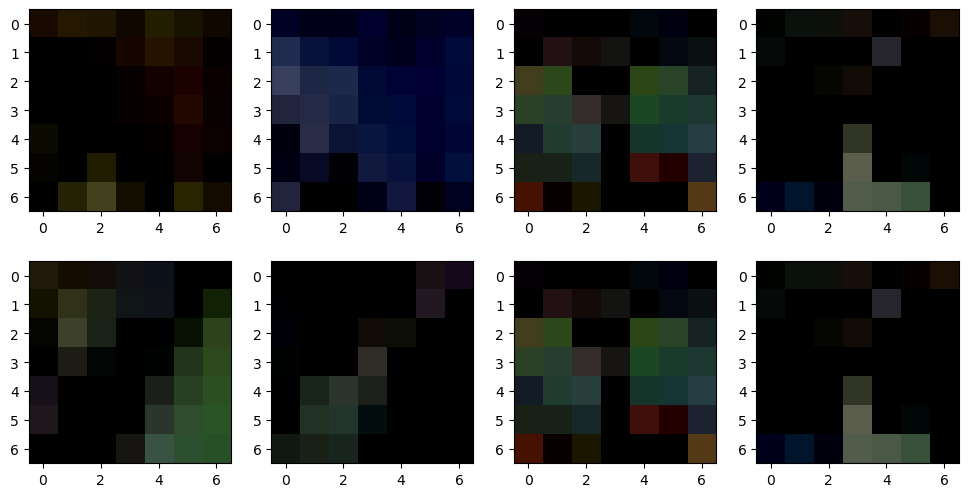

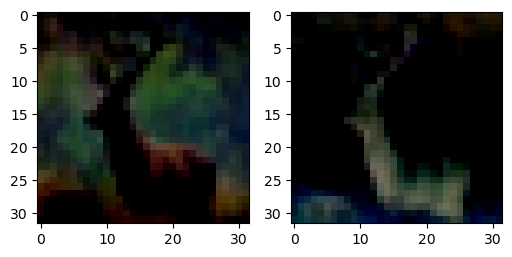

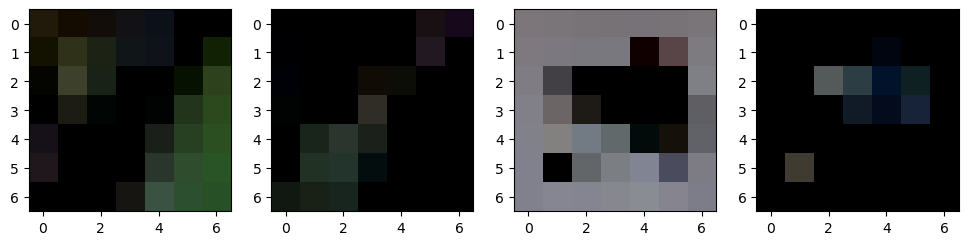

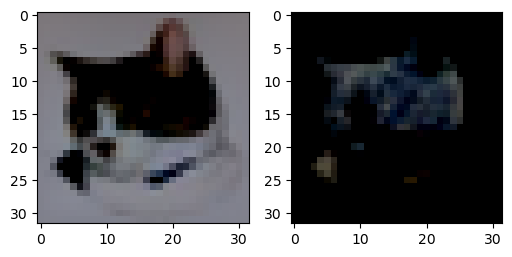

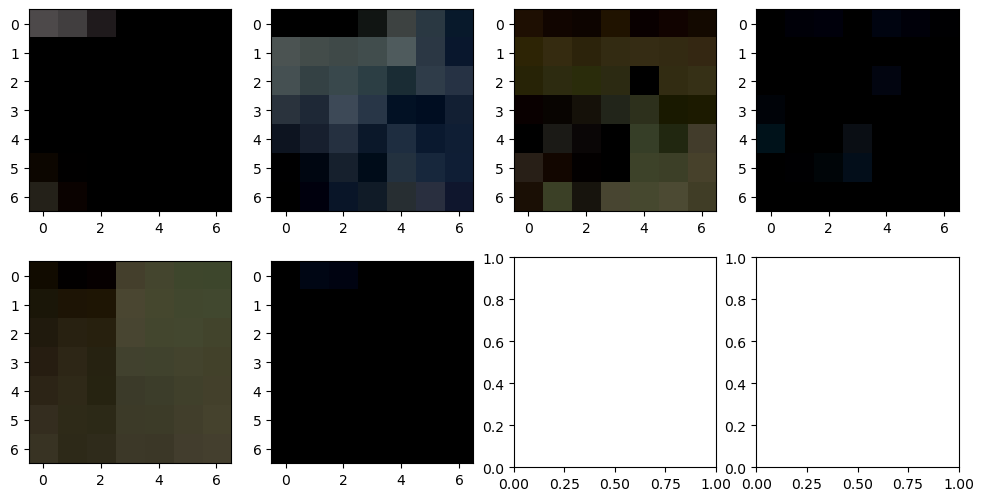

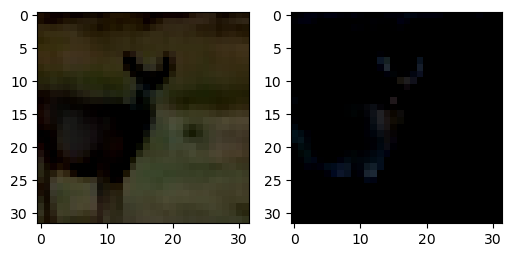

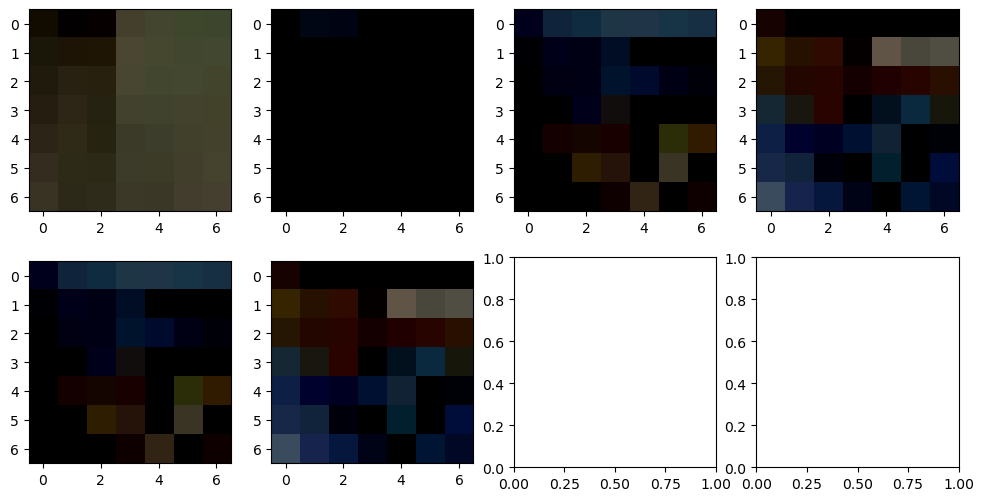

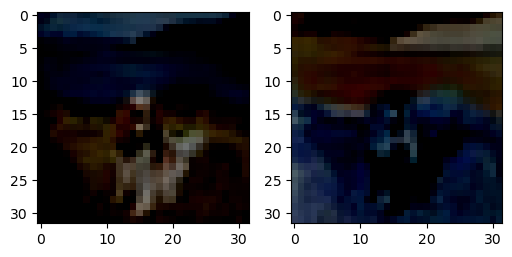

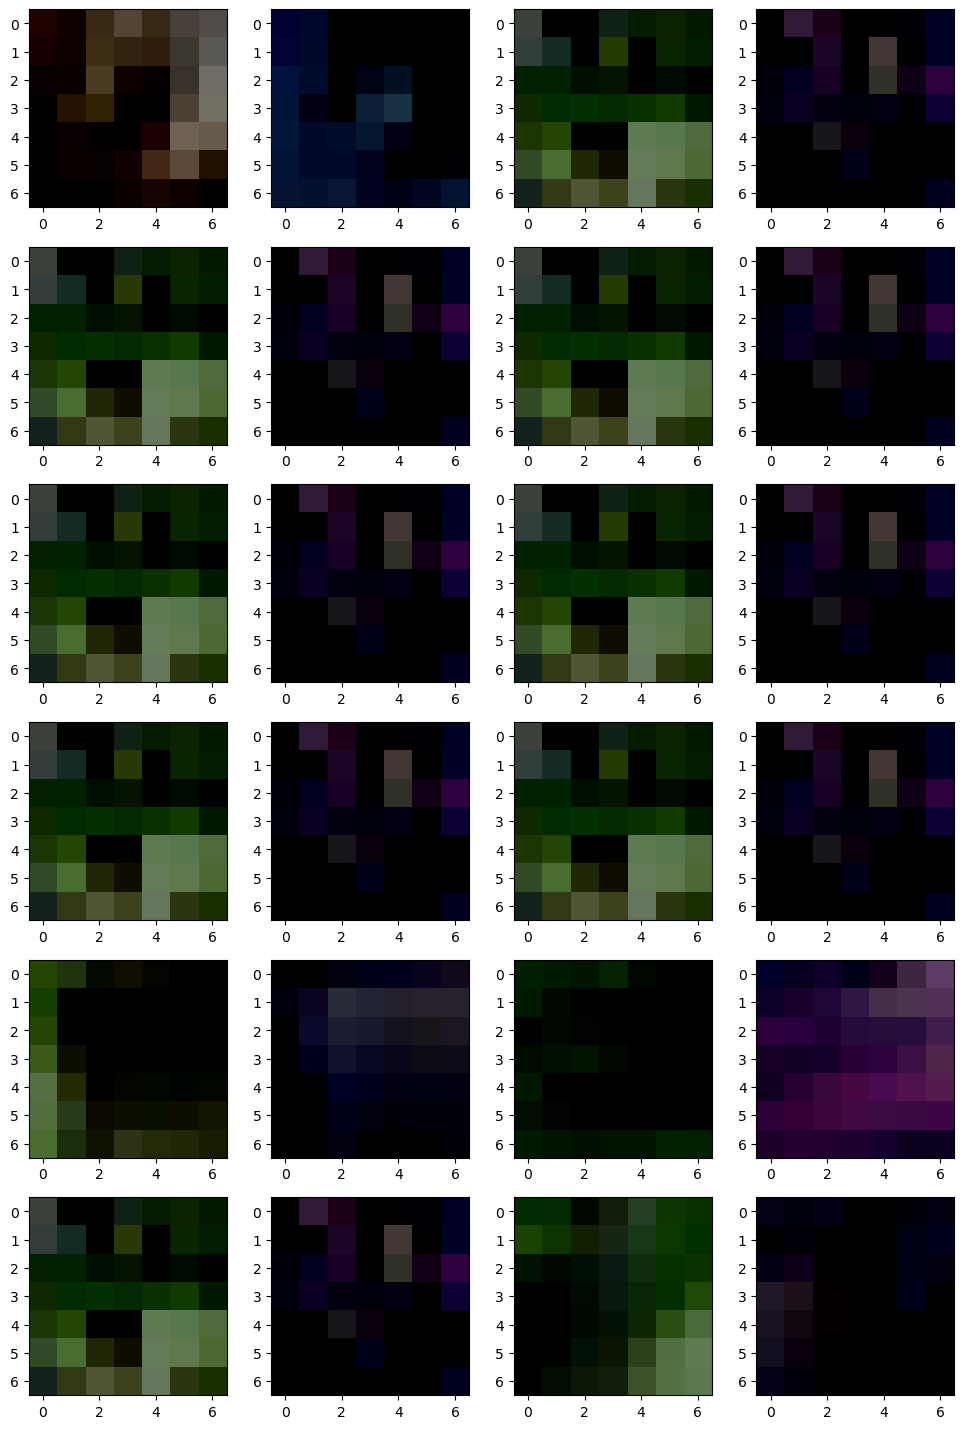

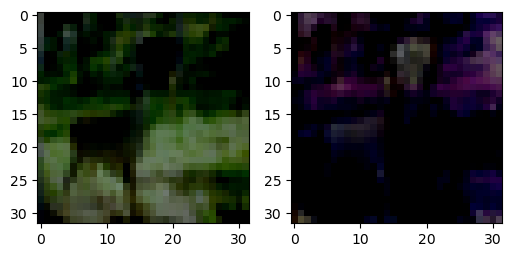

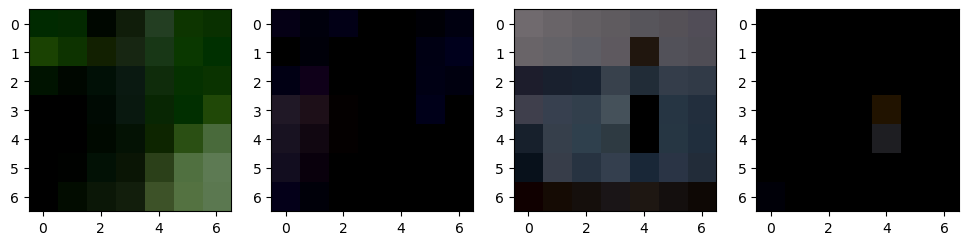

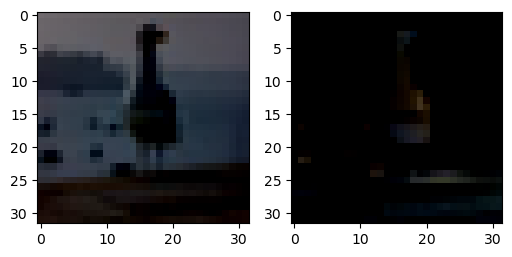

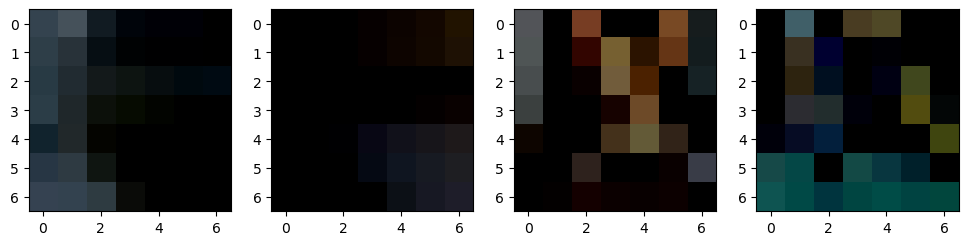

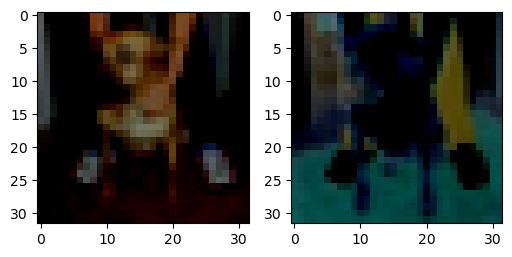

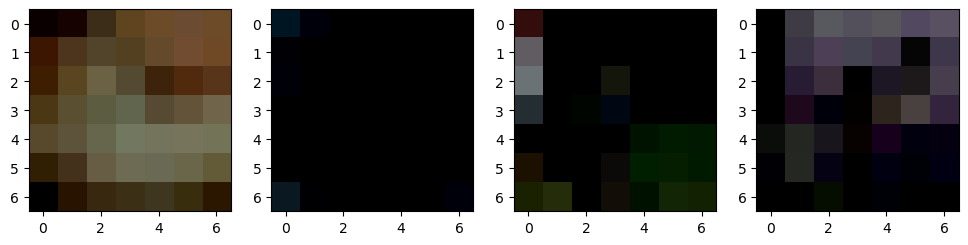

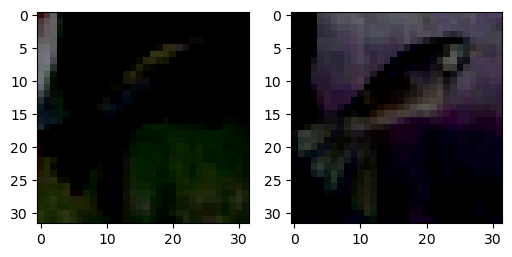

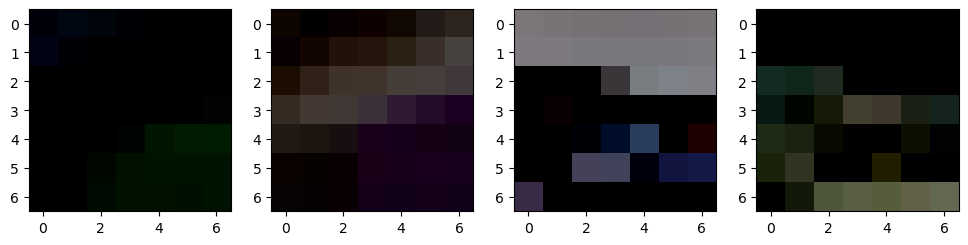

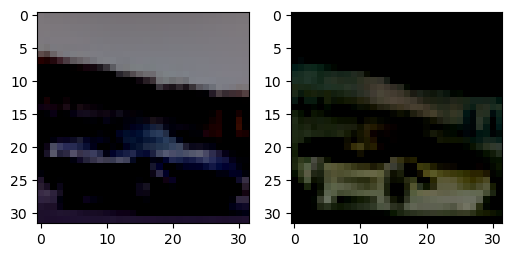

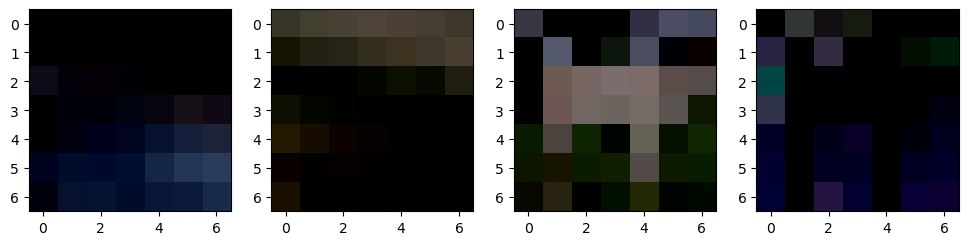

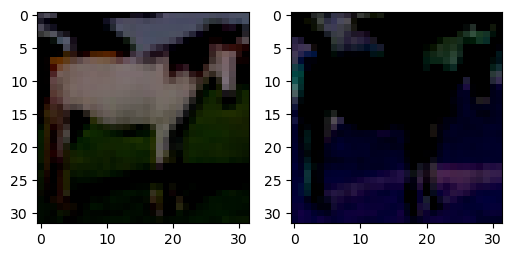

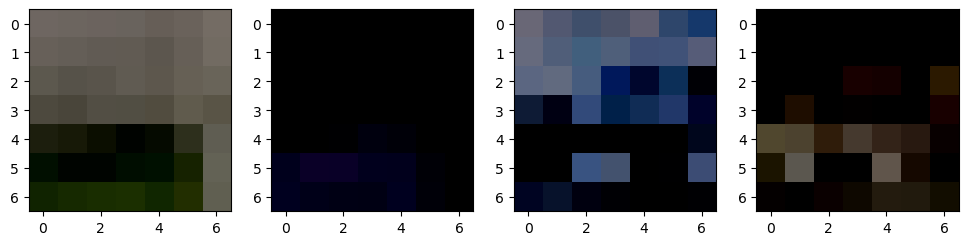

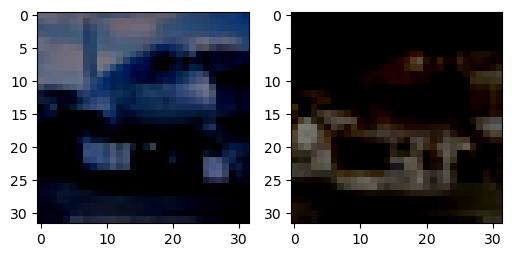

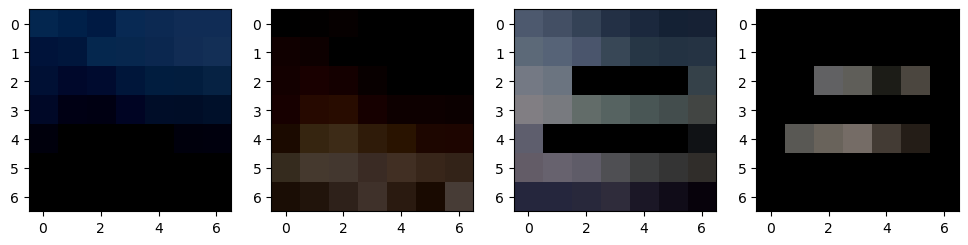

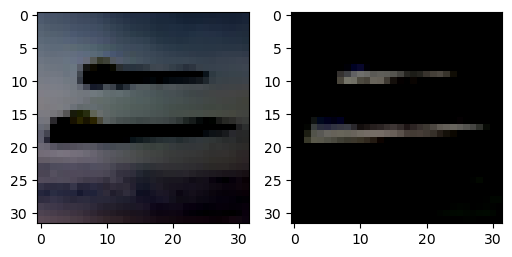

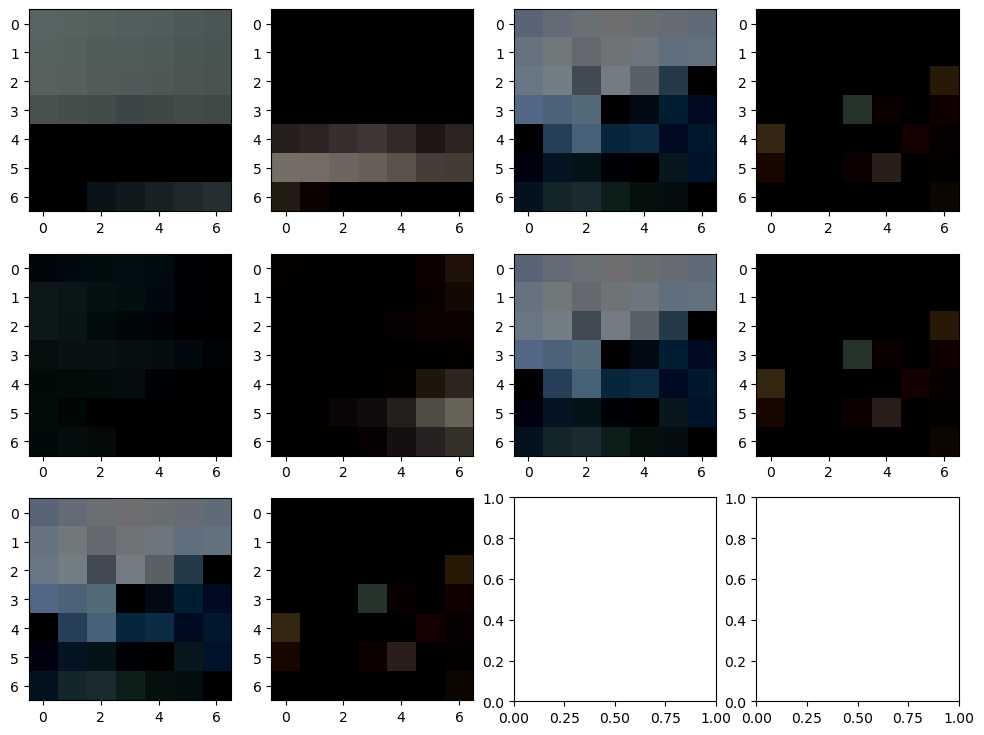

In [497]:
n_steps = len(results['o'])
actions = ['zoom', 'move', 'ans']

t = 0
ep = 0
while t < n_steps and ep < 20:
    ix = results['ix'][t]
    print(f'{ix=}')
    plot_obs_seq([analysis_env.data.images[ix]], ds.image_shape, max_col=2, img_size=(3, 3))

    os = []
    while t < n_steps:
        o = results['o'][t][0]
        os.append(o)
        pos_oh = results['pos'][t]
        pos = _from_one_hot_pos(pos_oh, analysis_env.pos_range)[0]
        pos_ = 'TH' if np.all(pos == -1) else pos

        a_env = results['a_env'][t][0]
        zma = a_env[0]
        c = a_env[1]
        move = a_env[2:]

        a_res = (
            'TH' if zma == 0 
            else c if zma == 2 
            else move
        )
        print(f'{pos_} --> {actions[zma]} --> {a_res}')
        done = results['done'][t]
        if done:
            r = results['r'][t][0]
            print(f'Class: {c}  | {int(r) > 0}')
            print()

        t += 1
        if done:
            break
    ep += 1

    plot_obs_seq(os, ds.image_shape, max_col=2, img_size=(3, 3))